In [1]:
#imports
import os,sys
import glob
from astropy.io import fits
import numpy as np
import numpy.ma as ma
from astropy.io.fits import getdata
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.ndimage import maximum_filter1d
from scipy.signal import medfilt, find_peaks, detrend
from datetime import datetime
import smplotlib


balmer = np.array([397.0, 410.17, 434.05, 486.14, 656.45])
deg = np.pi/180.
h = const.h
c = const.c
k = const.k_B

#def utils
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

class grism_utils:
    def __init__(self, grism_image, rot_angle, box, f_wave,f_gain):
        ''' Utilities for calibrating and plotting spectra from grism images'''
        
        self.grism_image = grism_image
        self.cal_file = cal_file
        self.balmer = np.array([397.0, 410.17, 434.05, 486.14, 656.45])
        self.wavelength_range = [380,750]
        
        ''' Open image, extract header information '''
        im, hdr = getdata(grism_image, 0, header=True)
        self.im = im
        self.hdr = hdr
        self.object_name  = hdr['OBJECT']
        self.obs_date     = hdr['DATE-OBS'][:-12].replace('T',' ')
        self.telescope    = hdr['TELESCOP']
       # self.camera       = hdr['CAMSN'][0:6]
        self.imsize_x = hdr['NAXIS1'] ; self.imsize_y = hdr['NAXIS2']
        # Create default plot title
        self.title = '%s (%s)\nGrism spectrum: %s ' % \
        (self.object_name, self.obs_date, self.telescope)
                                                     
        self.rot_angle = rot_angle
        self.box = box
        self.f_wave = f_wave
        self.f_gain = f_gain
        
    def summary_info(self):
        return self.object_name, self.obs_date,self.telescope,self.title,self.im,self.rot_angle, self.box, self.f_wave, self.f_gain
    
    def create_subimage(self):       
        ''' Create a strip subimage using parameters from calibration file, or user-supplied'''
        
        # Rotate full image                 
        im_rot = np.fliplr(self.im)
        
        # Flip image so L-> R corresponds to short -> long wavelength 
        im_flip = rotate(im_rot, self.rot_angle,reshape=False)
        
        # Trim image to subimage using box
        xmin,xmax,ymin,ymax = self.box
        self.subim = im_flip[ymin:ymax,xmin:xmax]
        return self.subim
    
    def create_box(self):       
        ''' Create a strip subimage using parameters from calibration file, or user-supplied'''
        
        
        # Flip image so L-> R corresponds to short -> long wavelength                
        im_flip = np.fliplr(self.im)
        
        # Rotate full image  
        im_rot = rotate(im_flip, self.rot_angle,reshape=False)
        
        # Trim image to subimage using box
        xstart,ystart,xwidth,ywidth = self.box
        self.subim = im_rot[ystart:ystart+ywidth,xstart:xstart+xwidth]
        return self.subim , im_rot
    
    def plot_image(self,image = None, vmin=None, vmax=None, title='',figsize =(8,4),cmap='gray'):
        '''Plot image: defaults to full image '''
        fig, ax = plt.subplots(figsize=figsize)
        zmean = np.median(image); s = np.std(image)
        if vmin == None:
            vmin = zmean - 2*s; 
        if vmax == None:
            vmax = zmean + 12*s
        myplot = ax.imshow(image,cmap=cmap, vmin= vmin, vmax = vmax)
        plt.title(title)
        return fig 
    
    def calibrate_spectrum(self,subim):
        '''Calculates raw spectrum by summing pixels in all vertical slices, then apply wavelength, gain calibration'''

        pixels = np.arange(subim.shape[1])
        # find sum of pixel values along each column (spectral channel)
        uncal_amp = []
        for pixel in pixels:
            ymax,signal,signal_max = self.__calc_channel_signal(subim,pixel)
            uncal_amp.append(signal)
        uncal_amp = np.array(uncal_amp)
        uncal_amp /= np.max(uncal_amp) # Normalize
     
        # Wavelength calibration
        wave = self.f_wave(pixels)
    
        # Gain calibration
        gain_curve = self.f_gain(wave)
        cal_amp = uncal_amp / gain_curve
    
        spectrum = np.vstack([pixels,wave,uncal_amp,cal_amp])
        return spectrum

    def __calc_channel_signal(self,subim,xpixel):  
        ''' Calculates total counts in specified spectral channel xpixel 
        by subtracting background and summing. The spectral signal is assumed 
        to be in middle half of the spectrum. '''
        
        yvals = subim[:,xpixel]
        yindex = np.arange(len(yvals))
        
        # Choose first, last quartiles for base, fit linear slope
        n1 = int(len(yindex)/4); n2 = 3*n1
        x1 = yindex[0:n1] ; x2 = yindex[n2:]
        y1 = yvals[0:n1]  ; y2 = yvals[n2:]
        X = np.concatenate((x1,x2),axis=0)
        Y = np.concatenate((y1,y2),axis=0)
        c = np.polyfit(X,Y,1) # linear fit  
        p = np.poly1d(c)
        base = p(yindex)
        # Calculate signal vs pixel by subtracting baseline, sum and get index of maximum pixel
        signal = yvals - base
        signal_max = np.max(signal)
        ymax = np.argmax(signal)       
        return(ymax, np.sum(signal),signal_max) 
    
    def plot_gain_curve(self, spectrum,wmin=350,wmax=750,color='r',title=''):
        ''' Plot the gain vs wavelength using the f_gain function '''
        p,w,u,c = self.clip_spectrum(spectrum,wmin,wmax)
        gain_curve =self.f_gain(w)
        gain_curve /= np.max(gain_curve)
        fig, ax = plt.subplots(1, 1,figsize=(8,5))
        ax.plot(w,gain_curve,color =color)
        plt.suptitle(title)
        plt.grid()
        return fig
    
    # Normal 2x2 grism plot
    def plot_2x2(self,object_spectrum, reference_spectrum,title='', medavg=1):
        ''' Creates 2x2 plot: 
        UL: uncalibrated object spectrum
        UR: Gain curve
        LL: Calibrated object spectrum
        LR: Reference spectrum 
        Note: object spectrum has 4 rows (pixels, wavelength, uncal. amp., calib. amplitude), 
        reference spectrum has 2 rows (wavelength, calib. amplitude)'''
    
        _,wave, amp_uncal, amp_cal = object_spectrum
        wave_ref,amp_ref = reference_spectrum
    
        # Median average if requested
        amp_uncal = medfilt(amp_uncal,kernel_size = medavg) 
        amp_cal = medfilt(amp_cal,kernel_size = medavg) 
    
        fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(10,8))
        plt.suptitle(title)
        # Uncalibrated spectrum
        ax1.plot(wave, amp_uncal)
        ax1.set_xlabel('Wavelength')
        ax1.set_ylabel('Uncalibrated amp.')
        ax1.set_title('Raw Spectrum')
        ax1.grid()

        # Gain curve
        gain =  self.f_gain(wave_ref)
        gain /= np.max(gain)
        ax2.plot(wave_ref,gain,'k.',ms=2)
        ax2.set_xlabel('Wavelength')
        ax2.set_ylabel('Gain')
        ax2.set_xlim(380,750)
        ax2.set_title('Gain vs. Wavelength')
        ax2.grid()

        # Calibrated amplitude
        ax3.plot(wave, amp_cal)
        ax3.set_xlabel('Wavelength')
        ax3.set_ylabel('Calibrated amplitude')
        ax3.set_xlim(380,750)
        ax3.set_title('Calibrated Spectrum')
        ax3.grid()

        # Reference spectrum
        ax4.plot(wave_ref, amp_ref)
        ax4.set_xlabel('Wavelength')
        ax4.set_ylabel('Calibrated amplitude')
        ax4.set_title('Jacoby Spectrum')
        ax4.grid()
        plt.tight_layout()
        return fig

    def fit_gaussian(self,spectrum,wave_min,wave_max):
        '''Fit a Gaussian function to spectral line in the wavelength range wave_min to wave_max.
        Returns fitted parameters with uncertainties and a plot of spectral line and fitted Gaussian'''
    
        # Constrain spectrum to desired wavelength range, unpack needed arrays
        _,wave,_,amp = self.clip_spectrum(spectrum,wave_min,wave_max)
    
        # Detrend to remove slope
        amp = detrend(amp)
    
        # Find index of max value
        imax = np.argmax(np.abs(amp))
    
        # Fit a Gaussian model
        p0 = (wave[imax],amp[imax],2,0,0)
        params, pcov = curve_fit(self.__gftn, wave, amp,p0)
        wave_ctr, a, fwhm,m,b = params
        amp_mod = self.__gftn(wave, *params)
    
        # Extract uncertainties from covariance
        wave_ctr_err, a_err, fwhm_err, _ ,_ = np.abs(np.sqrt(np.diag(pcov)))
        f= 2*np.sqrt(2*np.log(2)) *0.5 # sigma -> FWHM factor 
        fwhm *= f; fwhm_err *= f
        fwhm = np.abs(fwhm)
        params = (wave_ctr,wave_ctr_err,fwhm,fwhm_err,a,a_err)
        return params, wave, amp, amp_mod

    def plot_spectral_line(self,wave,amp,amp_mod,color='r',title=''):
        fig, ax = plt.subplots(1, 1,figsize=(8,5))
        ax.plot(wave,amp_mod,color =color)
        ax.plot(wave,amp,'k.')
        T = '%s\n$\lambda_c$ = %.1f +/- %.1f nm, FWHM = %.1f +/- %.1f nm' % \
            (title,wave_ctr,wave_ctr_err,fwhm,fwhm_err)
        plt.suptitle(T)
        plt.grid()
        return fig
    
    def __gftn(self,x, x0, a, sigma, m, b):
        ''' Define a Gaussian function with a sloping pedestal '''
        t = (x-x0) /sigma
        f = a*np.exp(-t**2) + m*x + b
        return f

    def clip_spectrum(self,spectrum, wave_min, wave_max):
        '''Restrict wavelength range to avoid crazy gain curve at edges '''
        pixel, wave, uncal_amp, cal_amp = spectrum
        mask = (wave > wave_min) & (wave < wave_max)
        pixel_m = pixel[mask]
        wave_m  = wave[mask]
        uncal_amp_m   = uncal_amp[mask]
        cal_amp_m = cal_amp[mask]
        spectrum = np.vstack( [pixel_m, wave_m,uncal_amp_m, cal_amp_m] )
        return spectrum
    
    def plot_spectrum(self, spectrum, xaxis = 'pixel',yaxis = 'uncal', subrange = slice(0,9999), title='', \
        jacoby = False, plot_balmer = False, medavg = 1,xlims =[0,0],ylims =[0,0],calib='default'):
        '''Plots science or Jacoby  spectrum, with selectable axes [x: pixels or wavelength; y: uncalibrated or calibrated. '''
        fig, ax = plt.subplots(1,1,figsize=(8, 4))           
        fig.suptitle(title) 
    
        if jacoby:
            w,c = spectrum
            s = subrange
            wave = w[s]; amp_cal = c[s]
            x = wave    ; ax.set_xlabel('Wavelength [nm]') 
            y = amp_cal ; ax.set_ylabel('Calibrated amplitude')
        else:
            # Slice spectrum by selecting user-selected pixel range (Unpythonic!)
            p,w,u,c = spectrum
            s = subrange
            p = p[s] ; w = w[s]; u =u[s]; c = c[s]
            spectrum = np.vstack([p,w,u,c])
        
            pixels, wave, amp_uncal, amp_cal = spectrum
            if xaxis == 'pixel':
                x = pixels ; ax.set_xlabel('Pixels')
            else:
                x = wave ; ax.set_xlabel('Wavelength [nm]')
            if yaxis == 'uncal':
                y = amp_uncal ; ax.set_ylabel('Uncalibrated amplitude')
            else:
                y = amp_cal   ; ax.set_ylabel('Calibrated amplitude')
  
        if plot_balmer:
            for b in balmer: ax.axvline(x=b,linestyle='dotted')
     
        # Median average if requested 
        y = medfilt(y,kernel_size = medavg)  
        ax.plot(x,y,'k-')    
        if xlims != [0,0]: 
            xmin,xmax = xlims
            ax.set_xlim(xmin,xmax)   
        if ylims != [0,0]: 
            ymin,ymax = ylims
            ax.set_ylim(ymin,ymax)
        else:
            ax.set_ylim(0,np.max(y)*1.1)  
        if calib == 'custom':
            ax.set_ylim(0,2.7e-11)
            ax.set_ylabel(r'Flux  (erg cm$^{-2}$ s$^{-1}$ Angstrom$^{-1}$)')
        ax.grid()
        return fig

#def reading
def read_calfile(fname):
    ''' Reads grism calibration file (.csv), extracts header line, subimage box, rotation angle, 
    and coefficients to generate functions that convert pixels to wavelength and gain vs wavelength'''
    with open(fname,'r') as f:
        lines = f.read().split('\n')
        hdr_line = lines[0]
        box = [int(x) for x in lines[1].split(',')]
        angle = float(lines[2])
        wavelength_coefficients = np.array([float(x) for x in lines[3].split(',')])
        gain_coefficients = np.array([float(x) for x in lines[4].split(',')] )    
    return(hdr_line, box, angle, wavelength_coefficients, gain_coefficients)

def read_jacoby_file(fname):
        ''' Reads a standard Jacoby .csv file, packs wavelength and amplitude arrays into spectrum object '''
        wave_ref, spec_ref = np.loadtxt(fname, unpack=True, \
        comments='#',usecols=(0,1),dtype = float)
        spec_ref /= np.max(spec_ref)
        jacoby_spectrum = np.vstack([wave_ref,spec_ref])  # contains wavelength and amp. arrays
        return jacoby_spectrum



<>:242: SyntaxWarning: invalid escape sequence '\l'
<>:242: SyntaxWarning: invalid escape sequence '\l'
C:\Users\MACRO\AppData\Local\Temp\ipykernel_18560\2883747185.py:242: SyntaxWarning: invalid escape sequence '\l'
  T = '%s\n$\lambda_c$ = %.1f +/- %.1f nm, FWHM = %.1f +/- %.1f nm' % \


In [2]:
image_dir = os.getcwd()+'/focus_images/'
    
# cal_dir = image_dir

# glob list:
image_list = glob.glob(image_dir + '*LowRes*.fts')
# cal_list = glob.glob(image_dir + '../*.csv')

#choose an image manually:
# image_name = 'OGGrism_focus2700_501.fts'
# image_name = 'OGGrism_focus2200_497.fts'
# image_name = 'OGGrism_focus1700_492.fts'
# image_name = 'OGGrism_focus1200_487.fts'
# image_name = 'OGGrism_focus700_482.fts'

root = str.split(image_list[0], '.')[0]
print('There are %d images in the directory ' % len(image_list))

#choose a cal file manually:
cal_file = os.getcwd()+'/grism_cal.csv'
print('Found calibration file: %s' % cal_file)

focus_list = []
profile_fwhm_list = []
gaussian_fwhm_list = []


There are 40 images in the directory 
Found calibration file: d:\scratch\Grism_focus_test_2024-04-15/grism_cal.csv


Found grism image: d:\scratch\Grism_focus_test_2024-04-15/focus_images\focus_1000_5s_LowRes_0.fts
Found calibration file: grism_cal.csv   Grism calibration for HD35619 observed 2023-03-05 created using python
Object: , Date: 2024-04-16T02:45:18.72
The output files will begin with RLMT_grism_d:\scratch\Grism._
1052 773
Creating subimage...
Drawing box at 550,755 with dimensions 1100,40
Full image dimensions: 2048,2048
Rotation angle = 357.3 deg
Maximum ADU count in subimage = 24770

Extracting spectrum...
Plotting...
Fitting feature...
Wave_ctr = 481.7 +/- 0.0 nm, FWHM = 1.3 +/- 0.0 nm

Plotting...
Found grism image: d:\scratch\Grism_focus_test_2024-04-15/focus_images\focus_1000_5s_LowRes_1.fts
Found calibration file: grism_cal.csv   Grism calibration for HD35619 observed 2023-03-05 created using python
Object: , Date: 2024-04-16T02:45:29.80
The output files will begin with RLMT_grism_d:\scratch\Grism._
1052 773
Creating subimage...
Drawing box at 550,755 with dimensions 1100,40
Full im

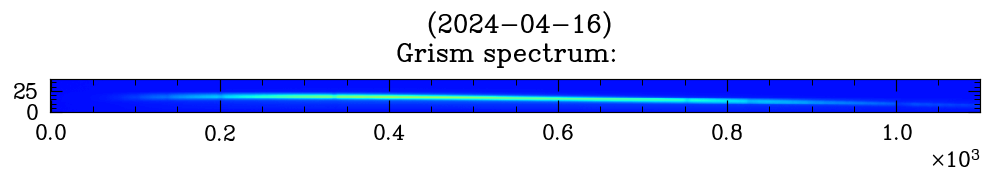

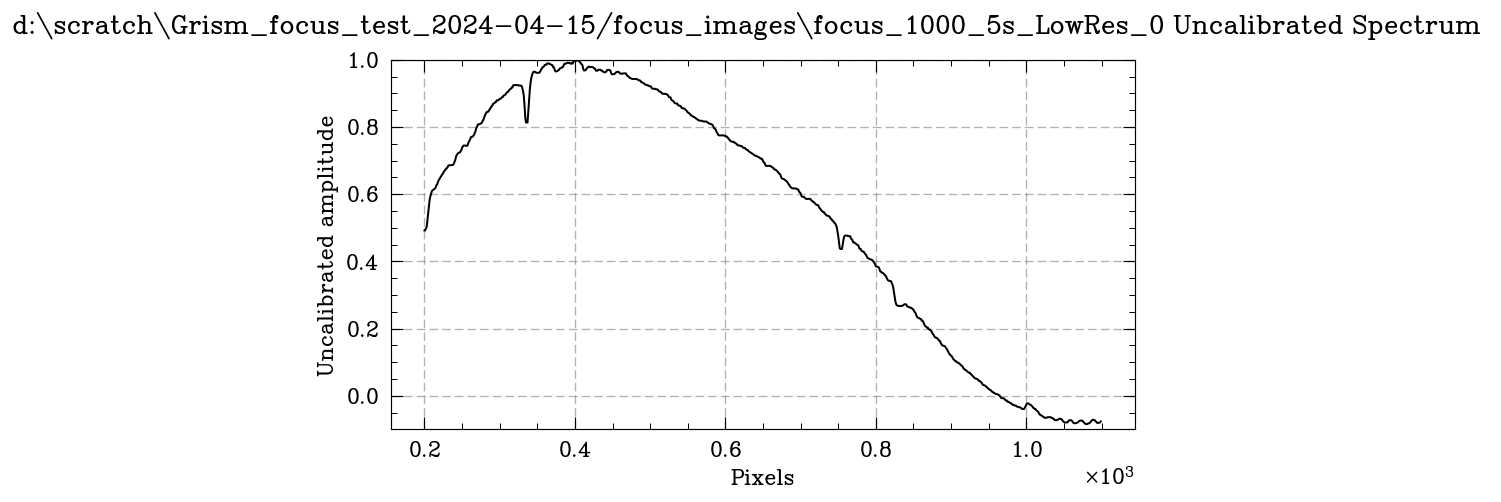

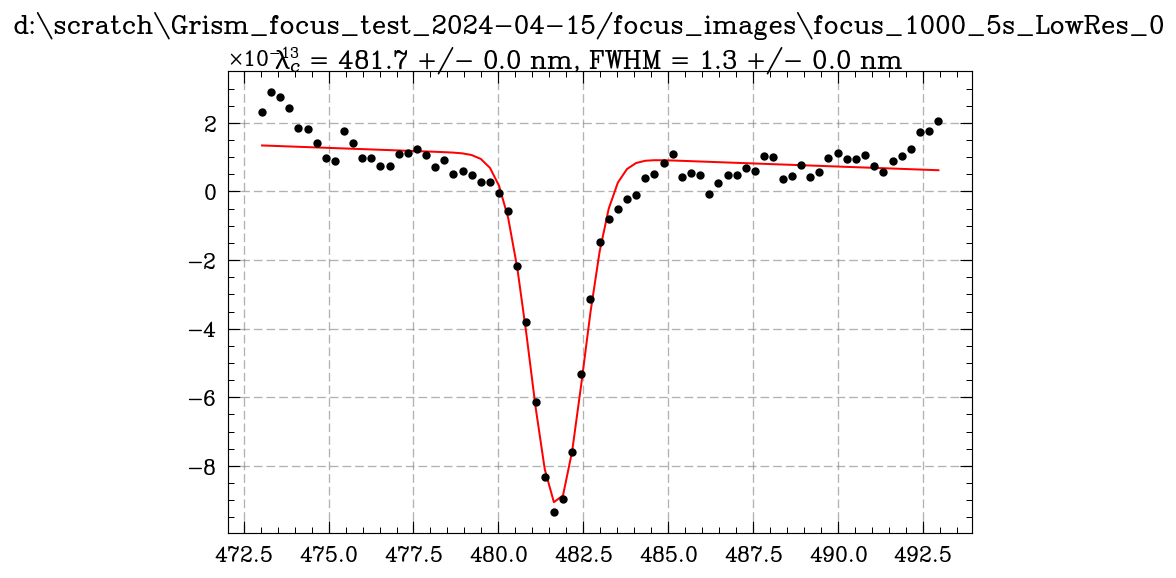

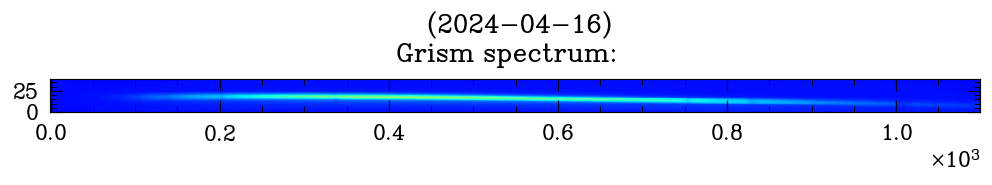

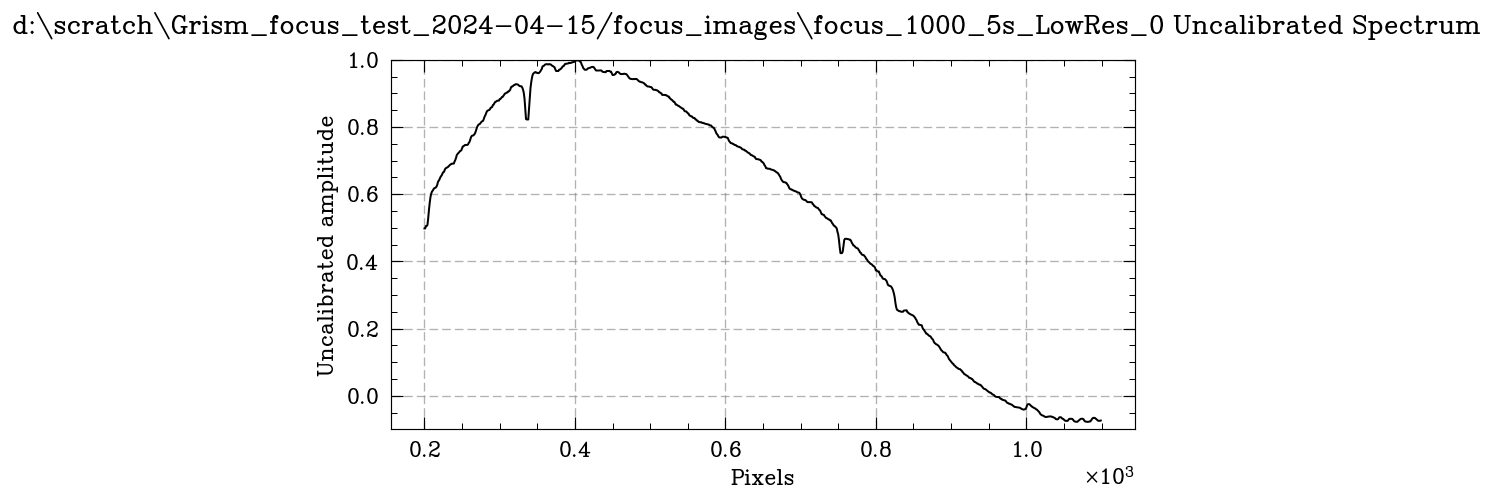

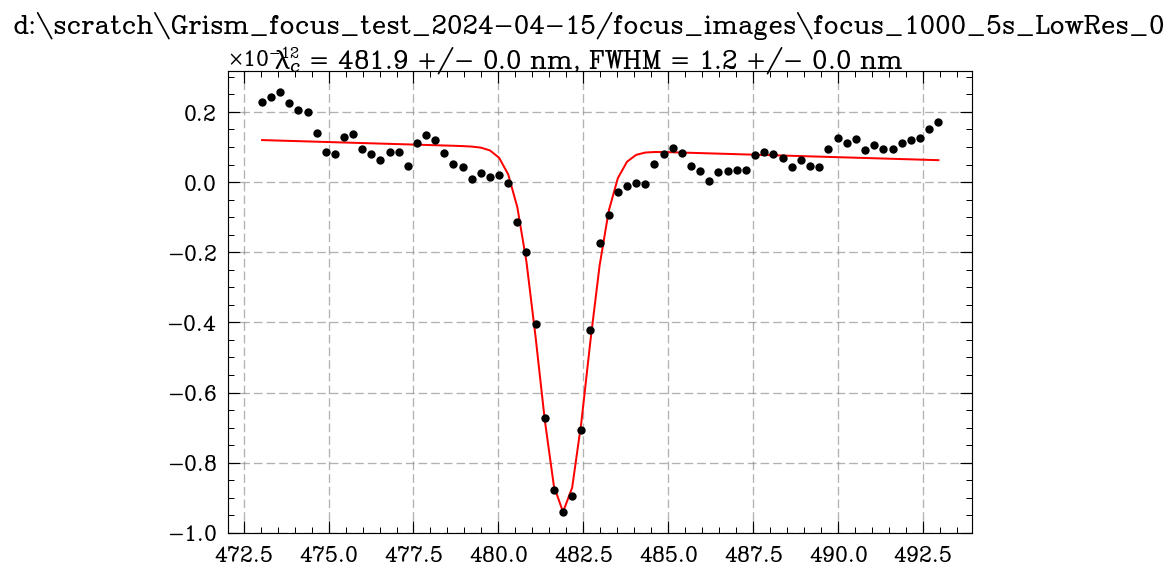

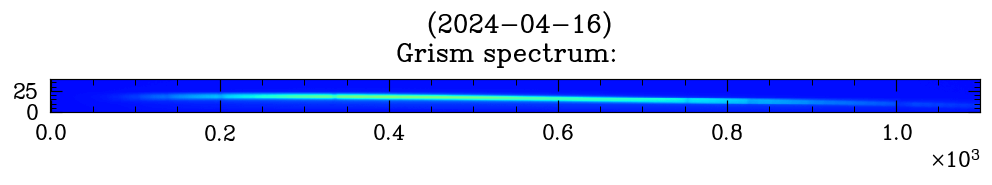

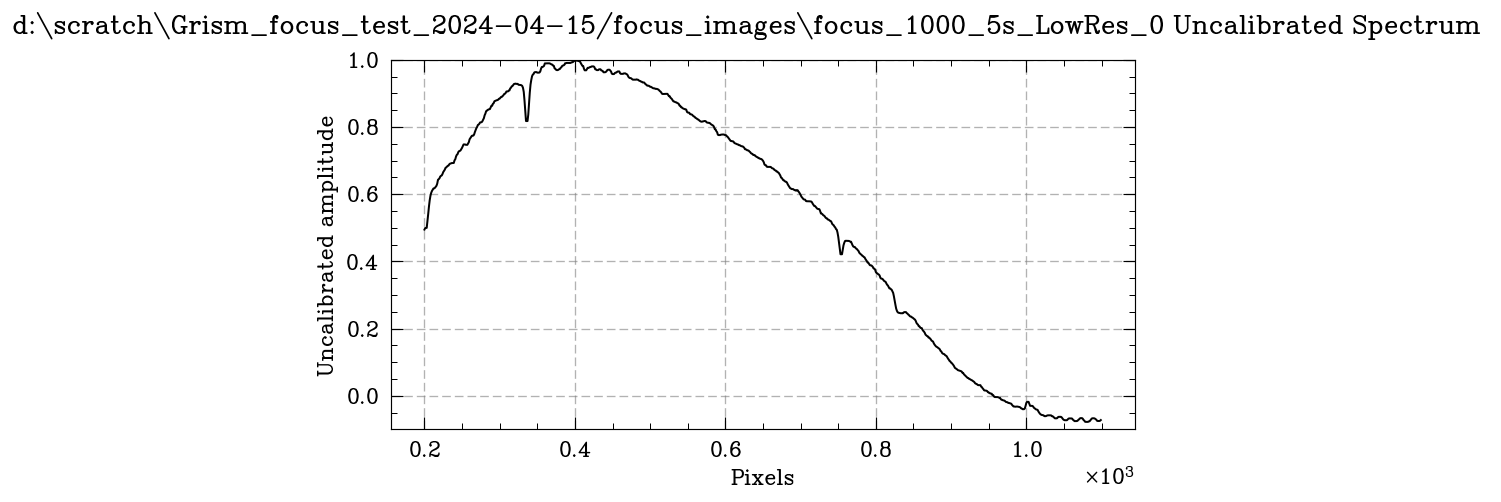

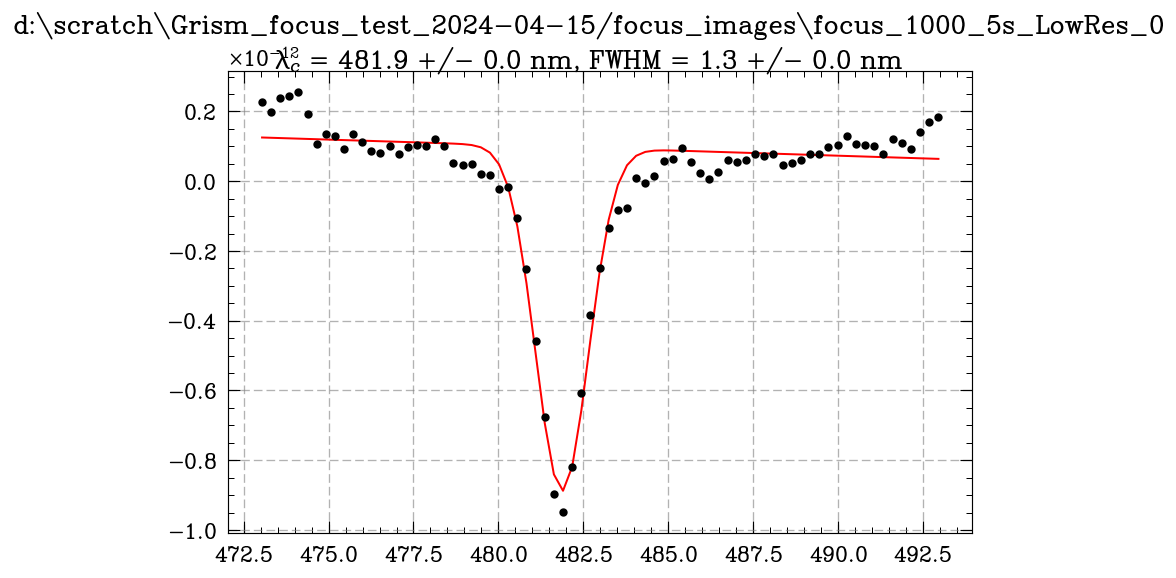

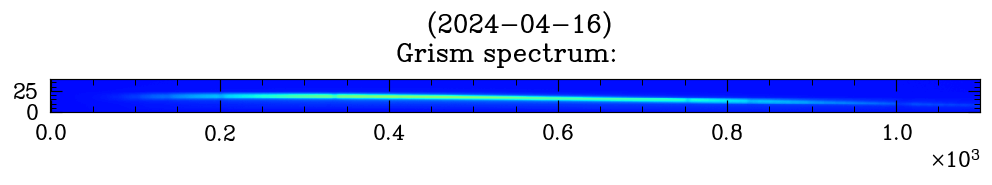

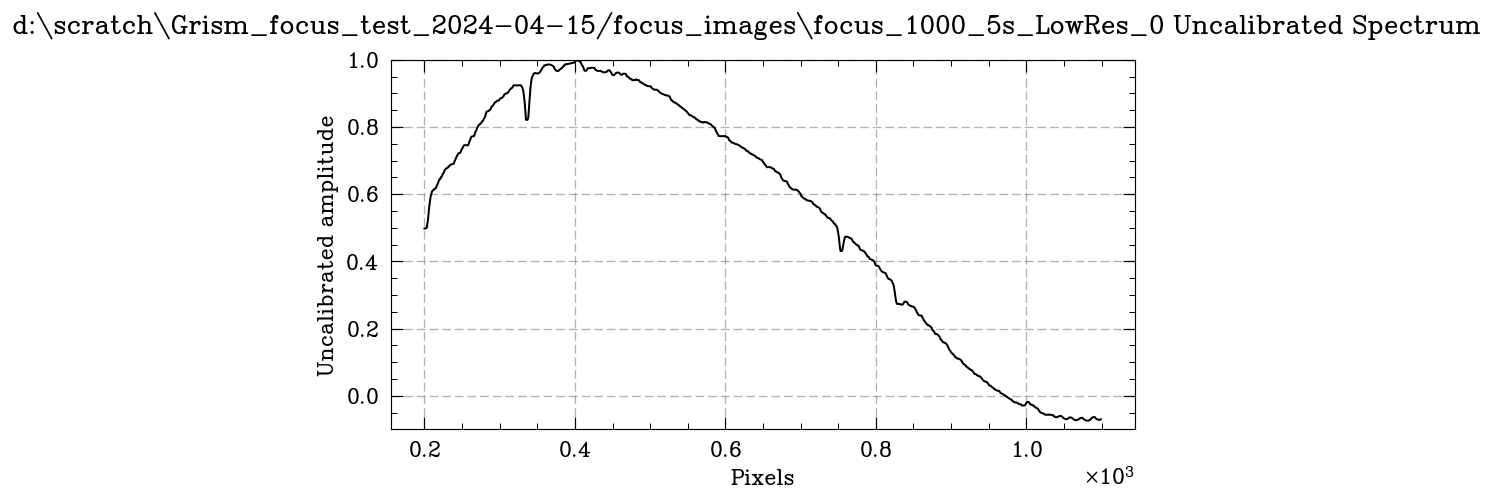

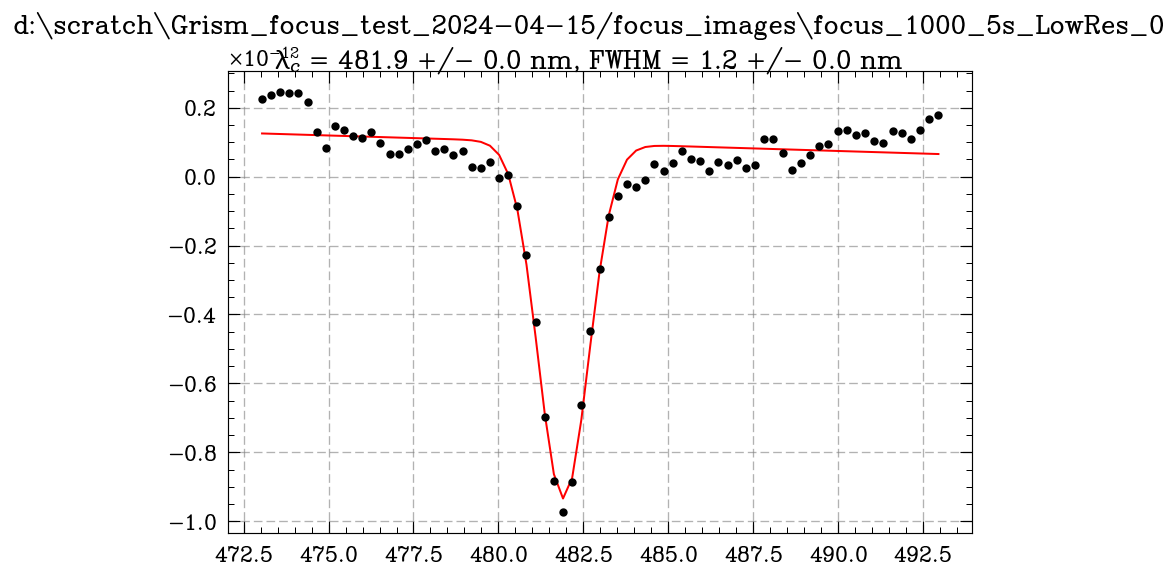

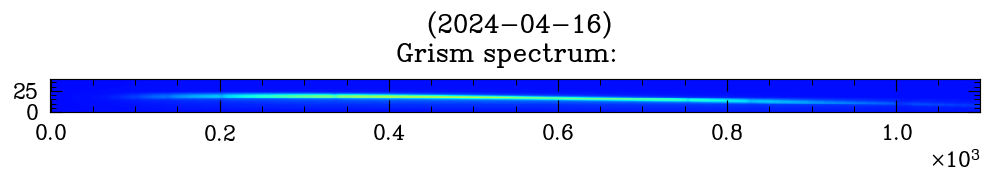

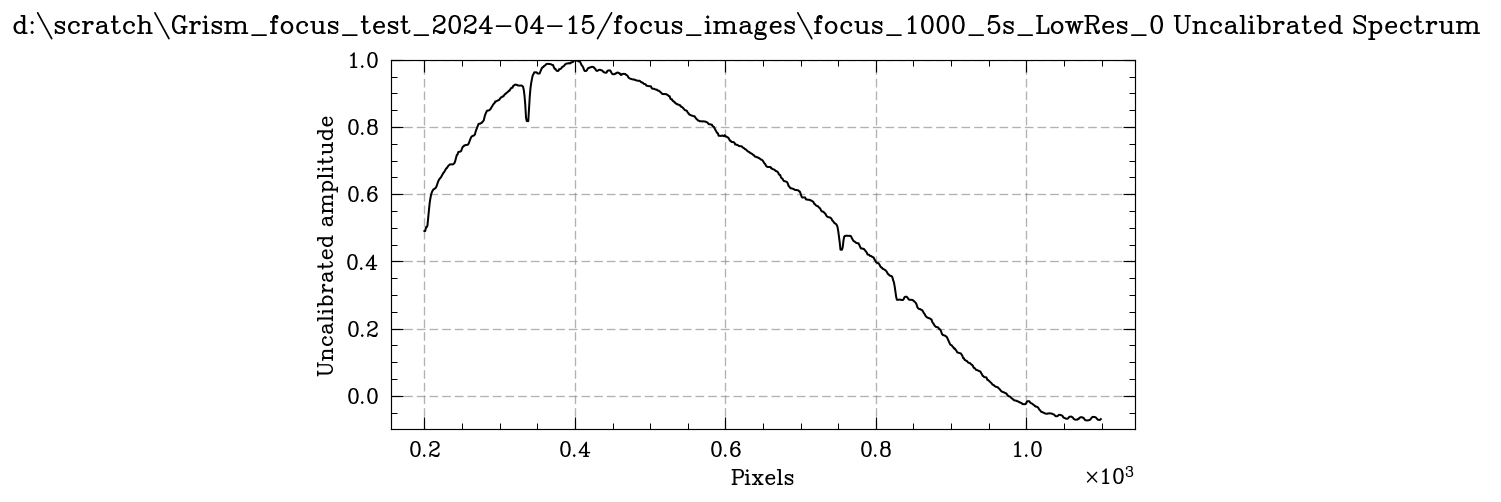

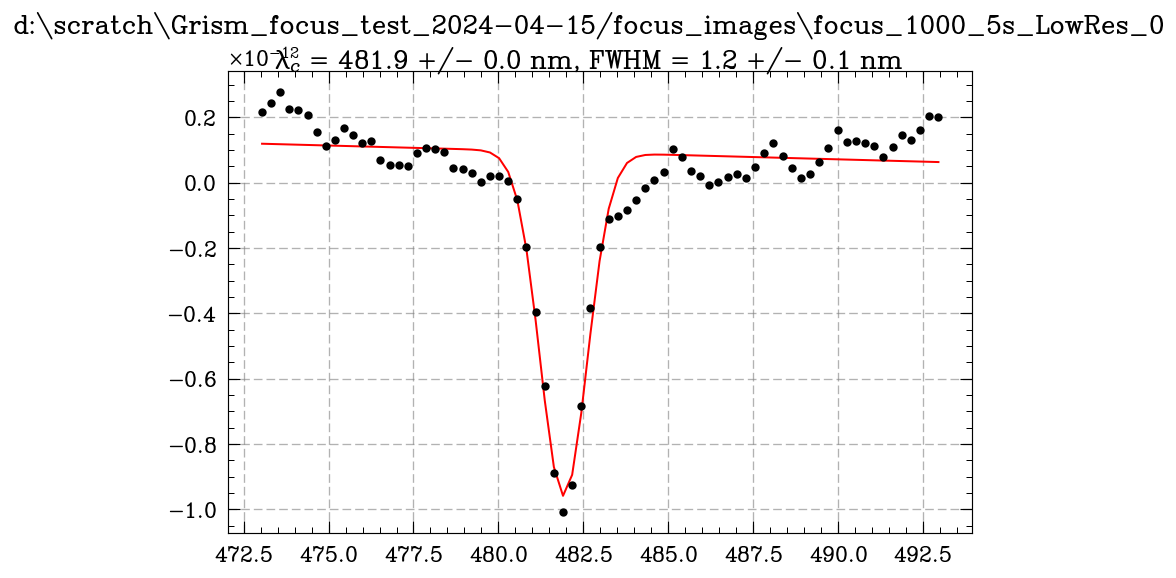

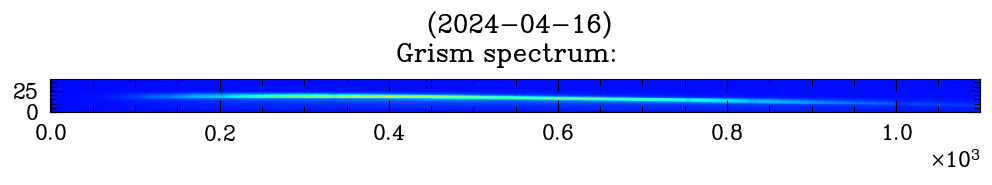

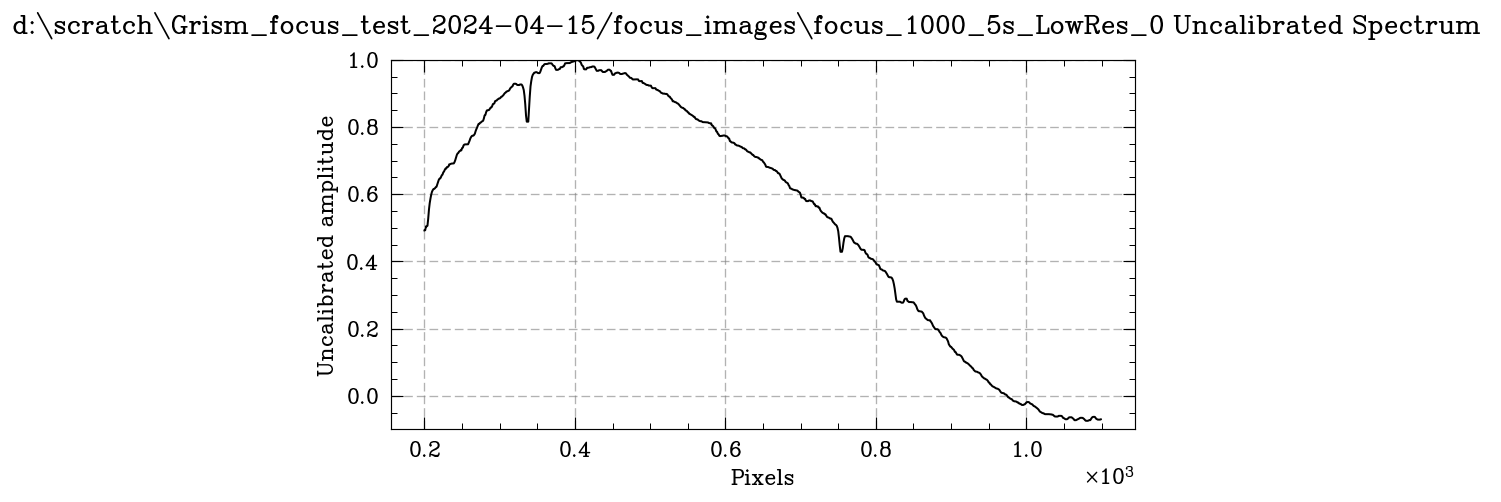

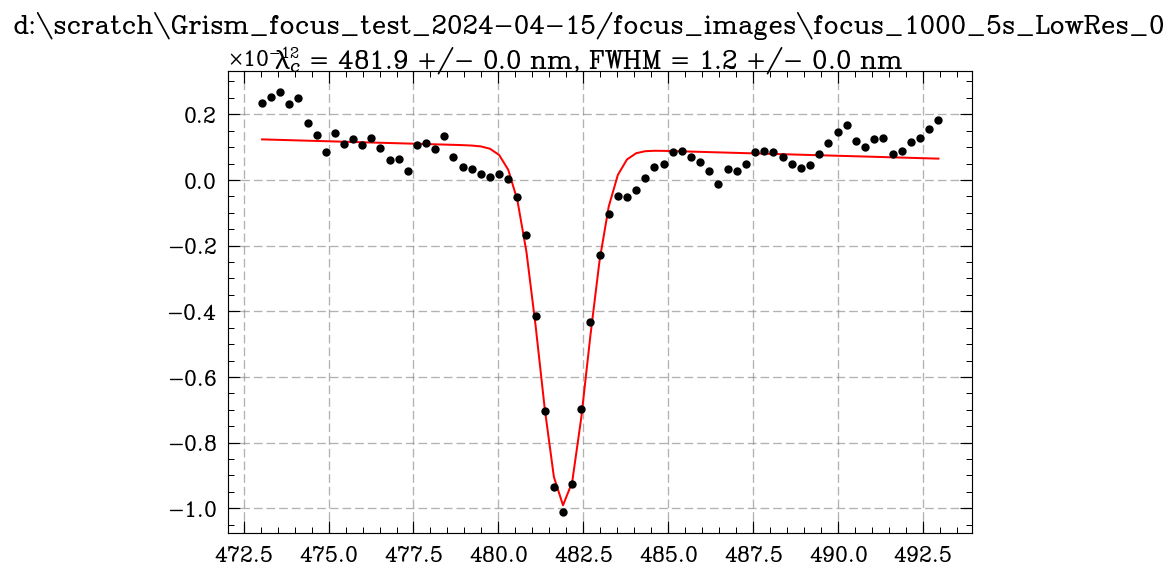

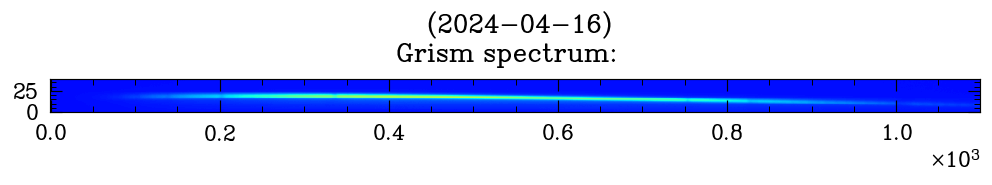

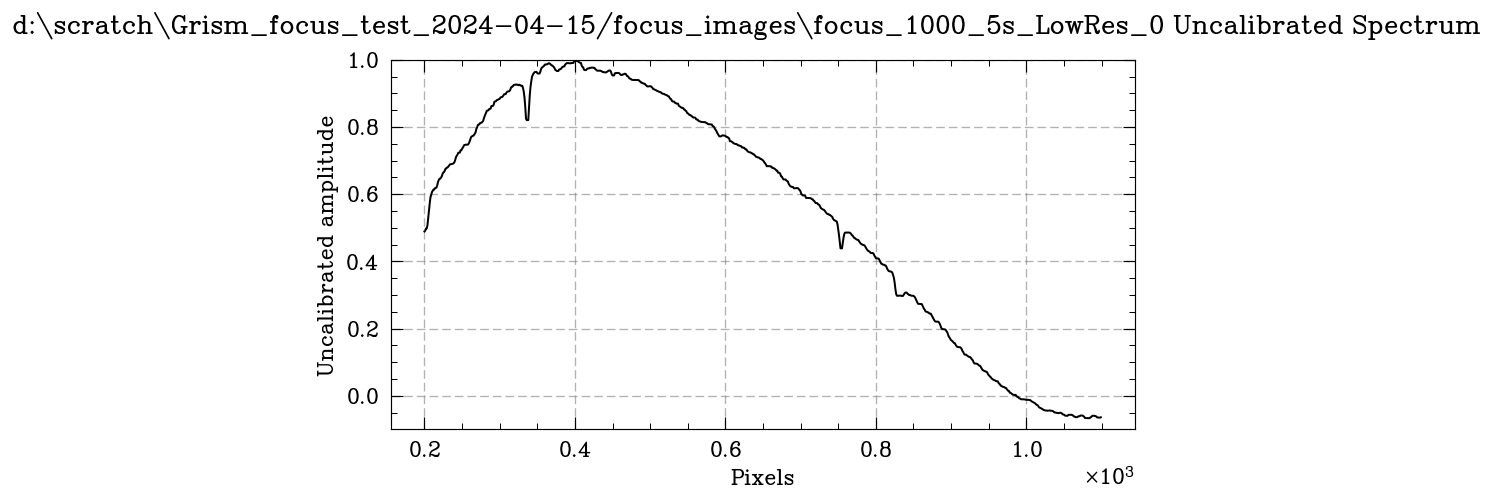

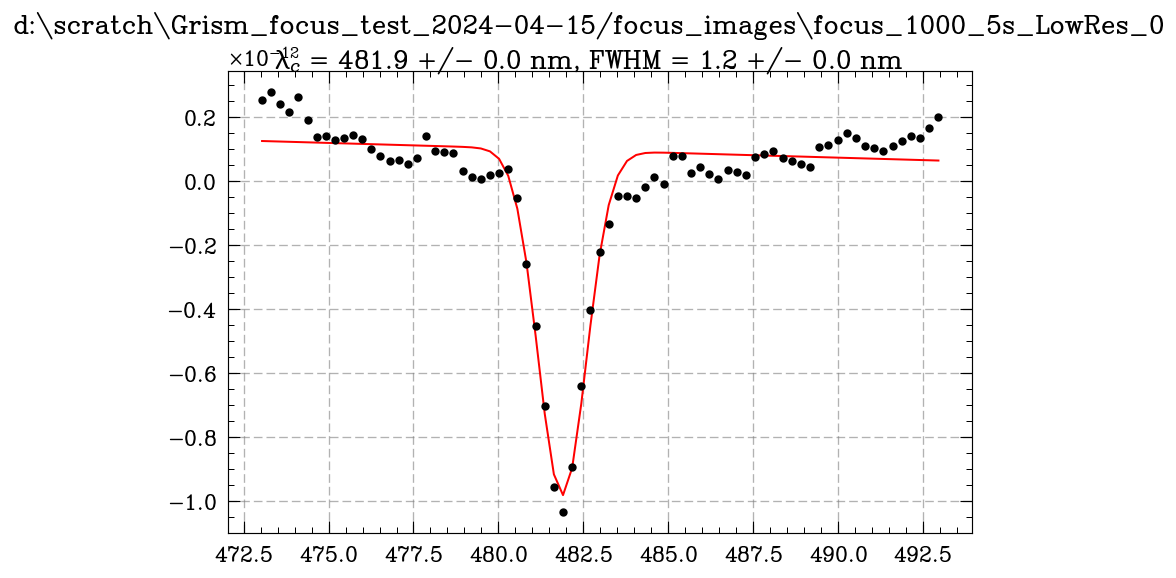

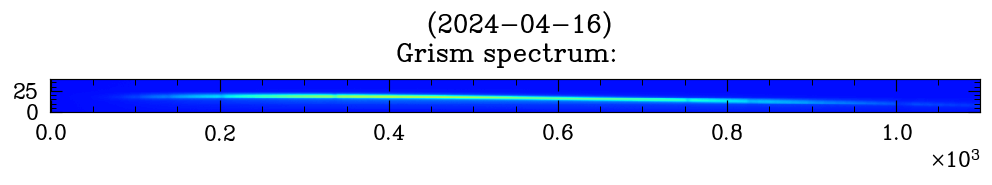

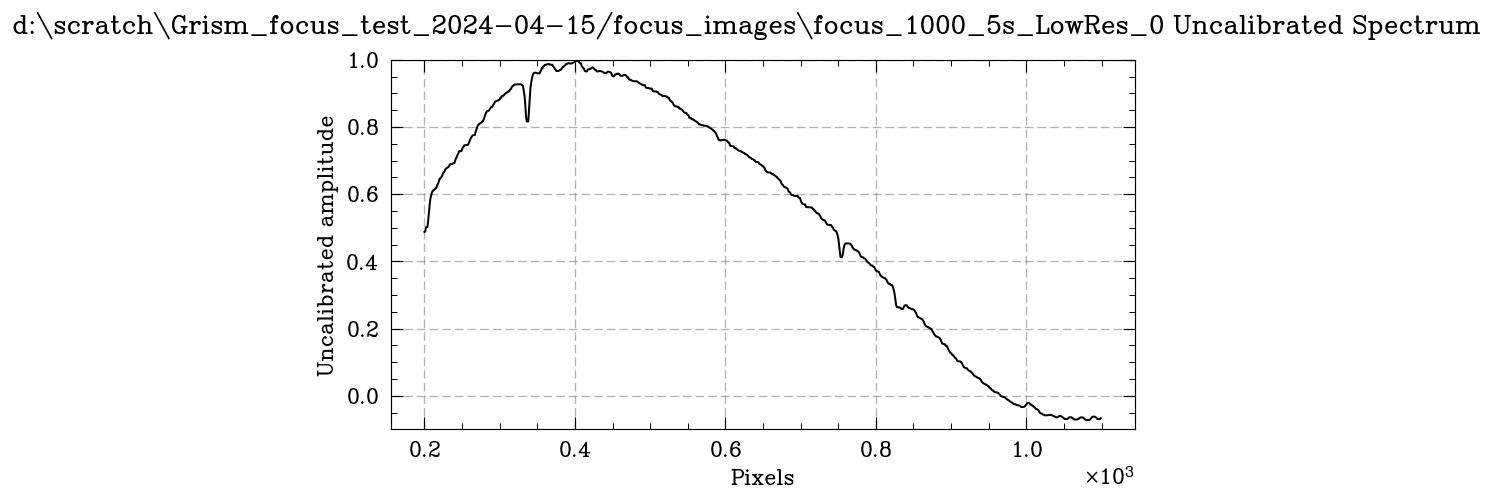

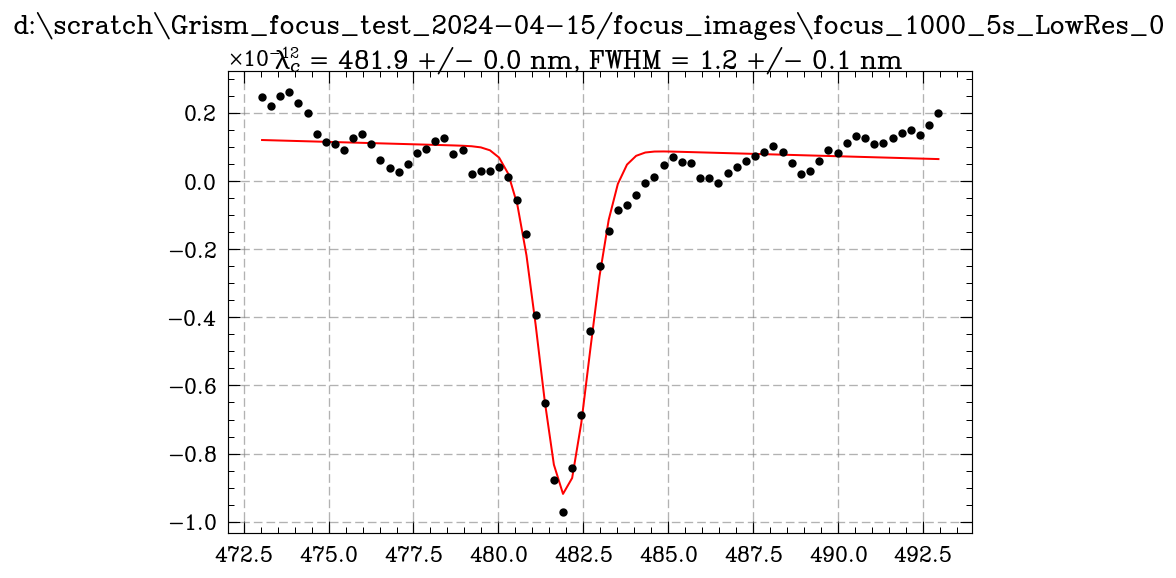

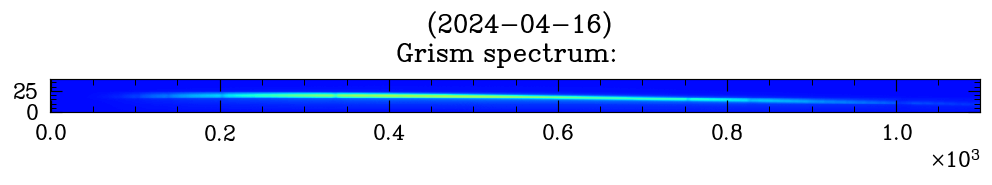

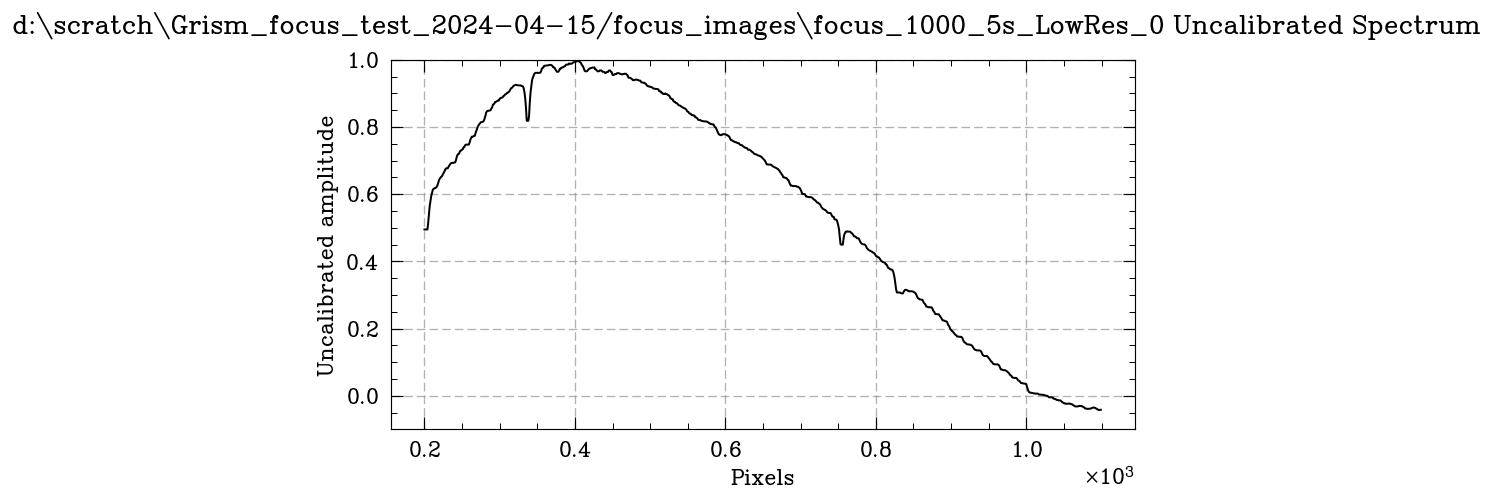

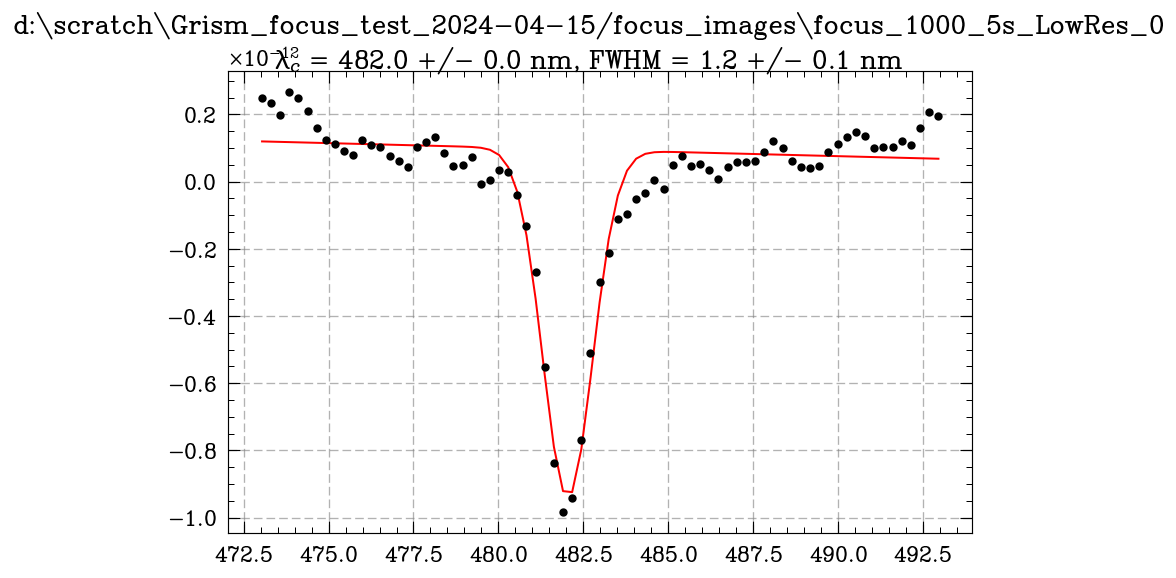

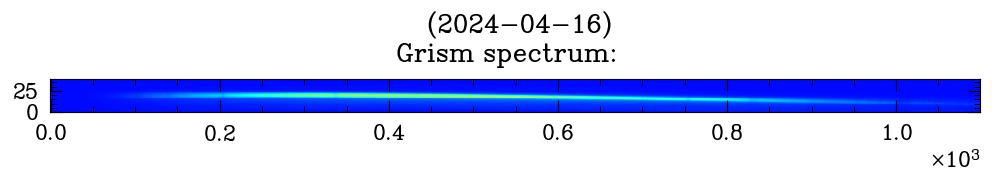

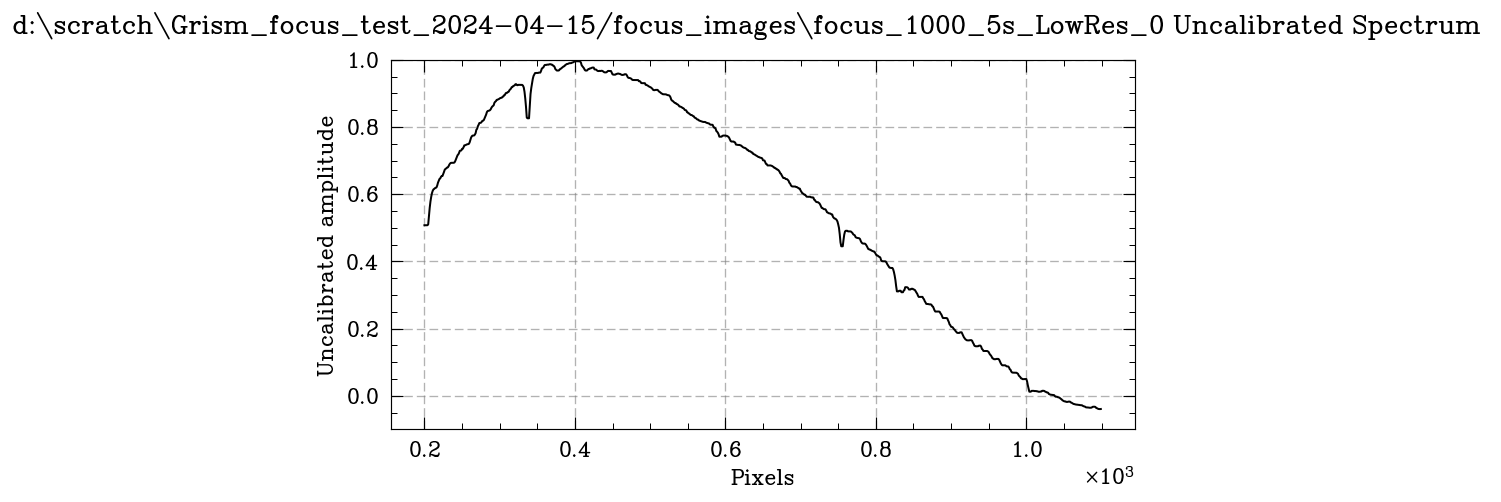

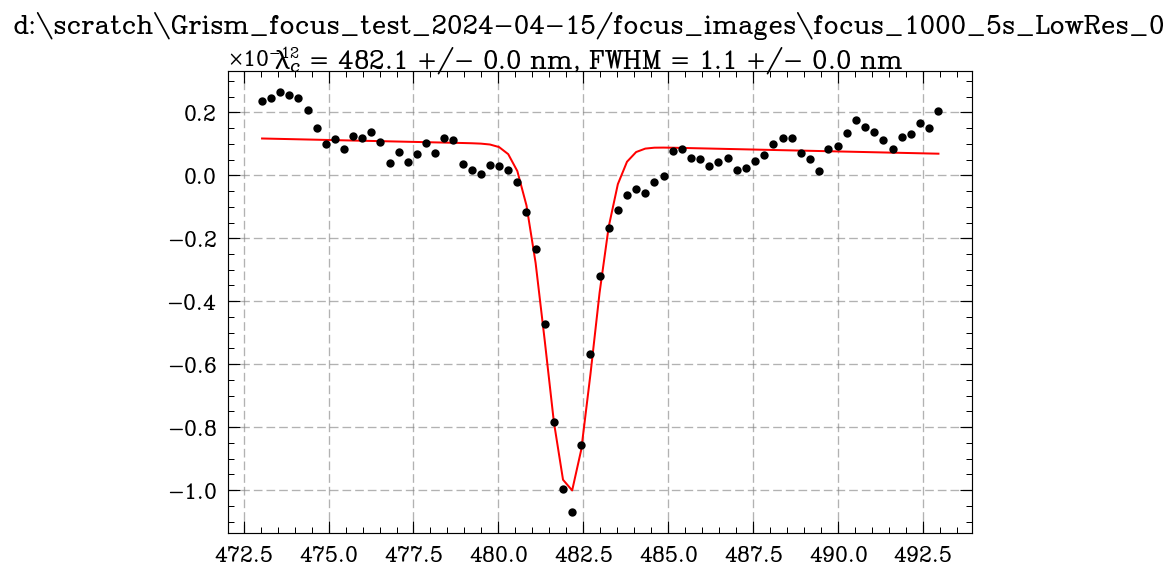

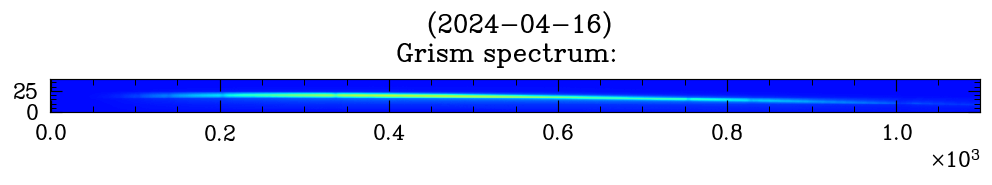

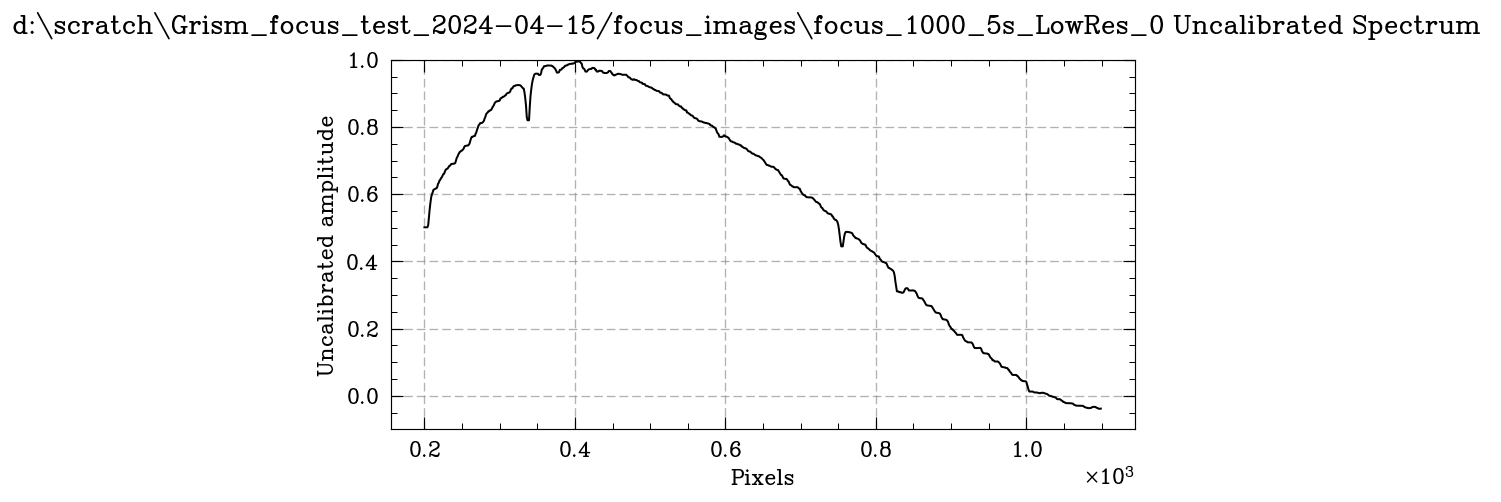

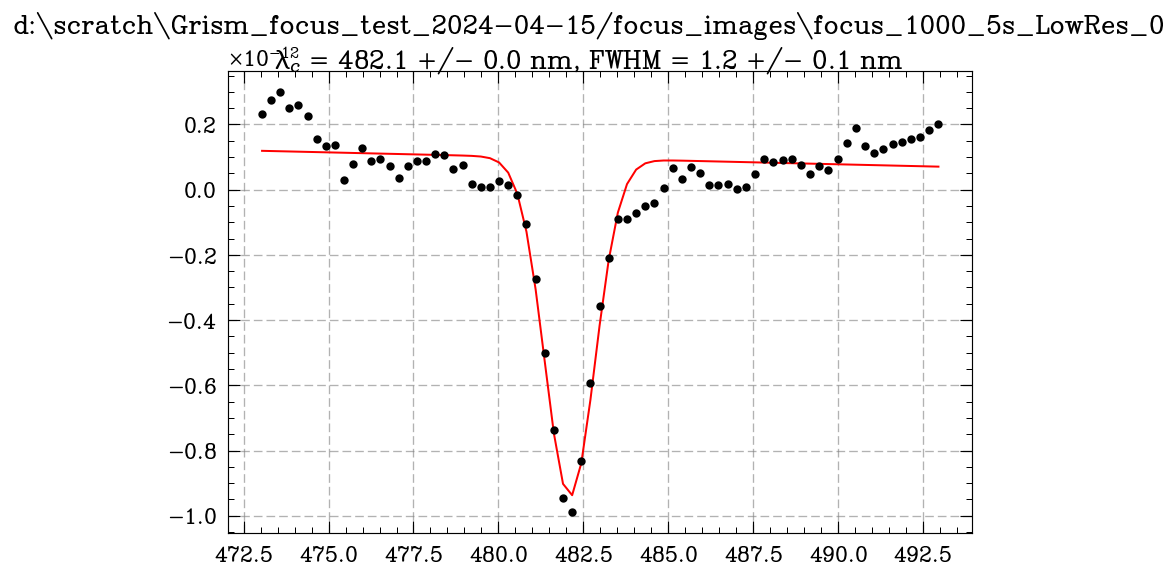

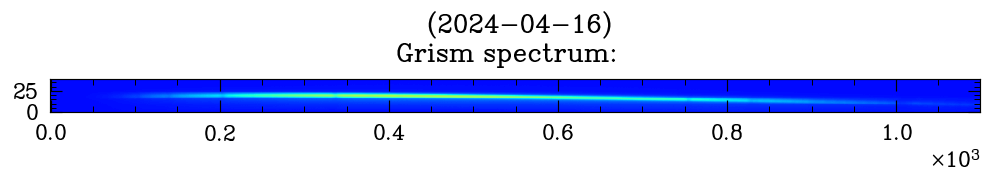

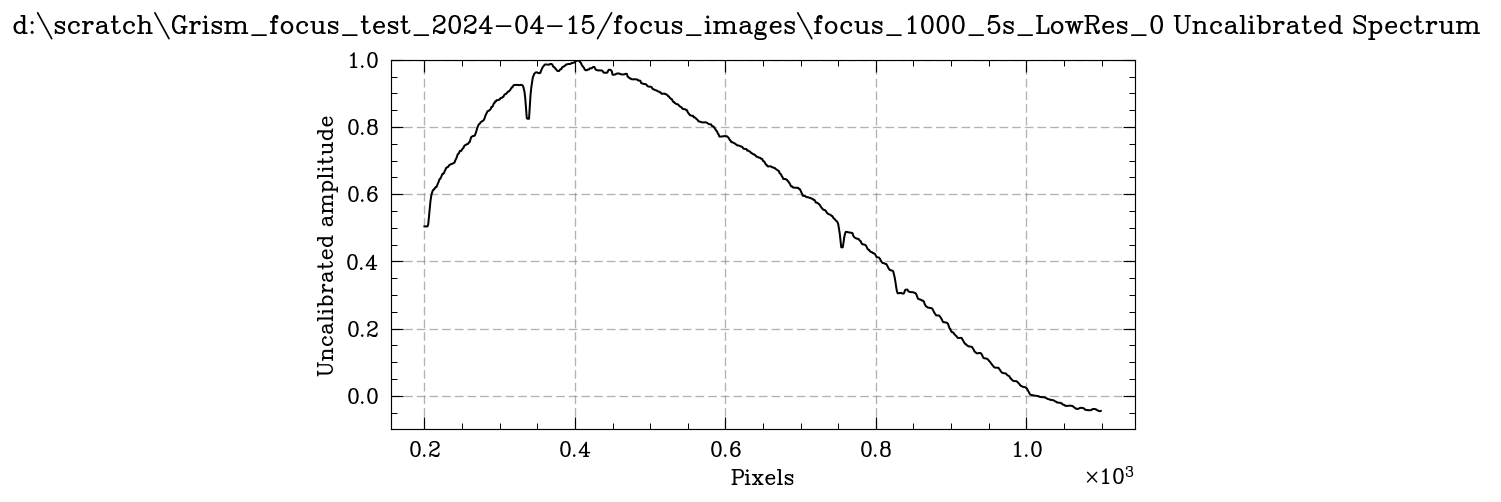

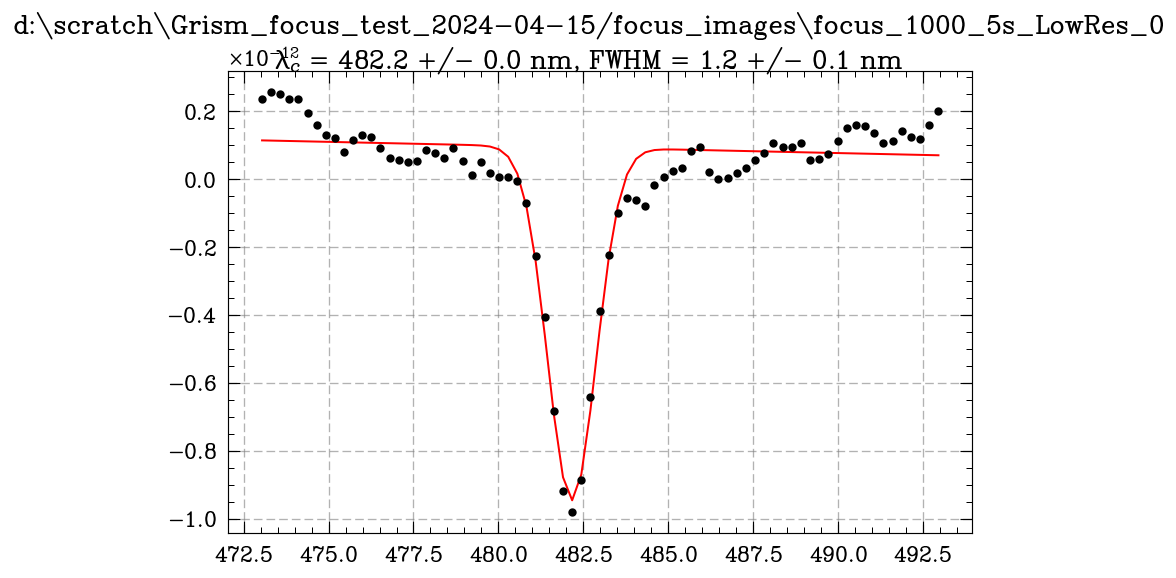

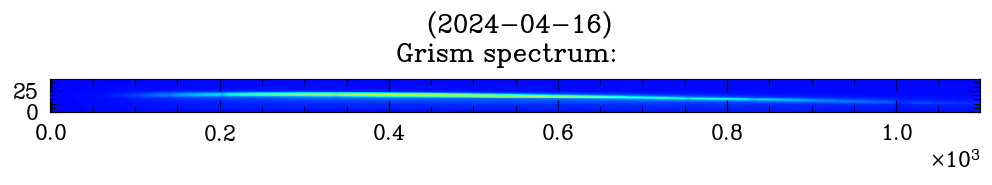

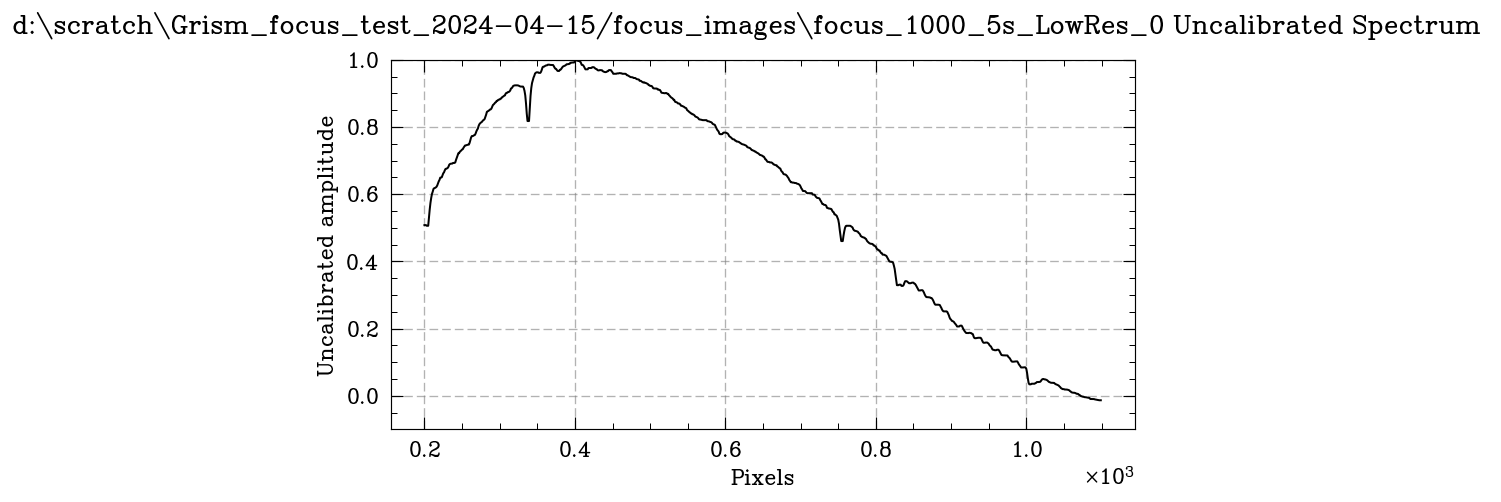

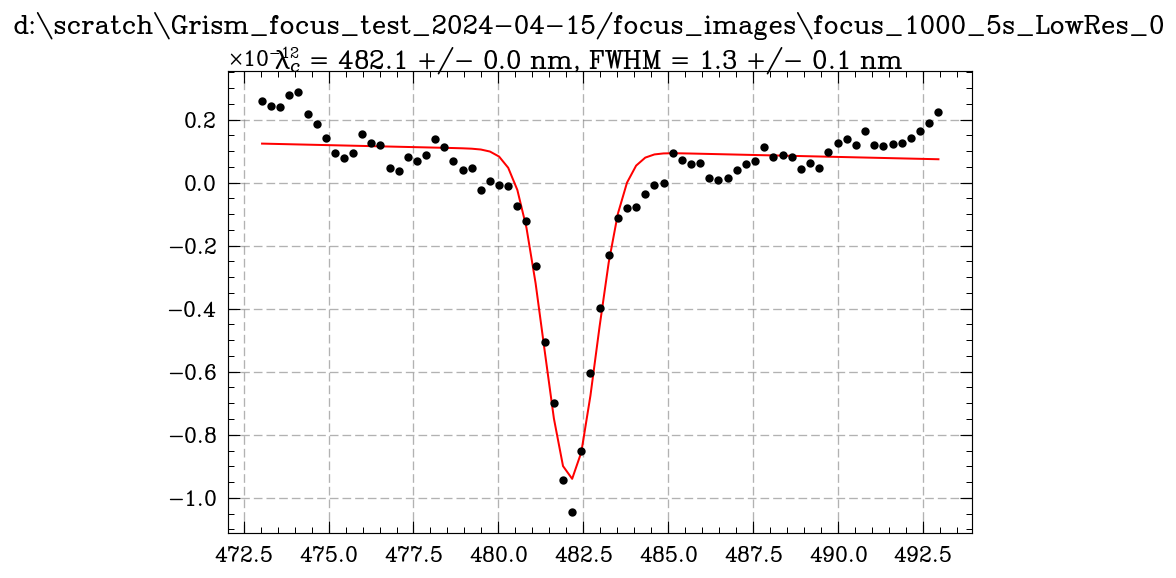

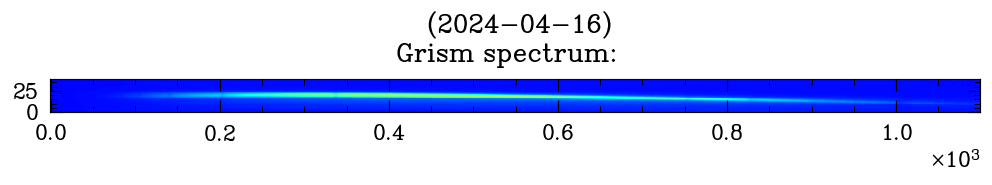

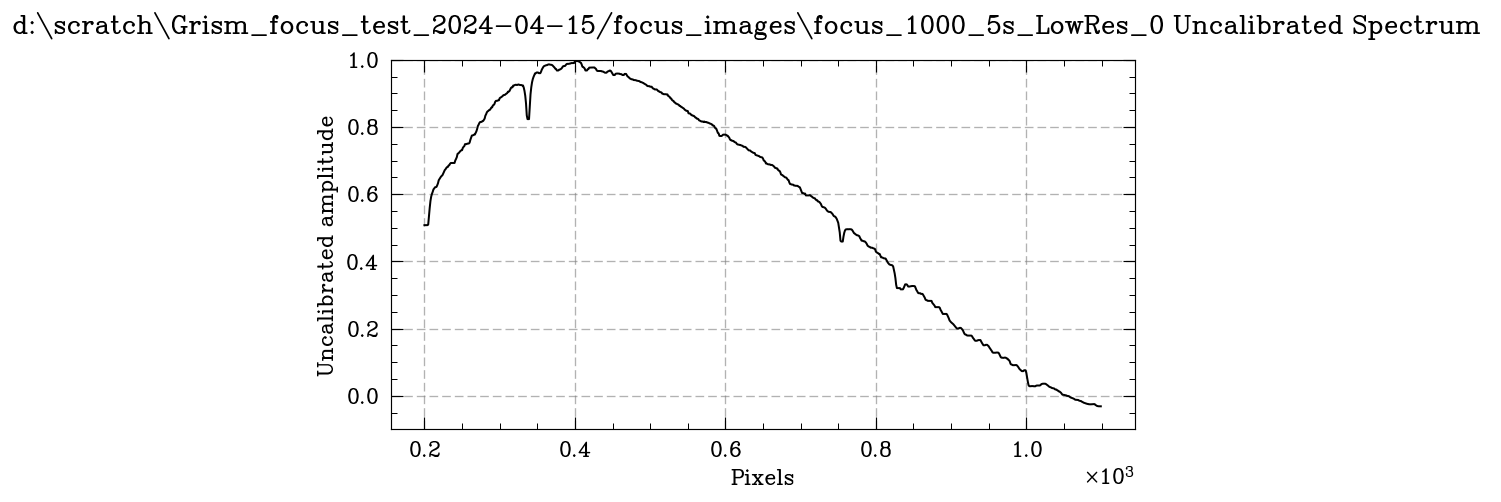

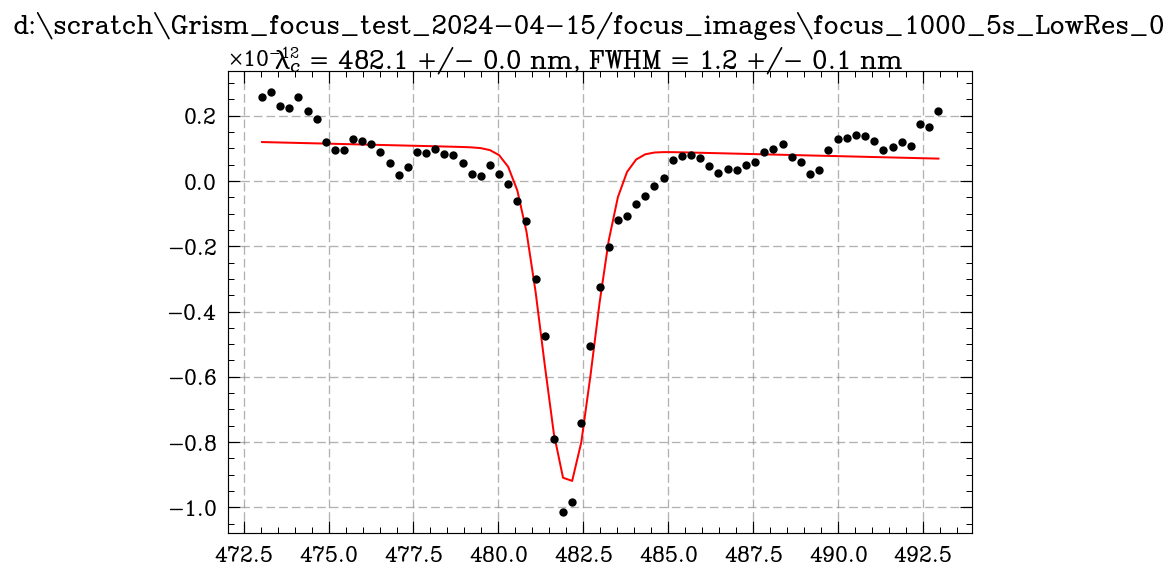

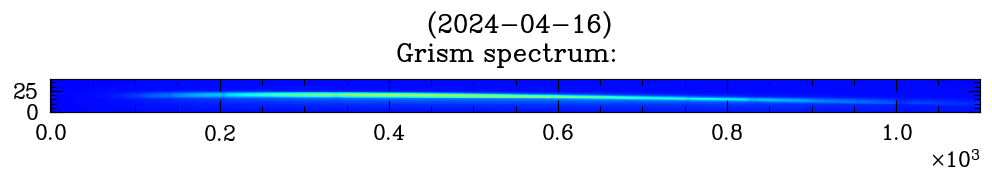

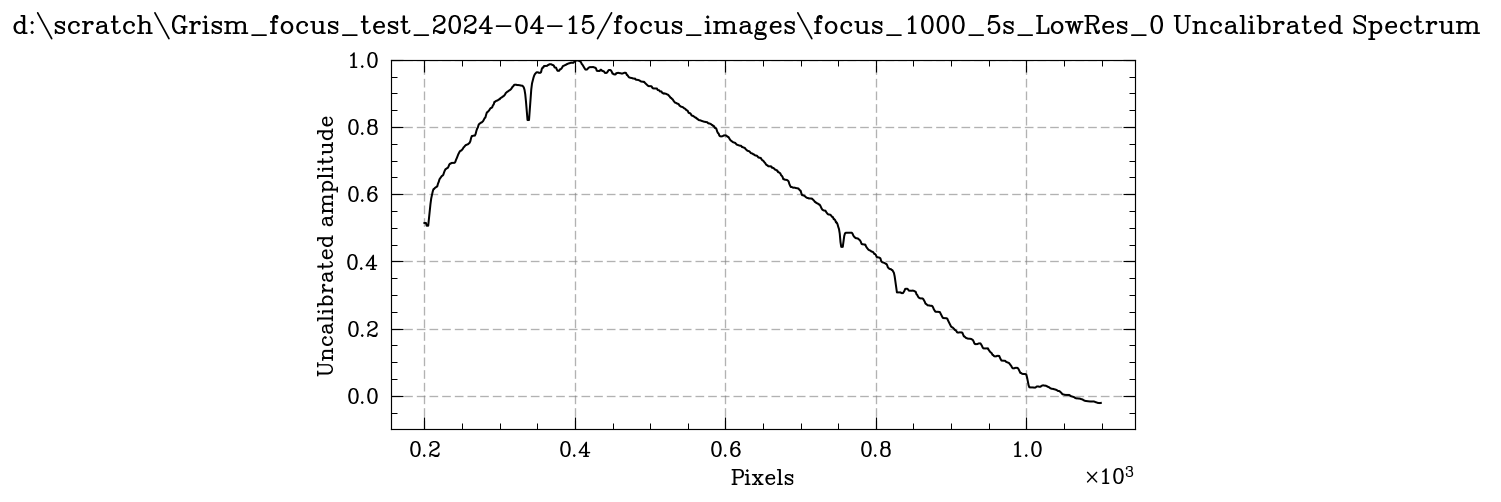

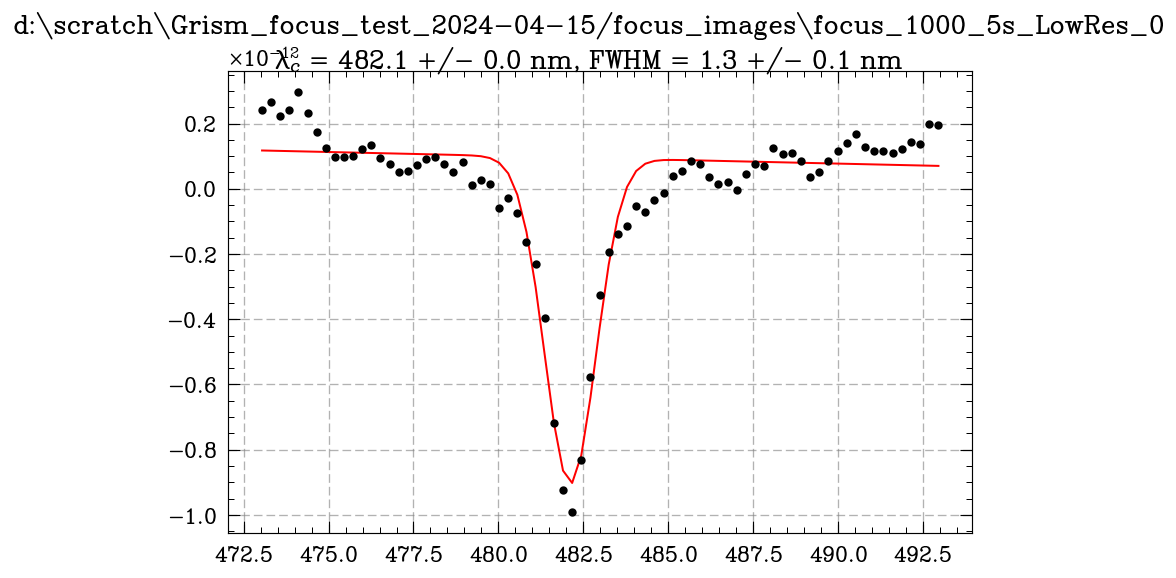

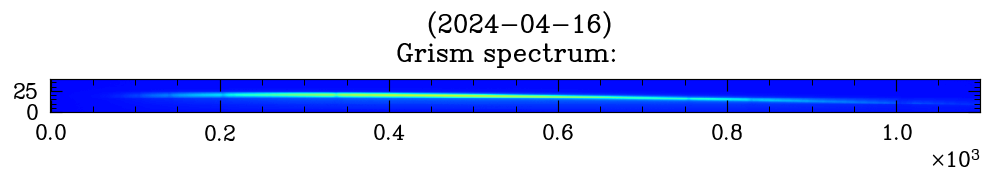

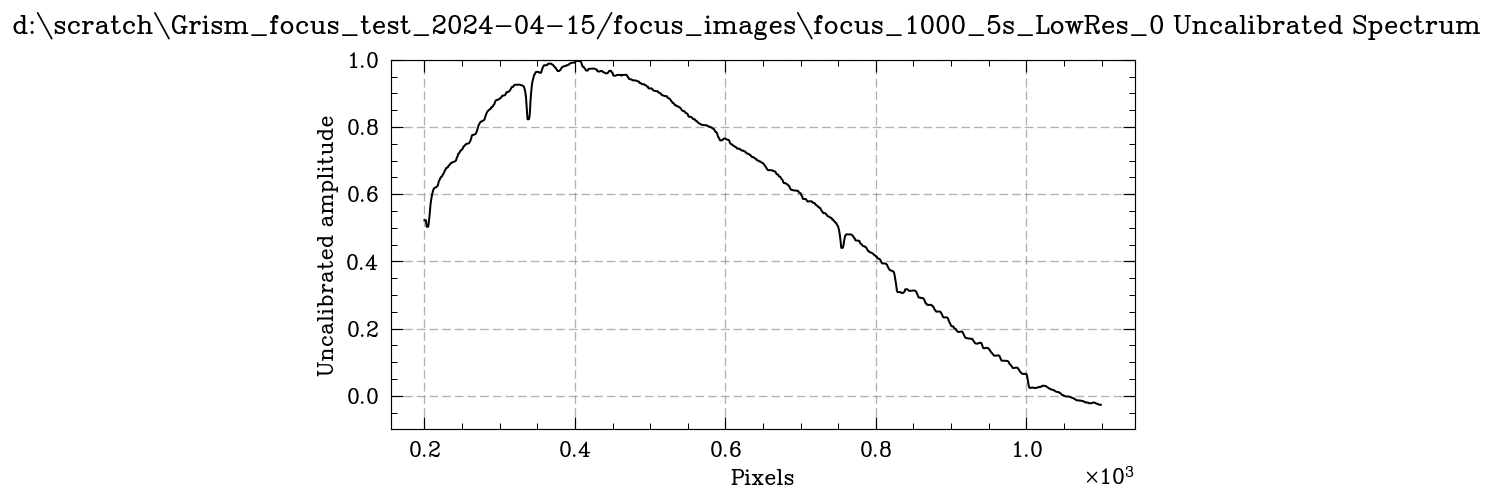

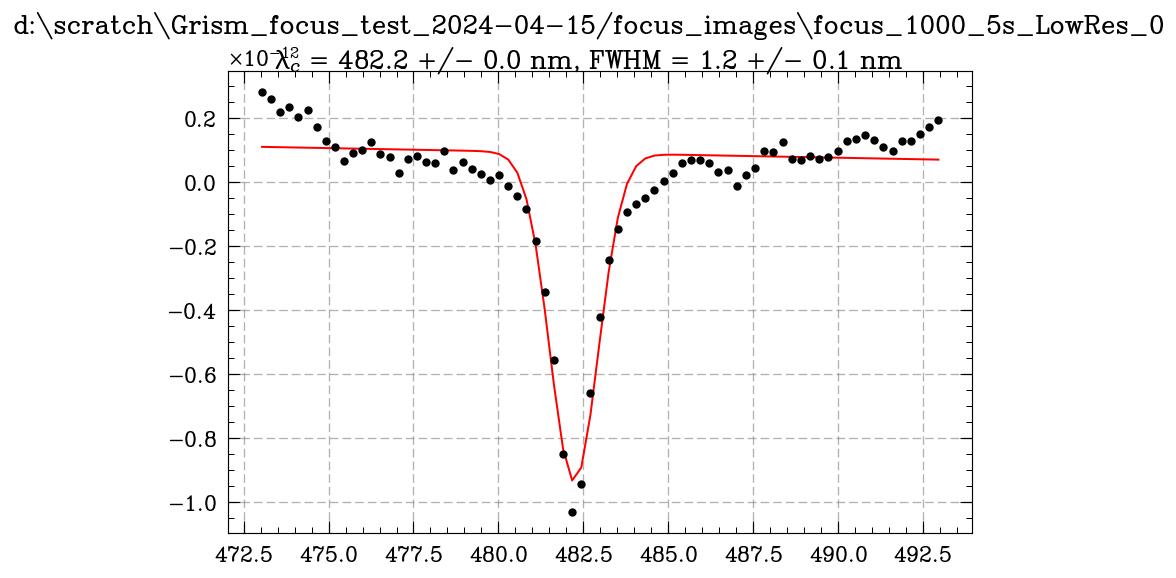

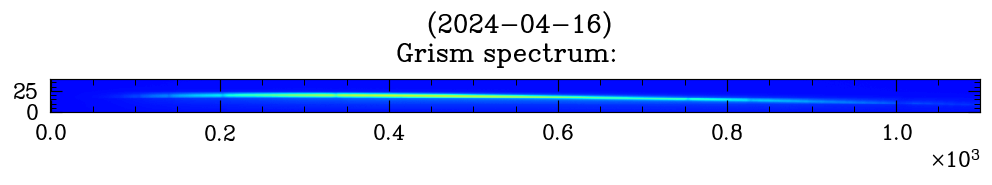

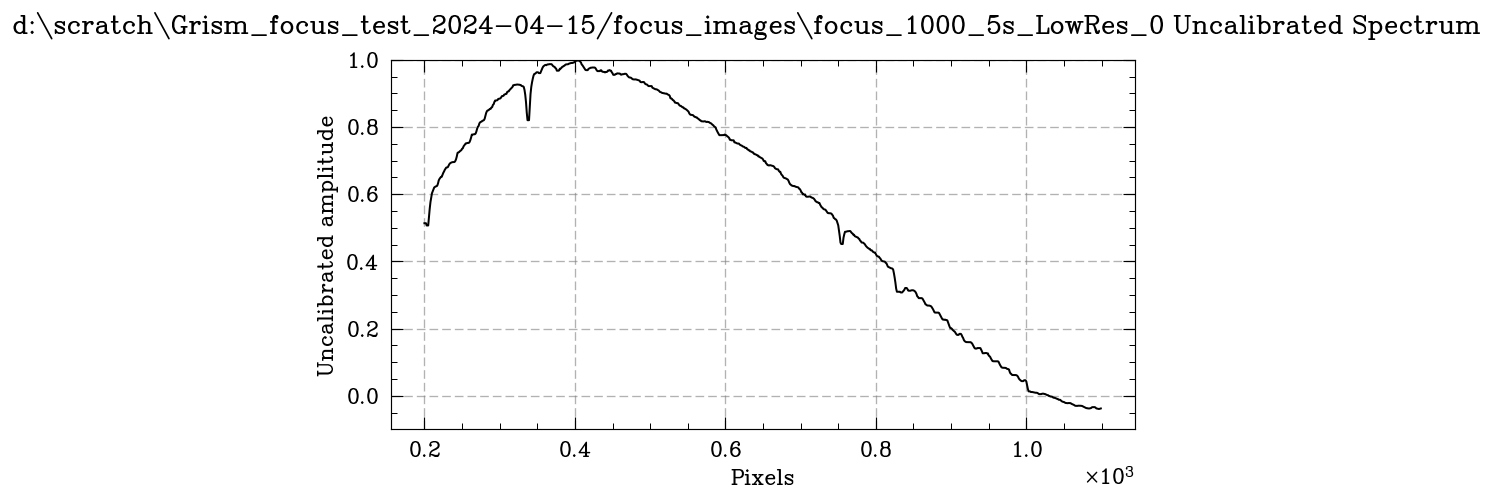

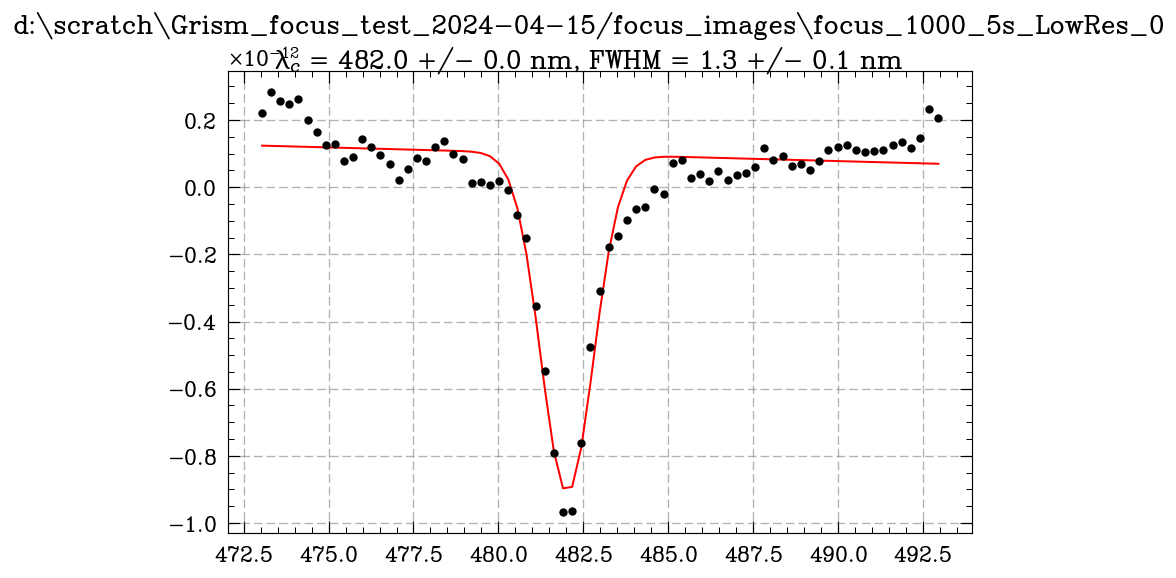

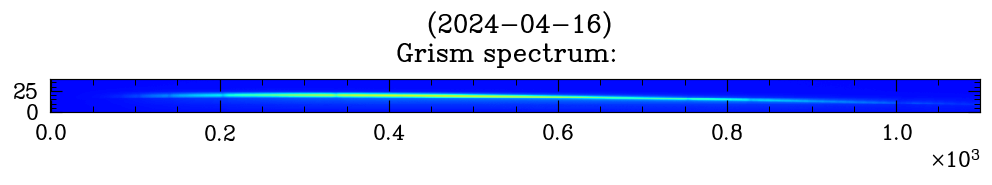

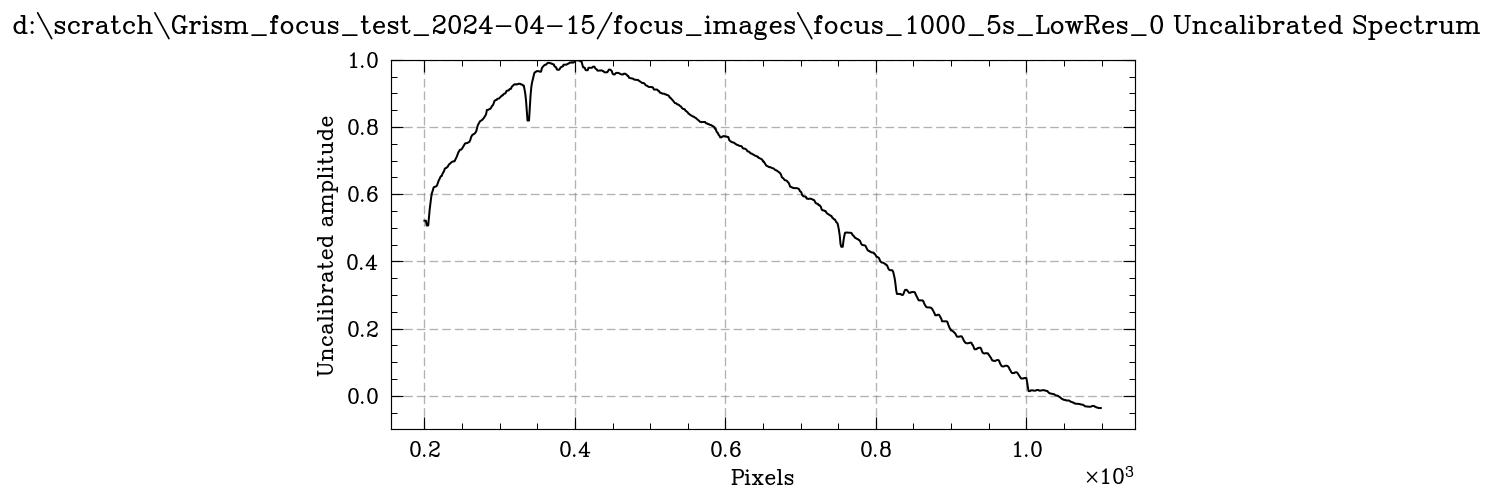

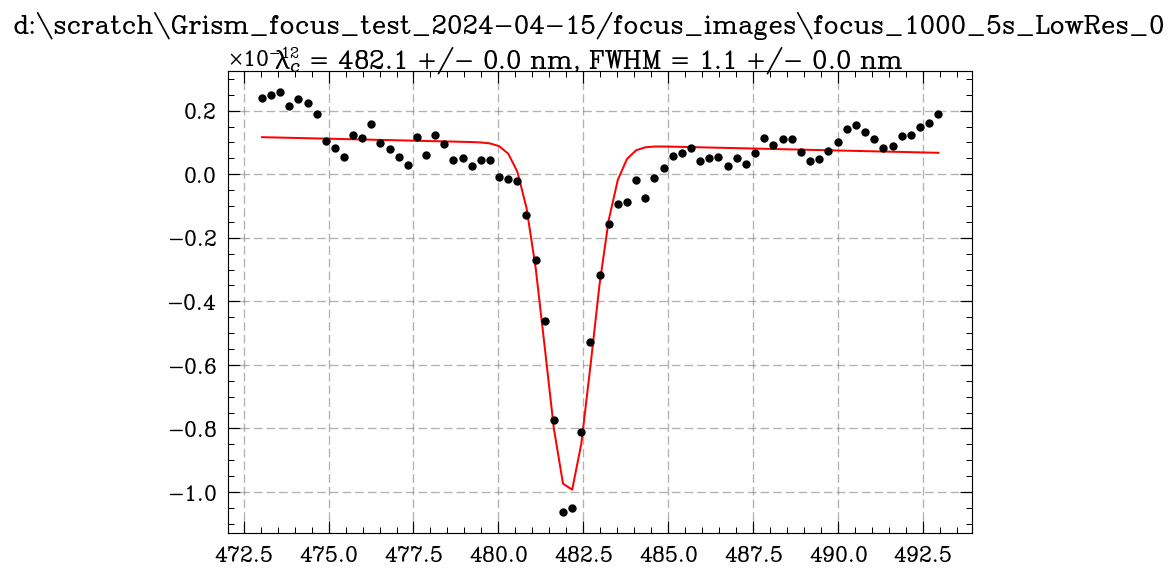

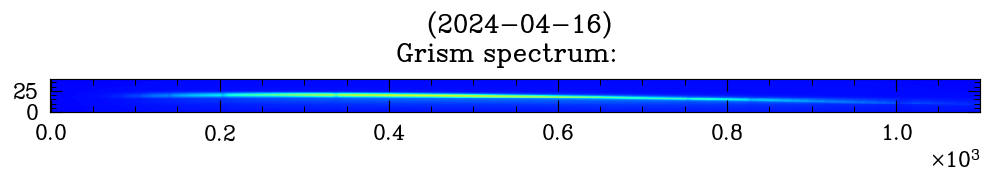

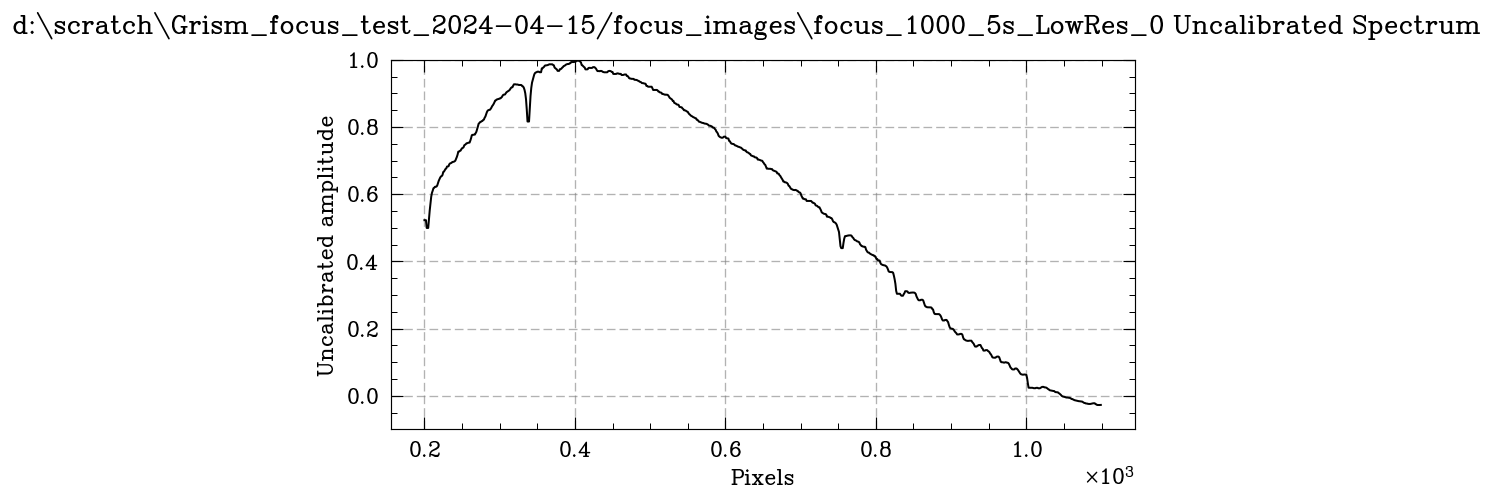

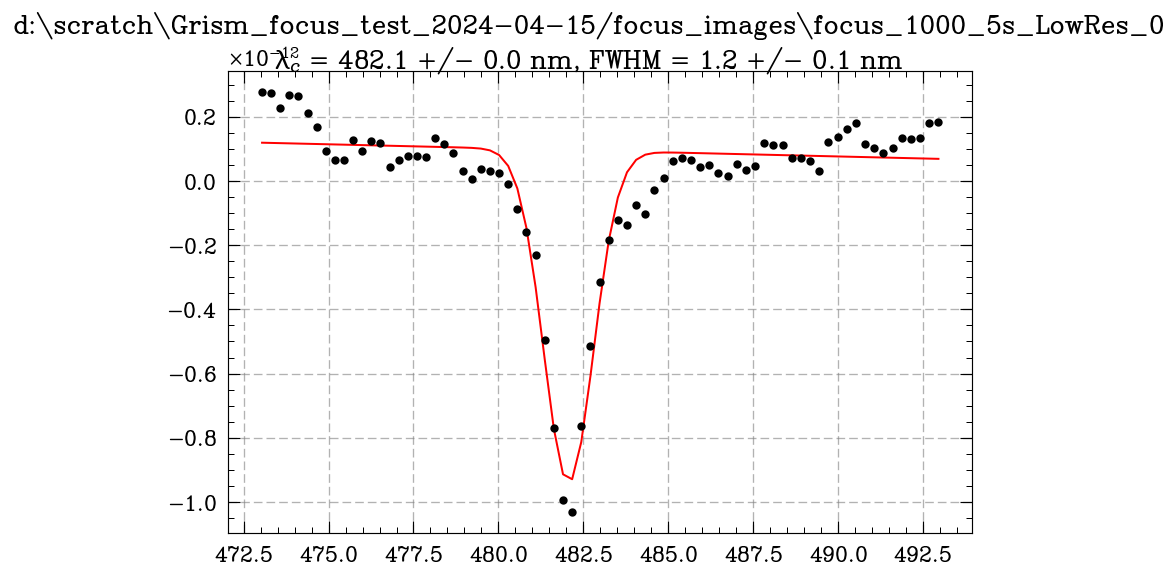

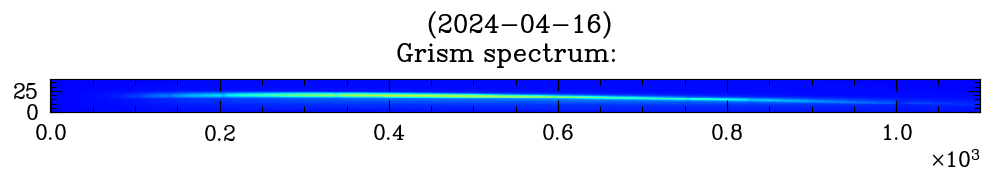

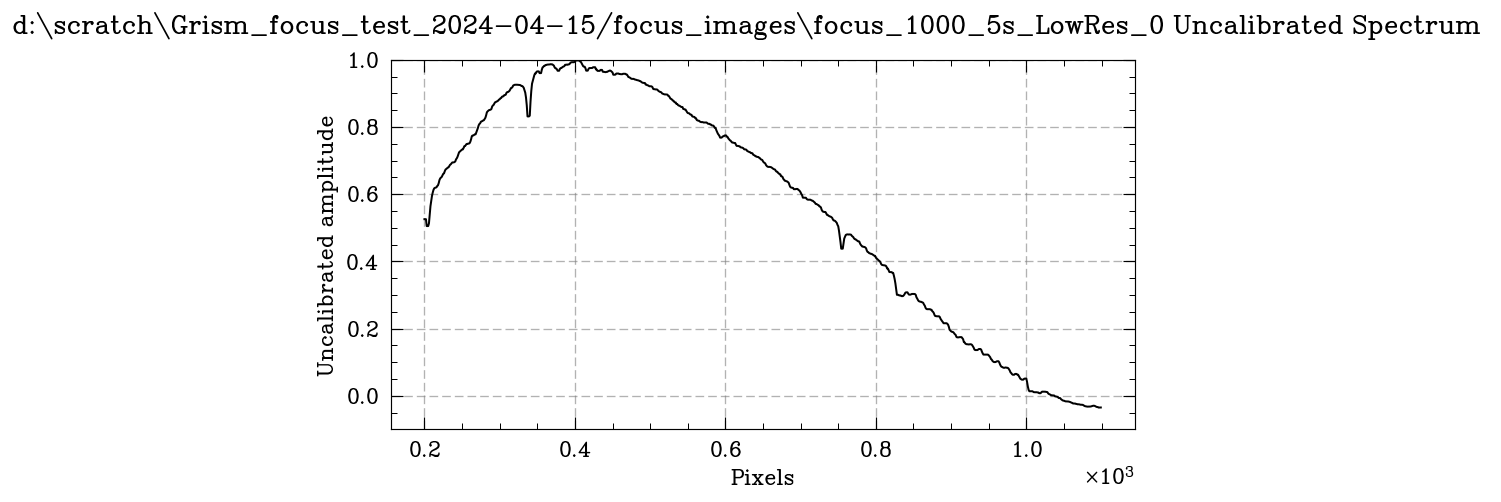

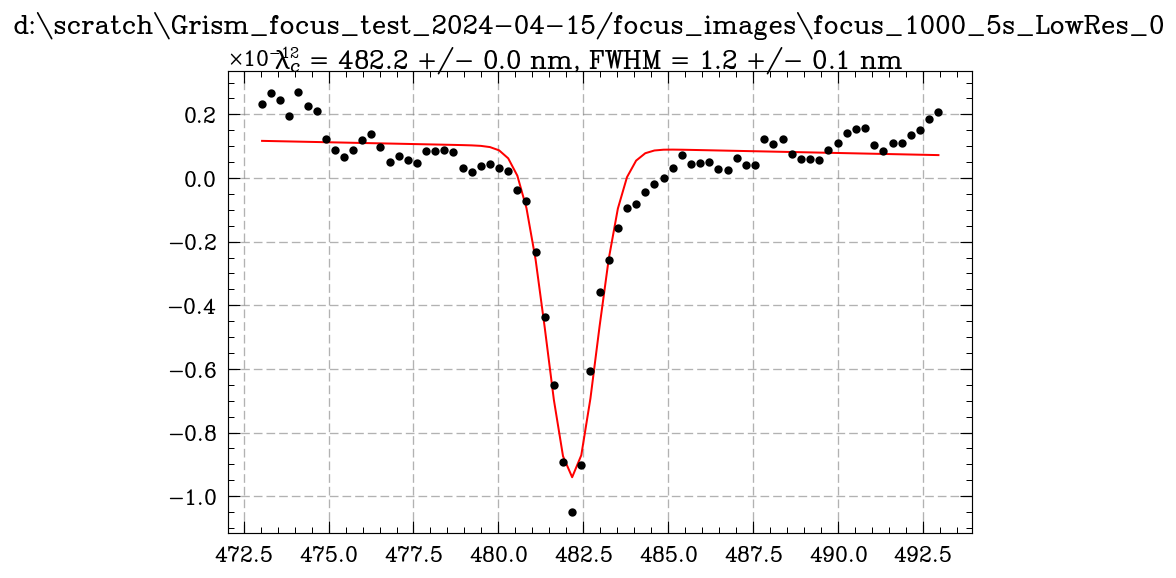

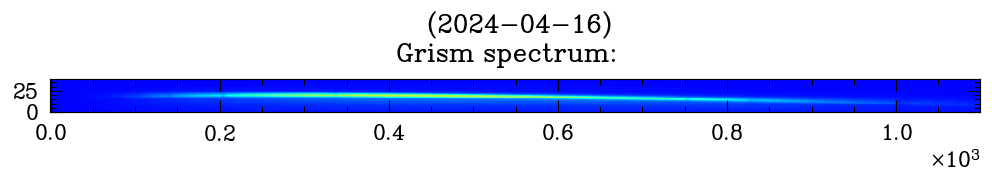

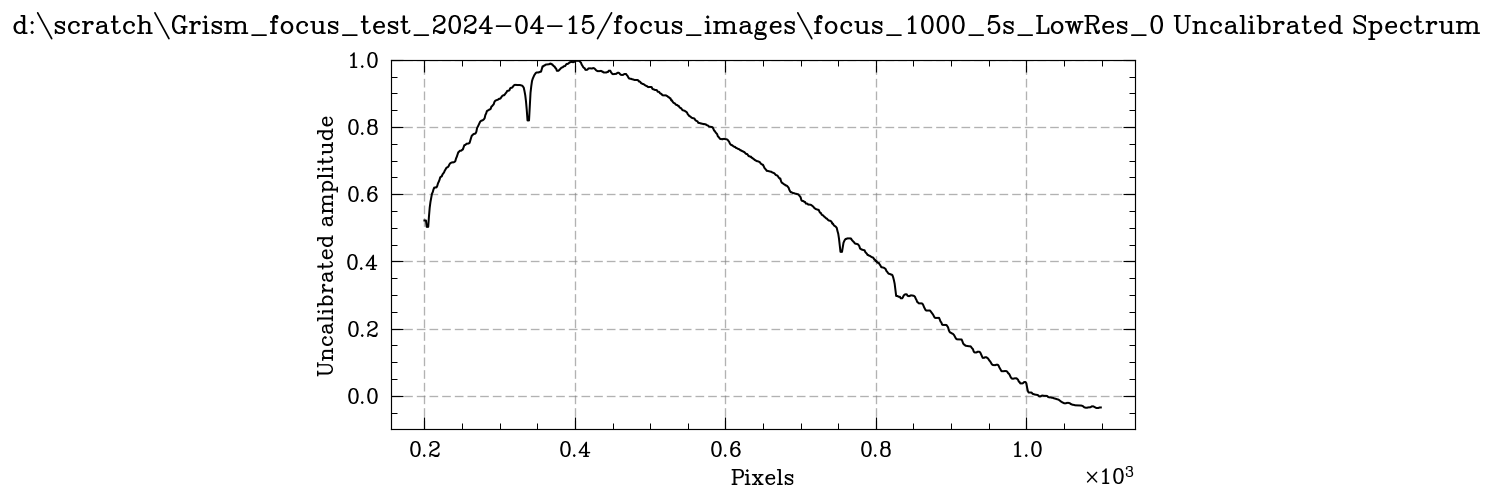

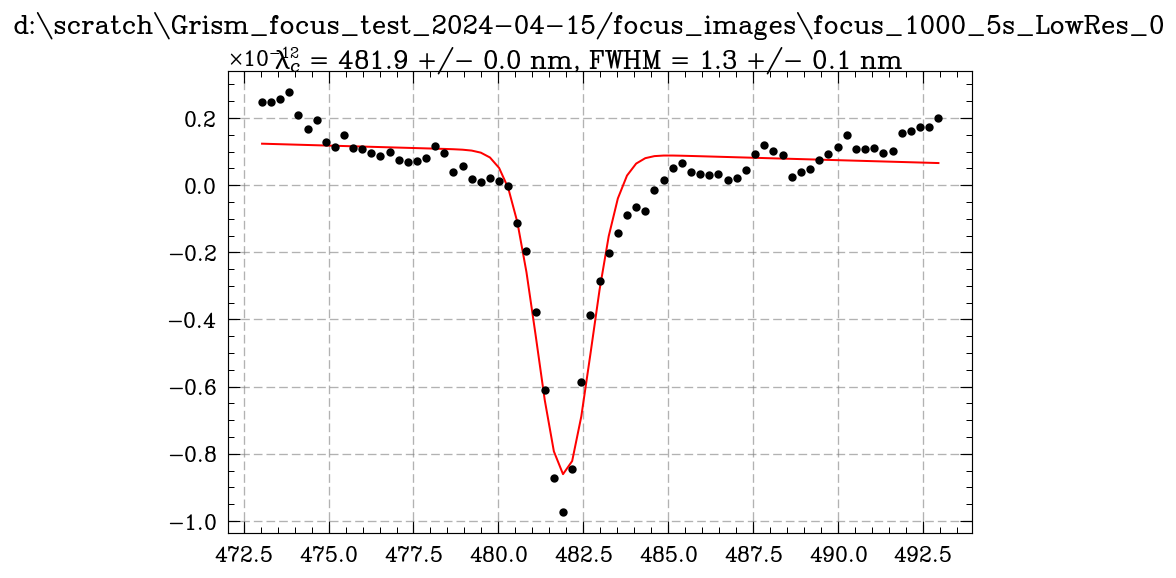

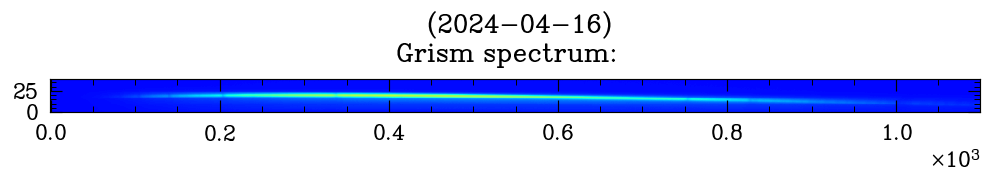

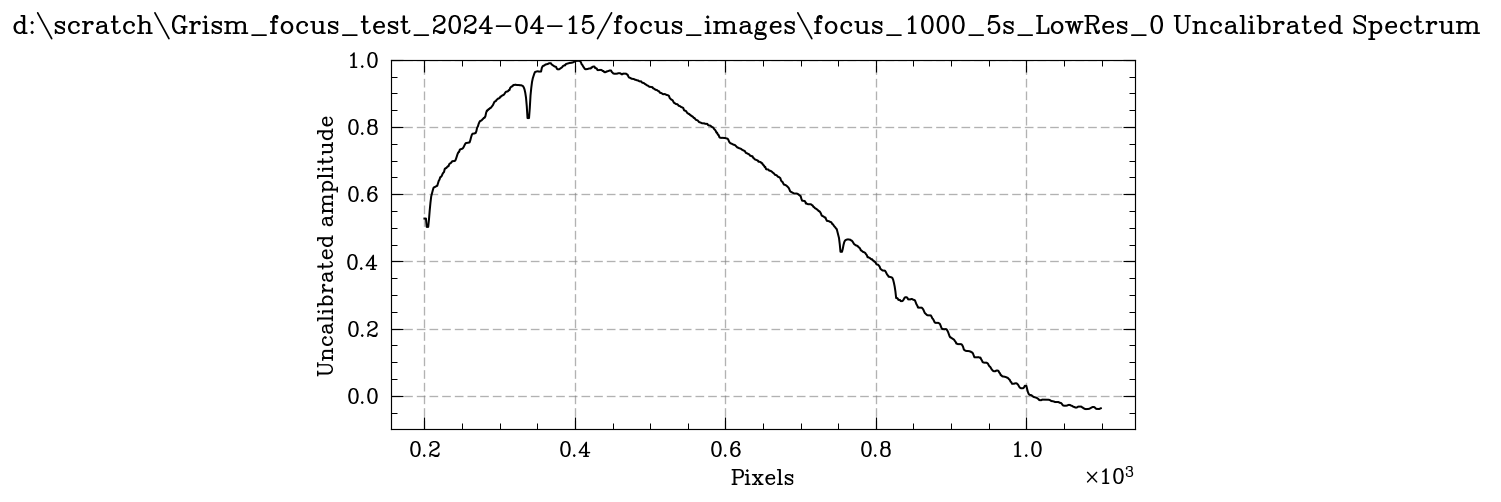

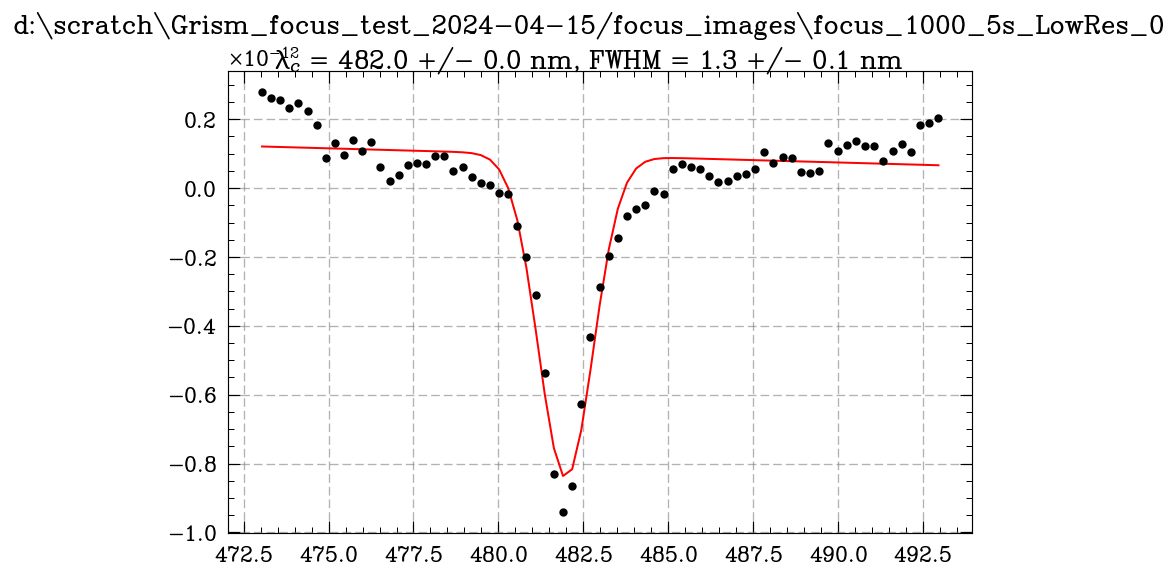

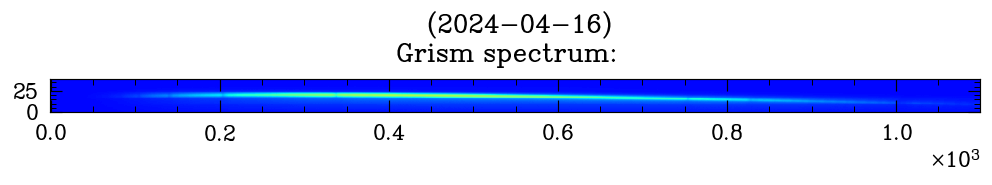

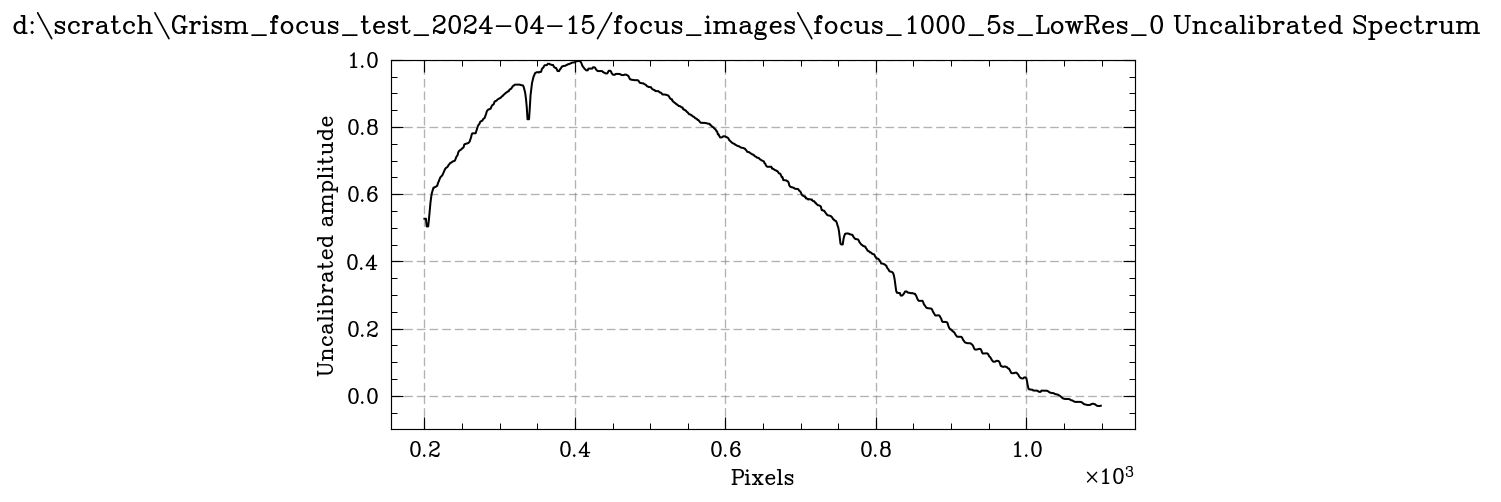

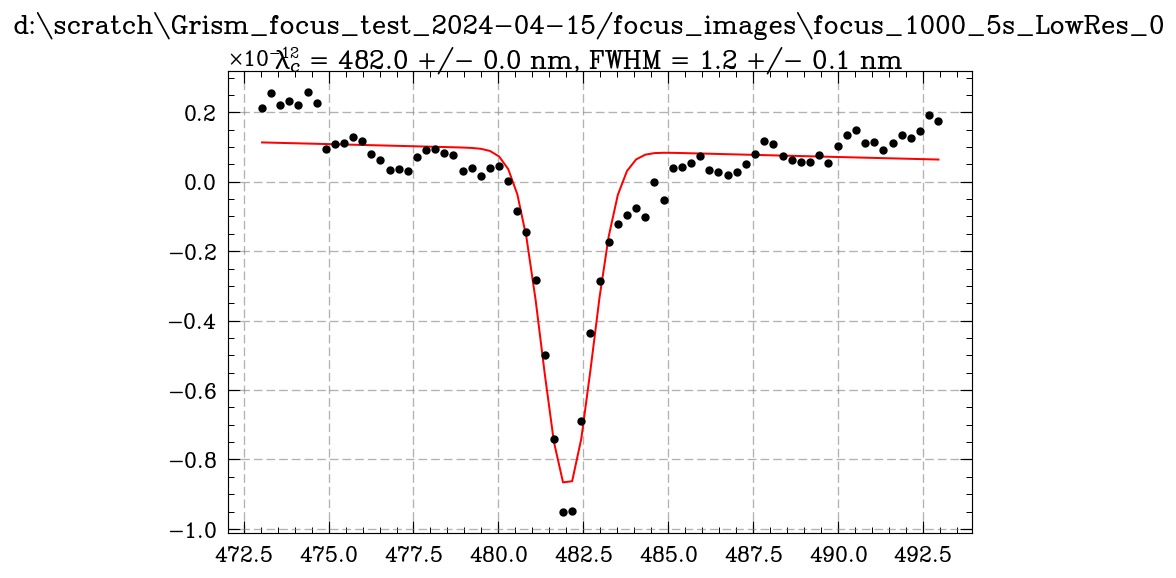

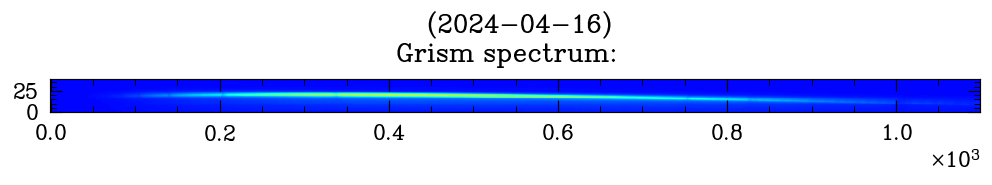

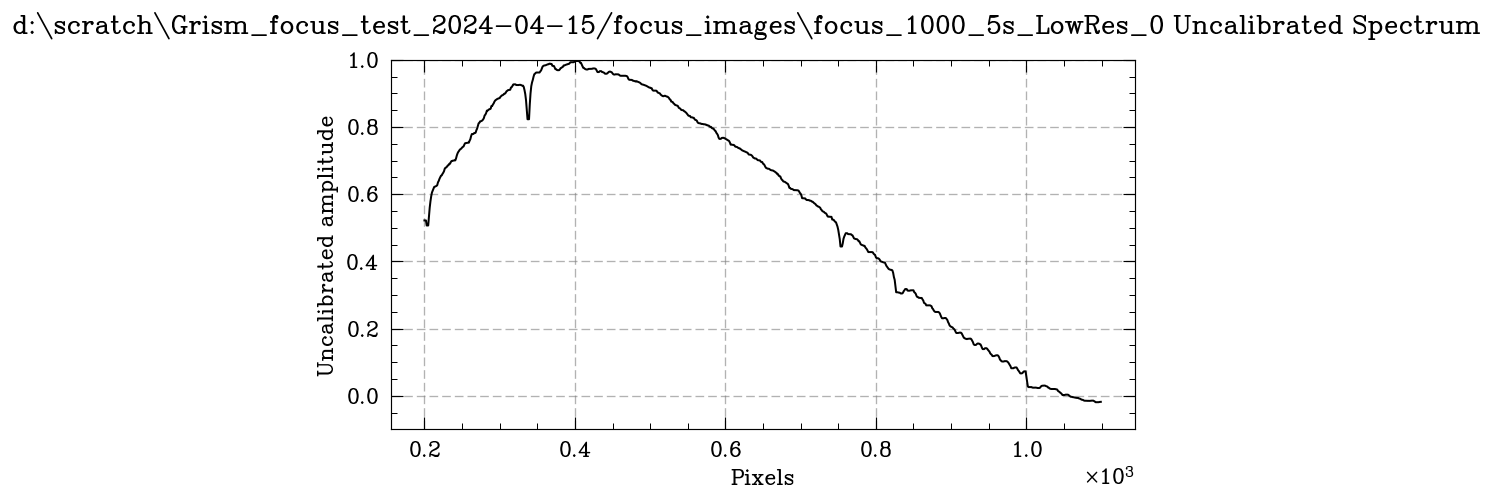

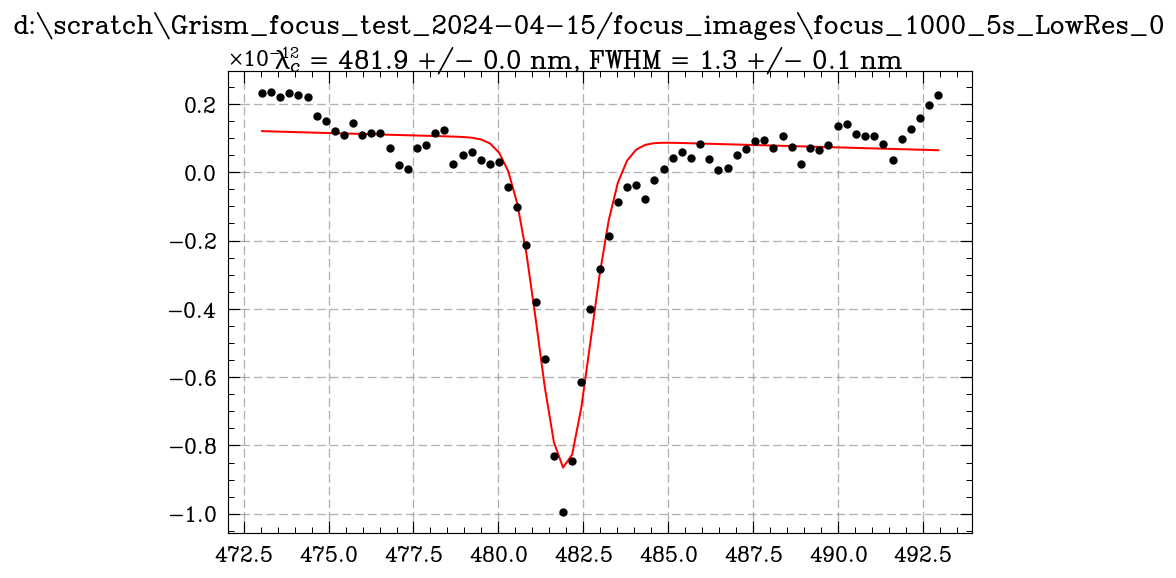

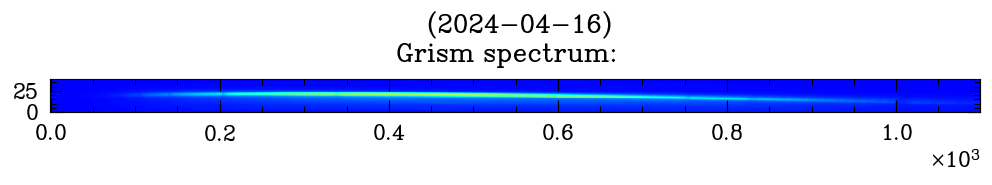

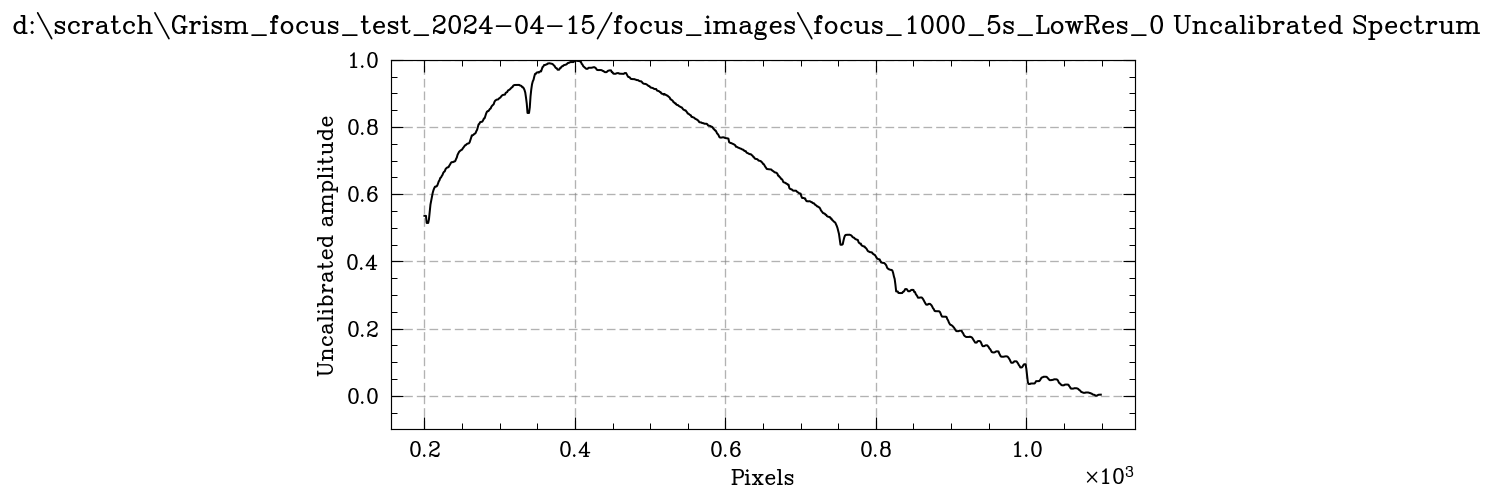

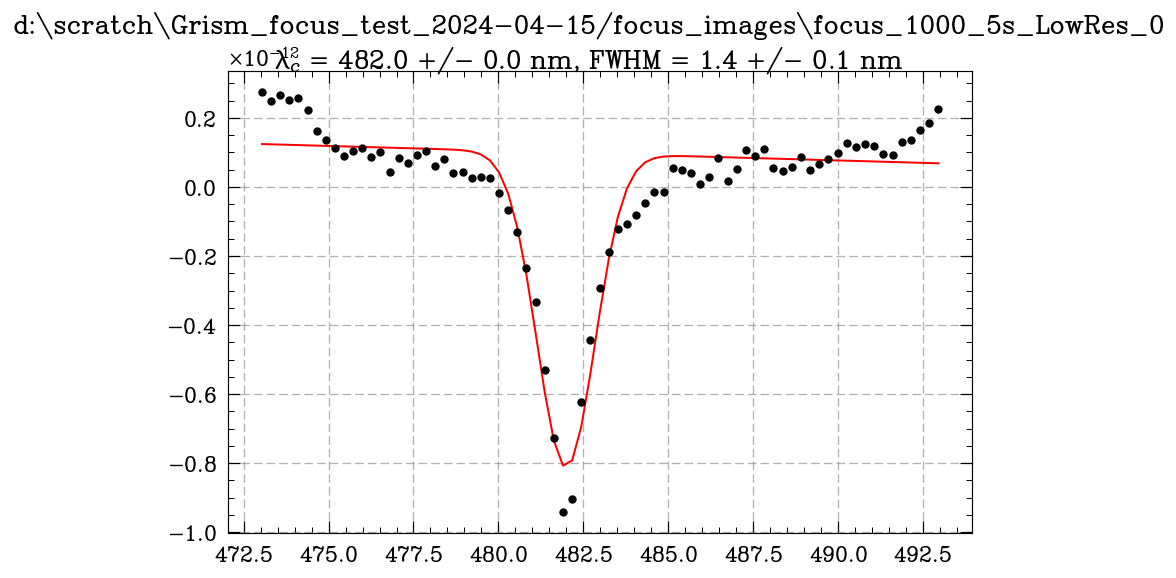

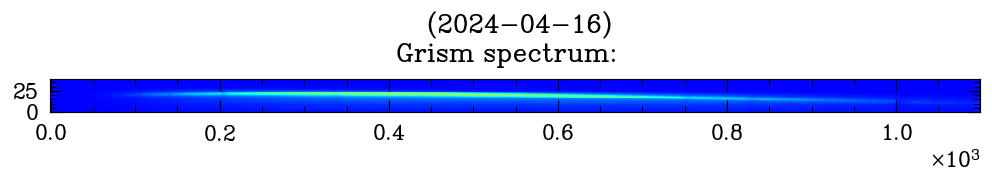

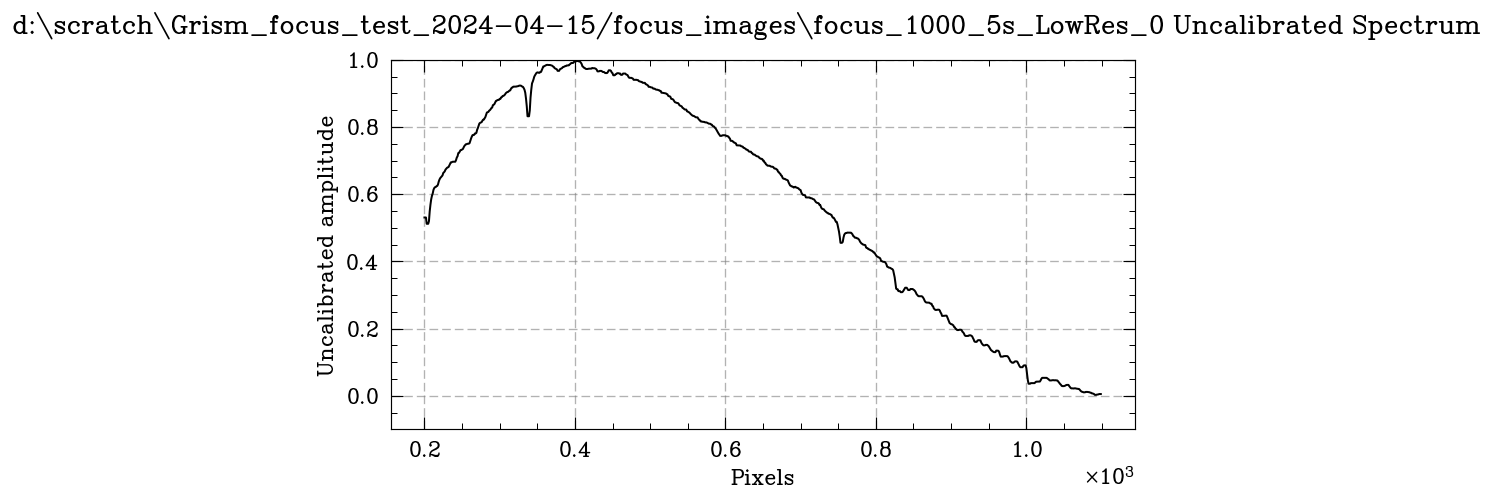

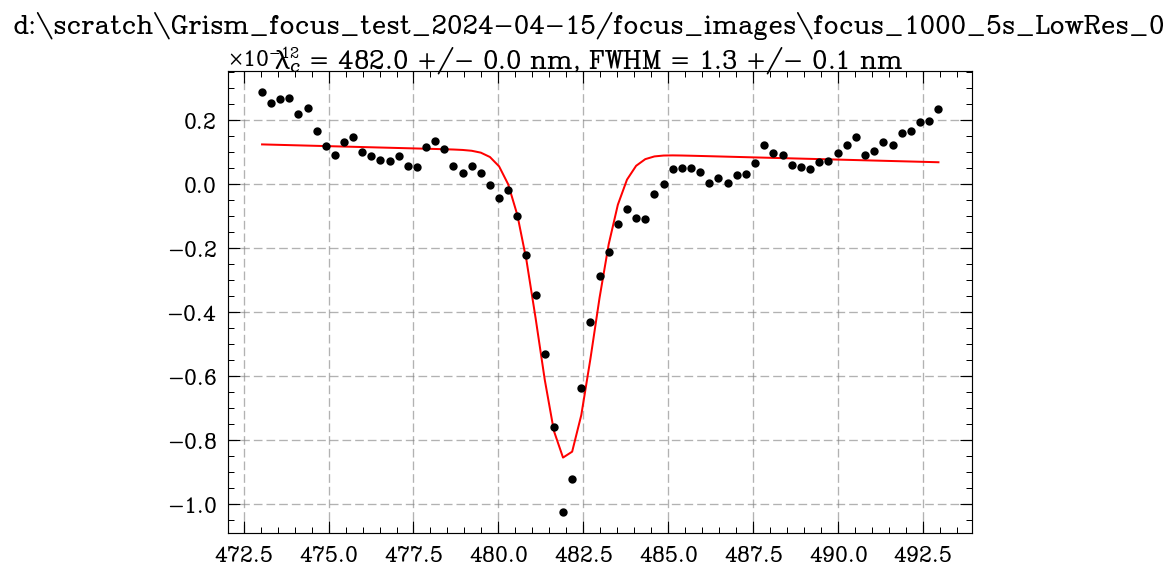

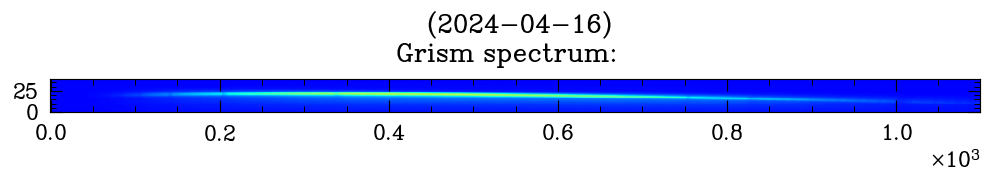

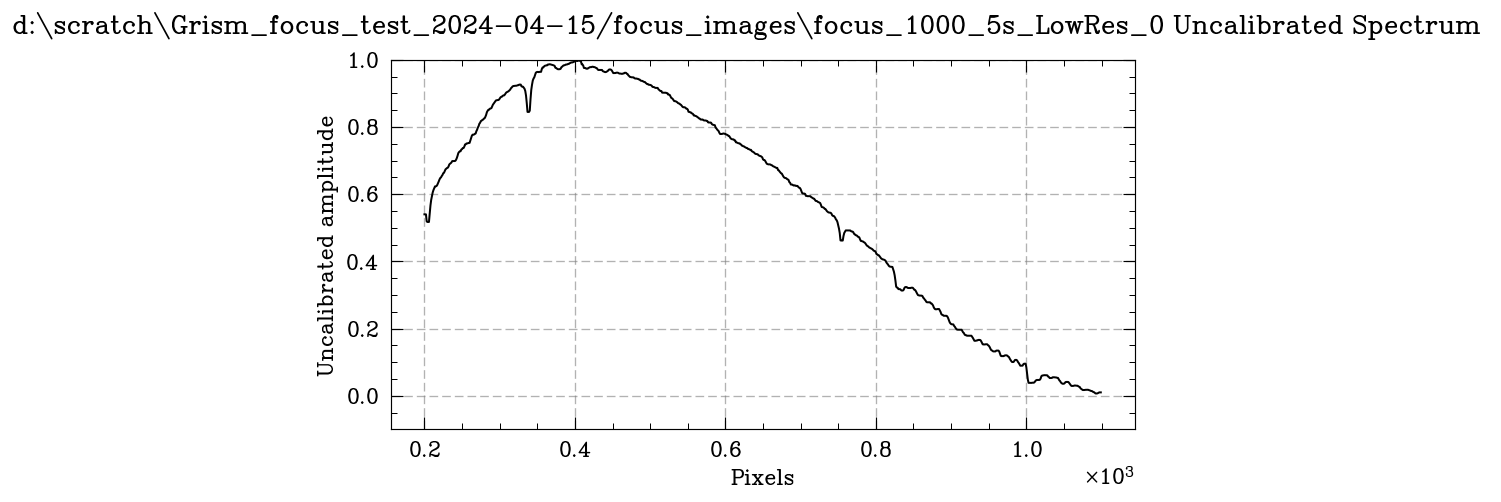

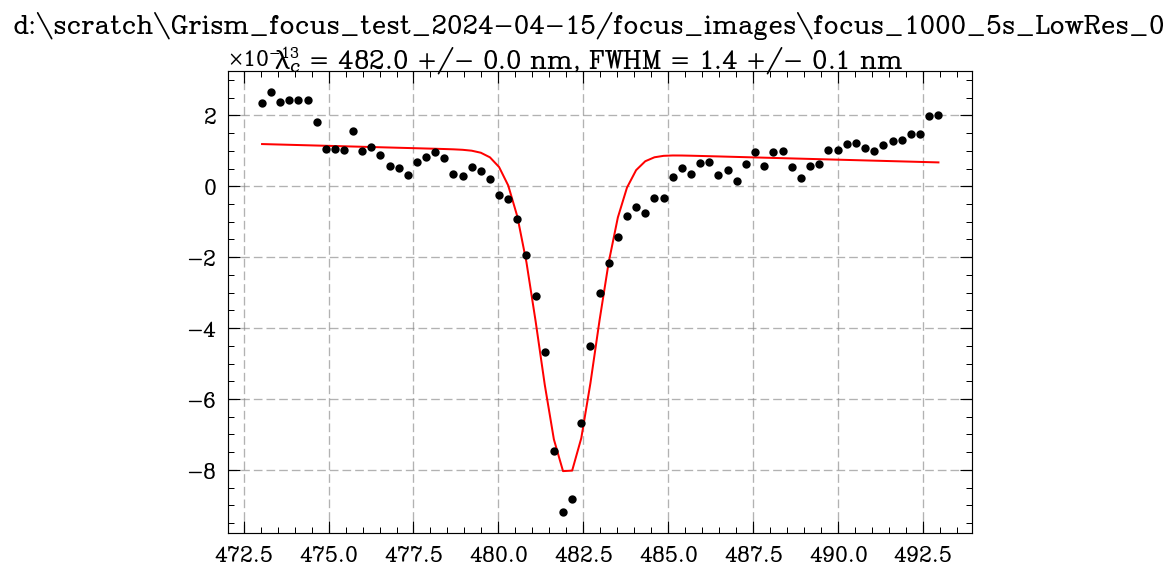

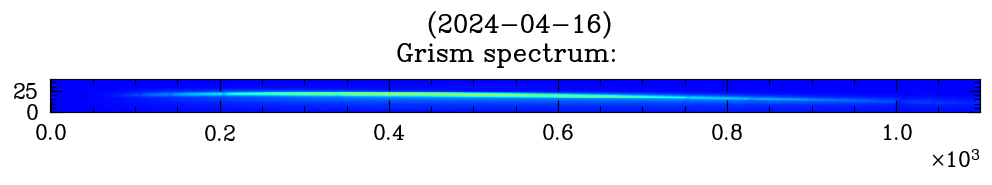

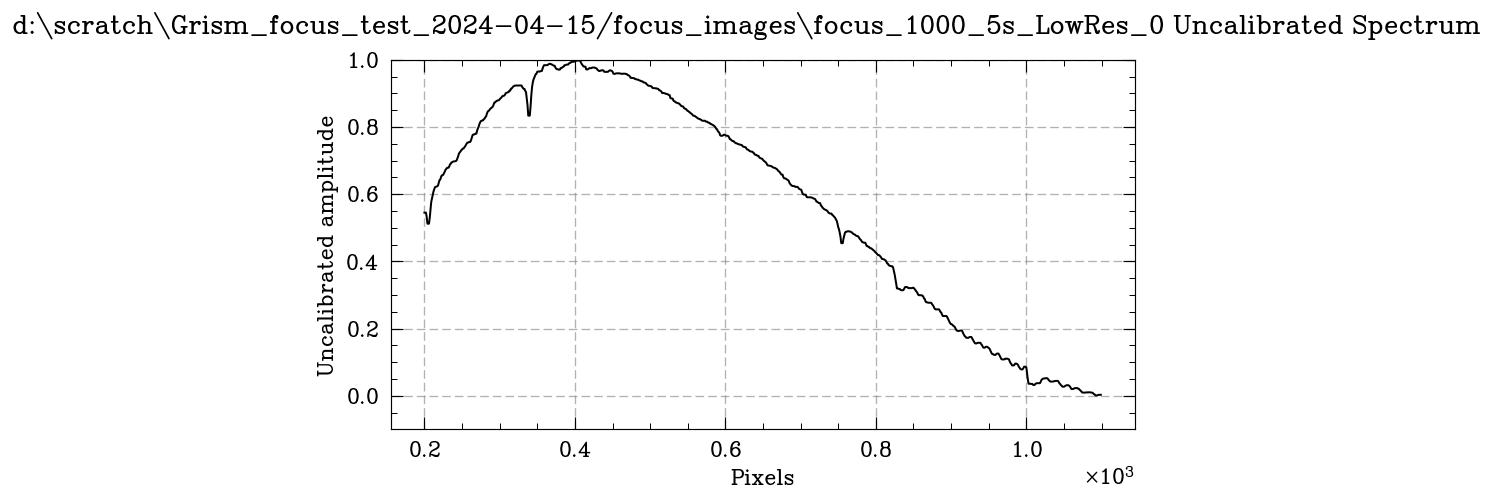

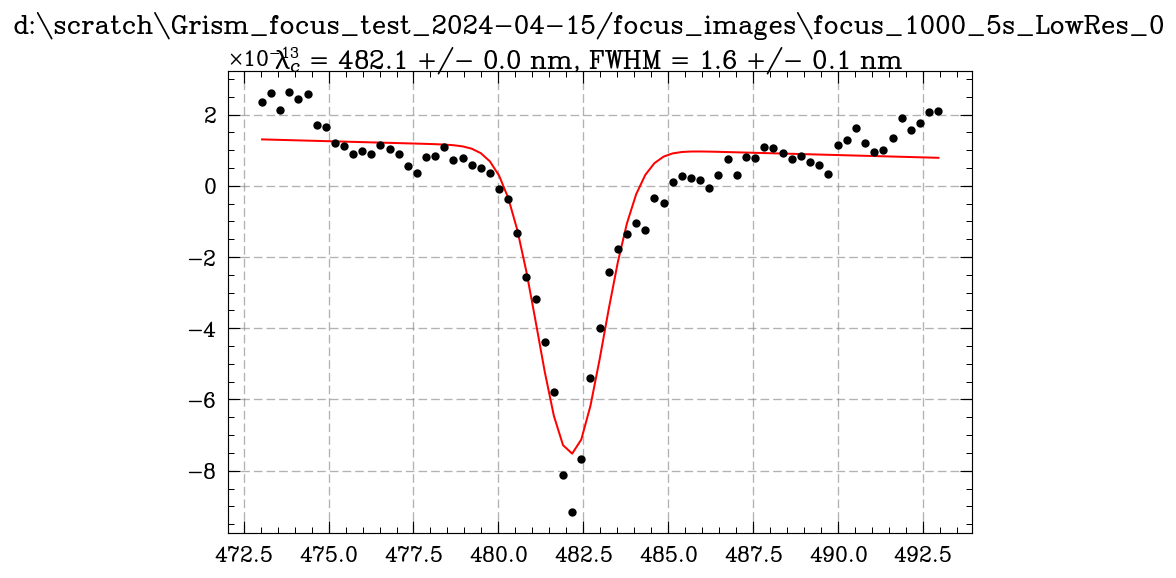

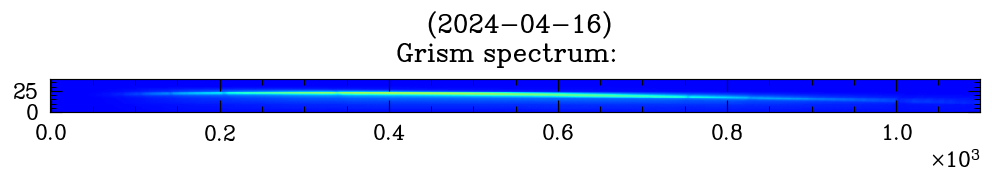

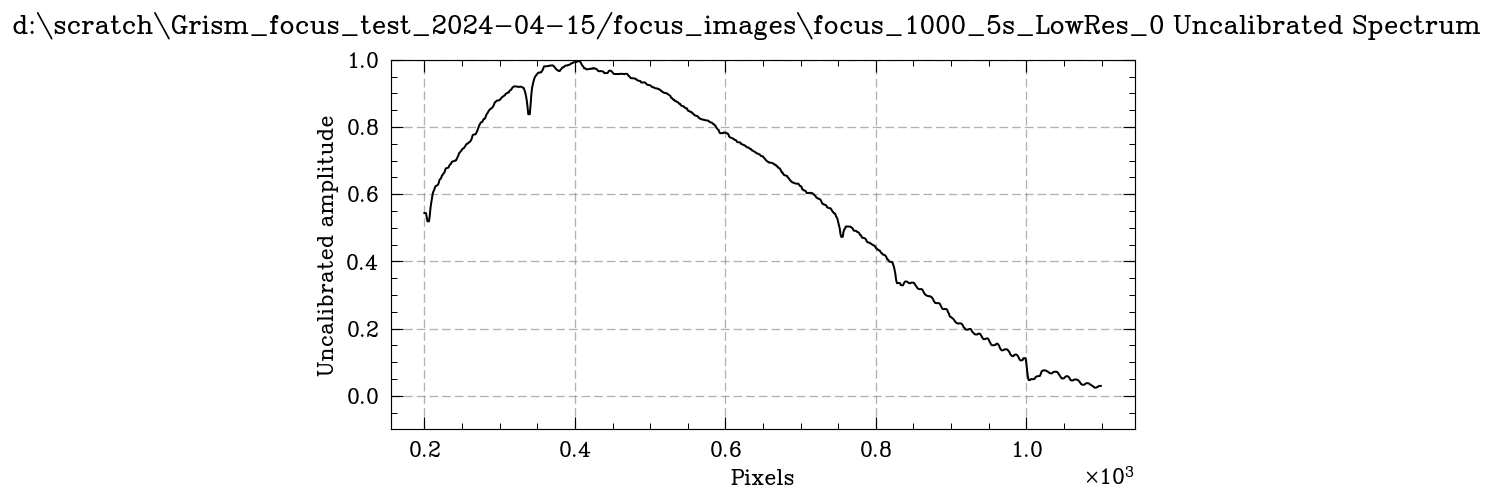

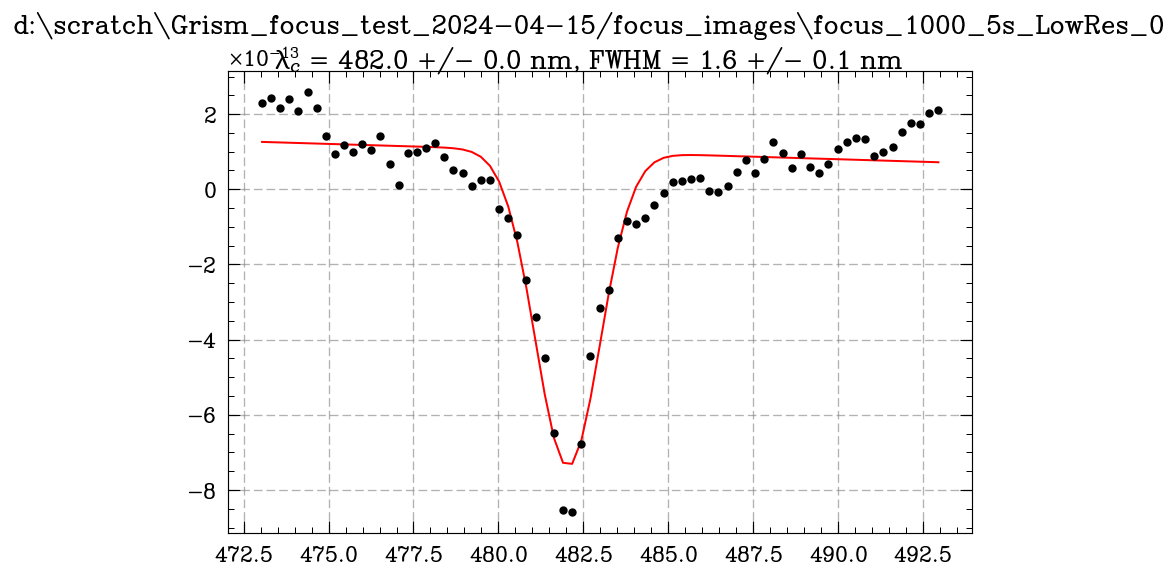

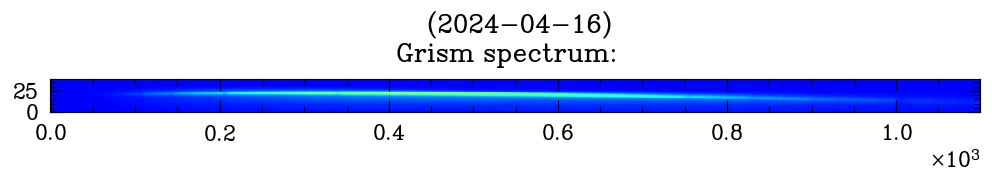

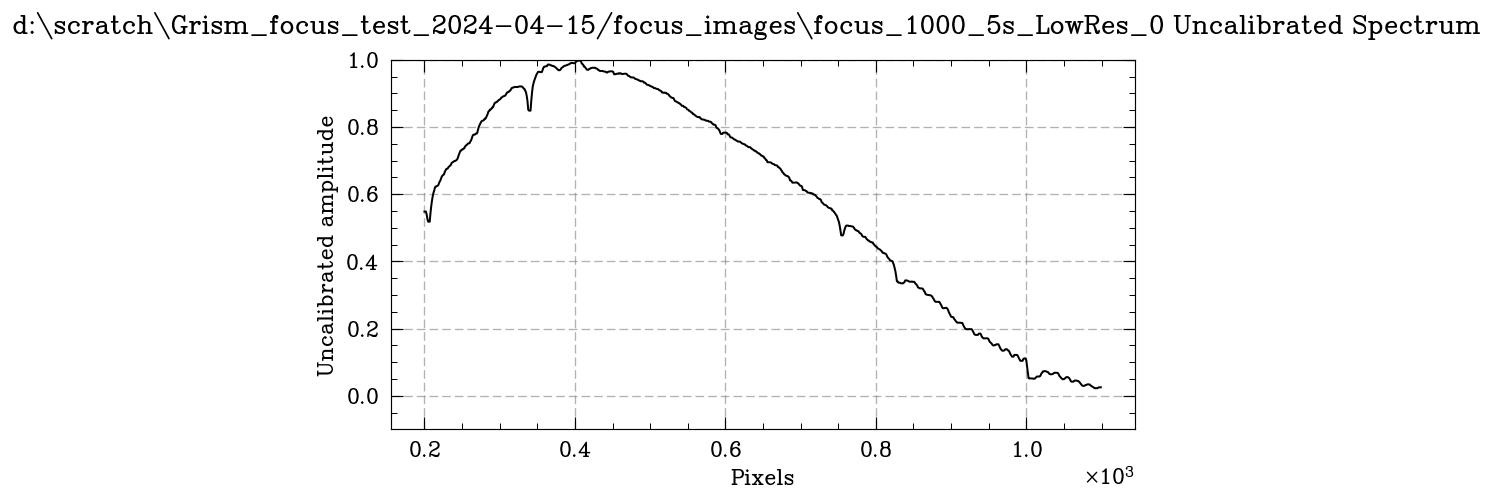

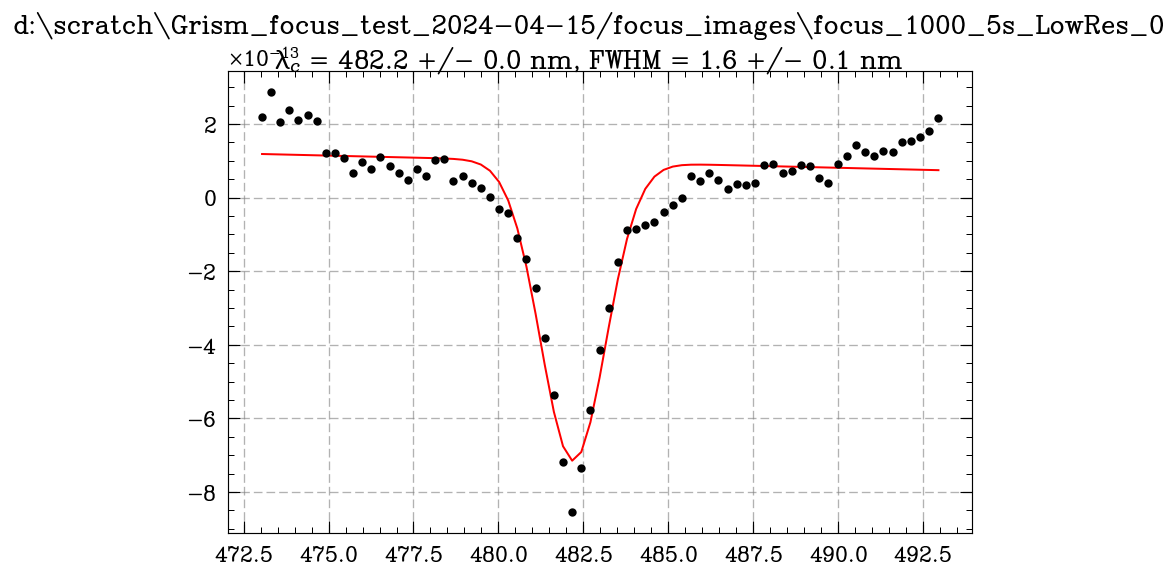

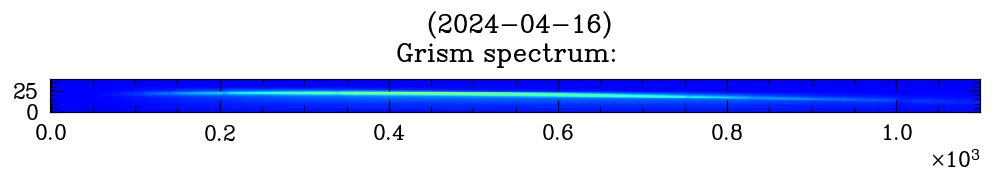

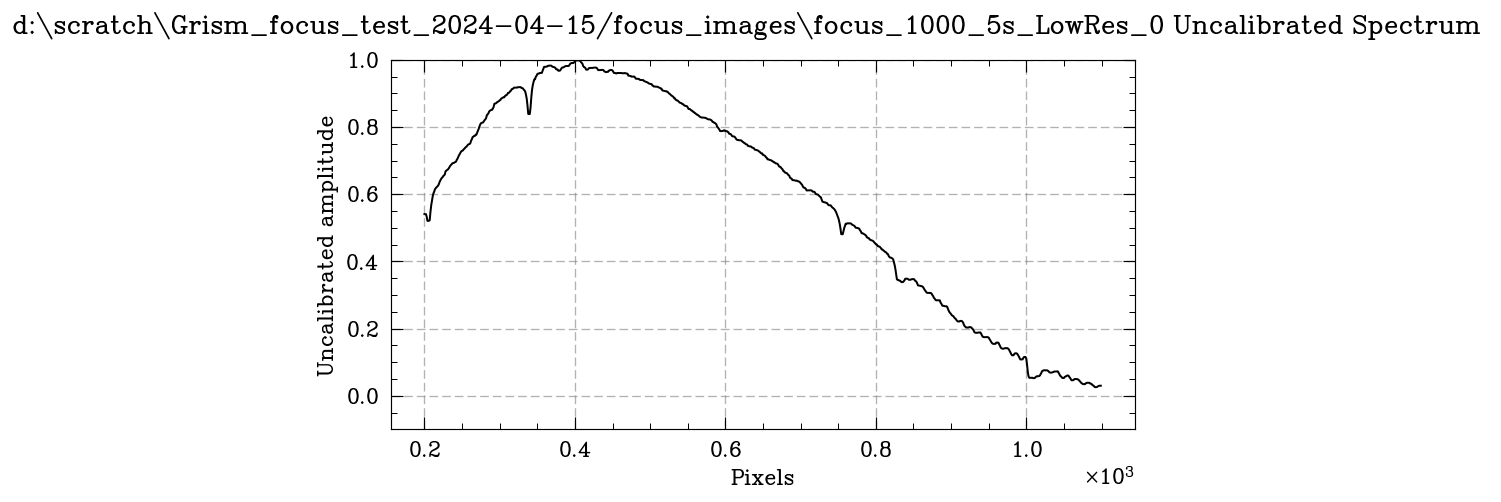

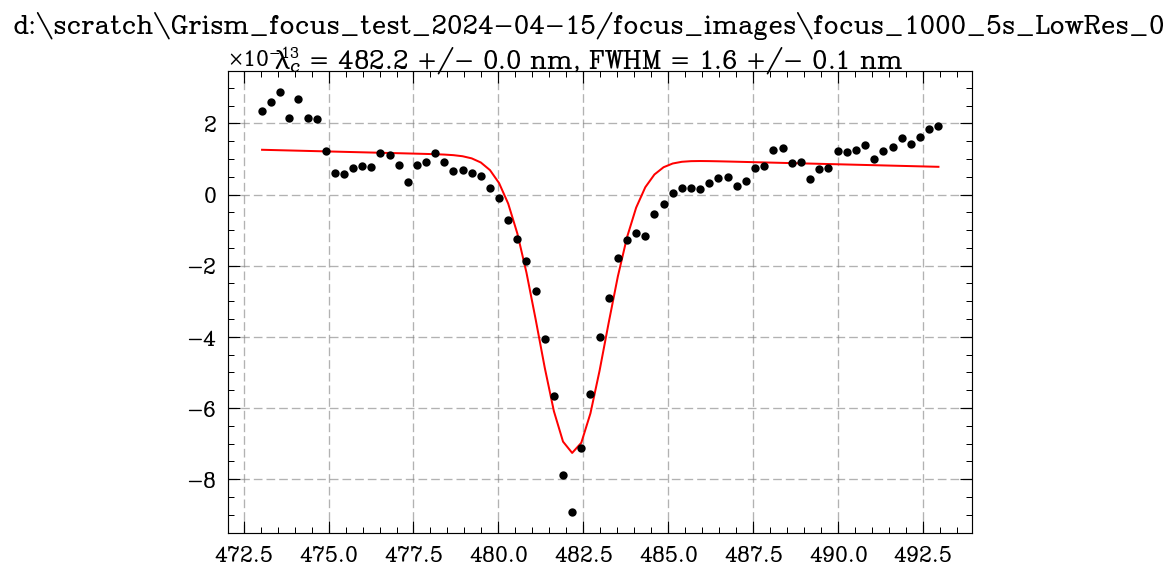

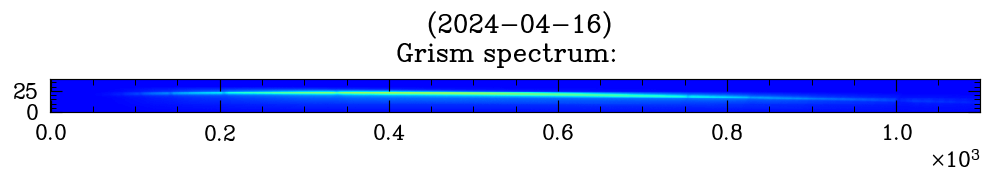

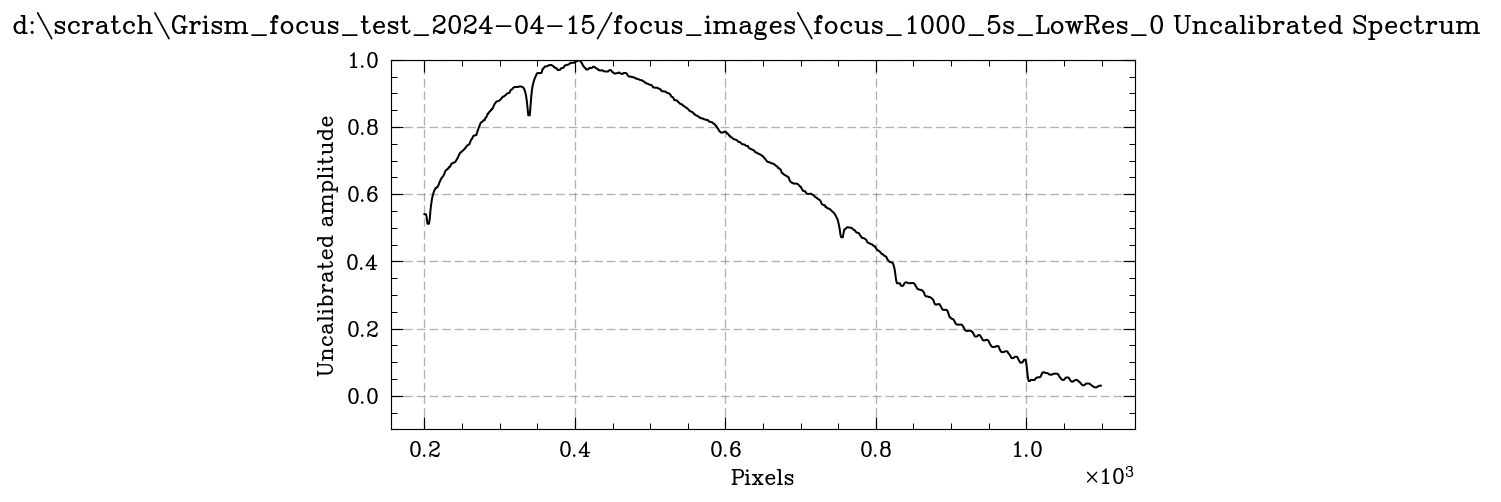

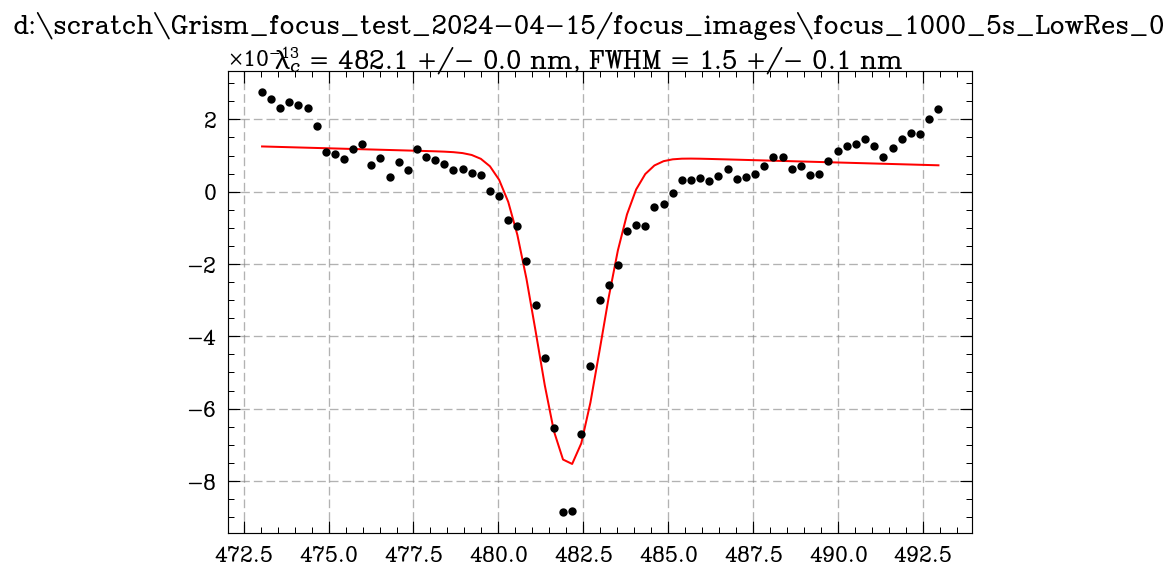

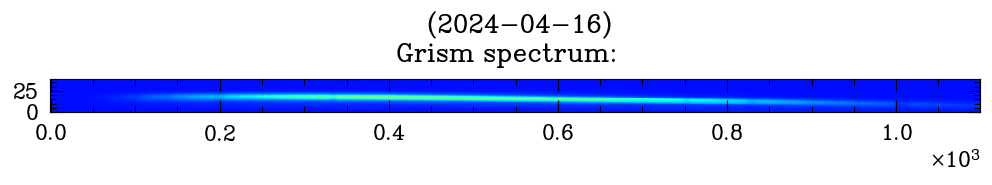

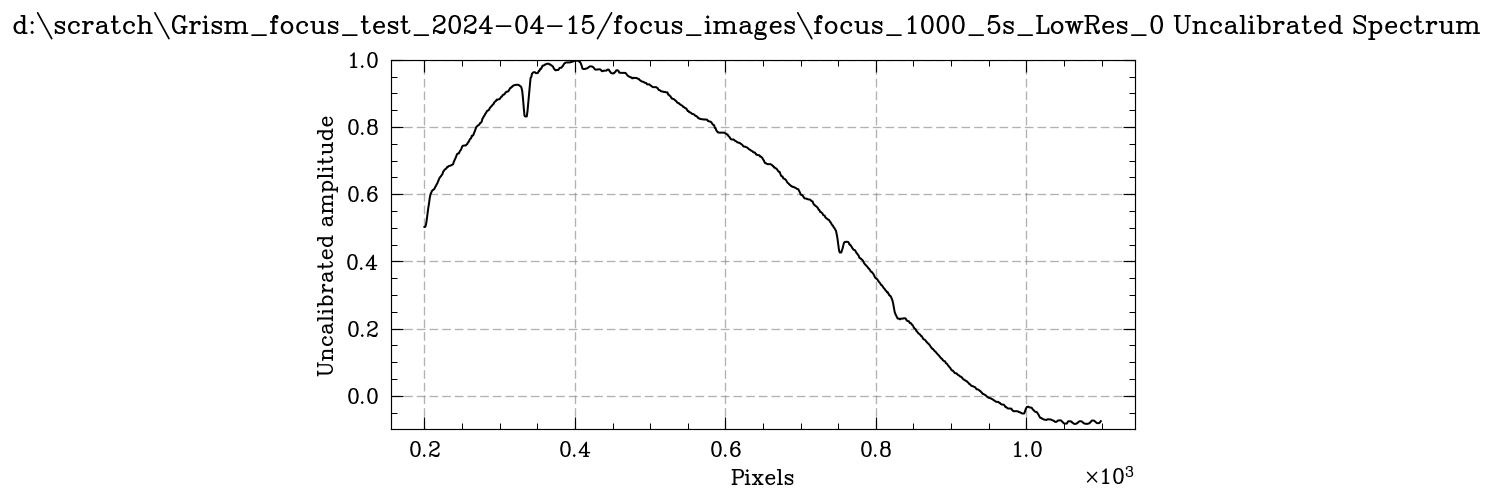

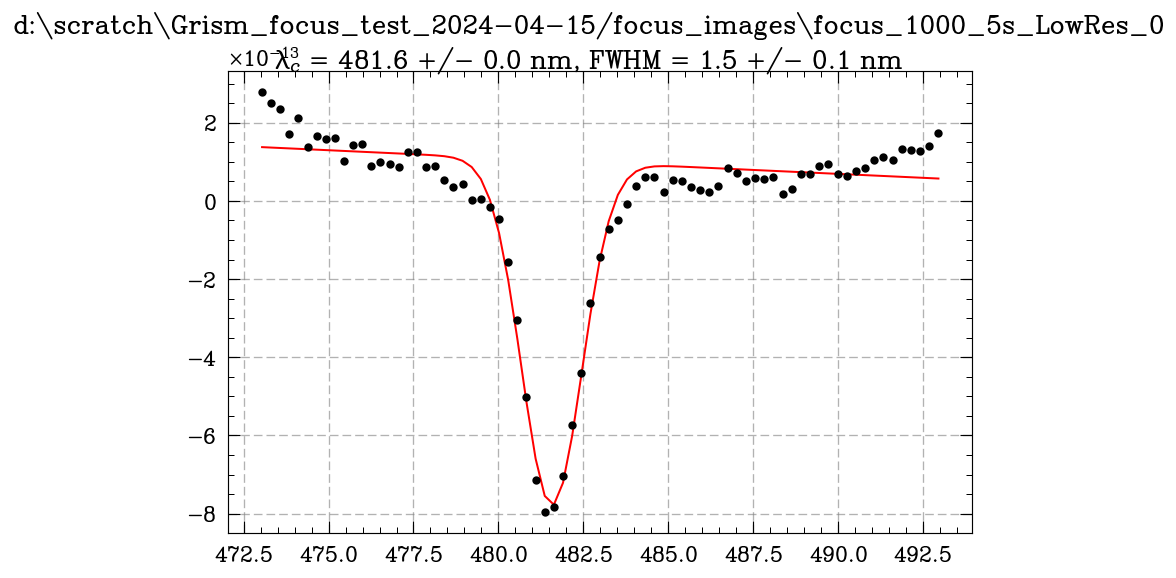

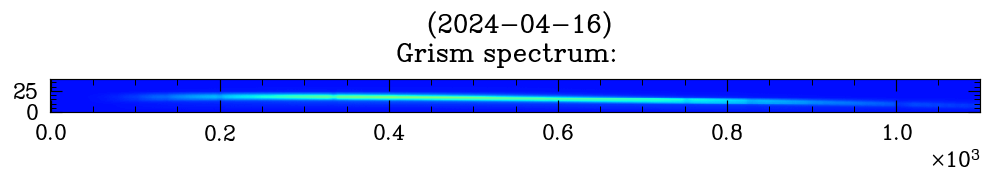

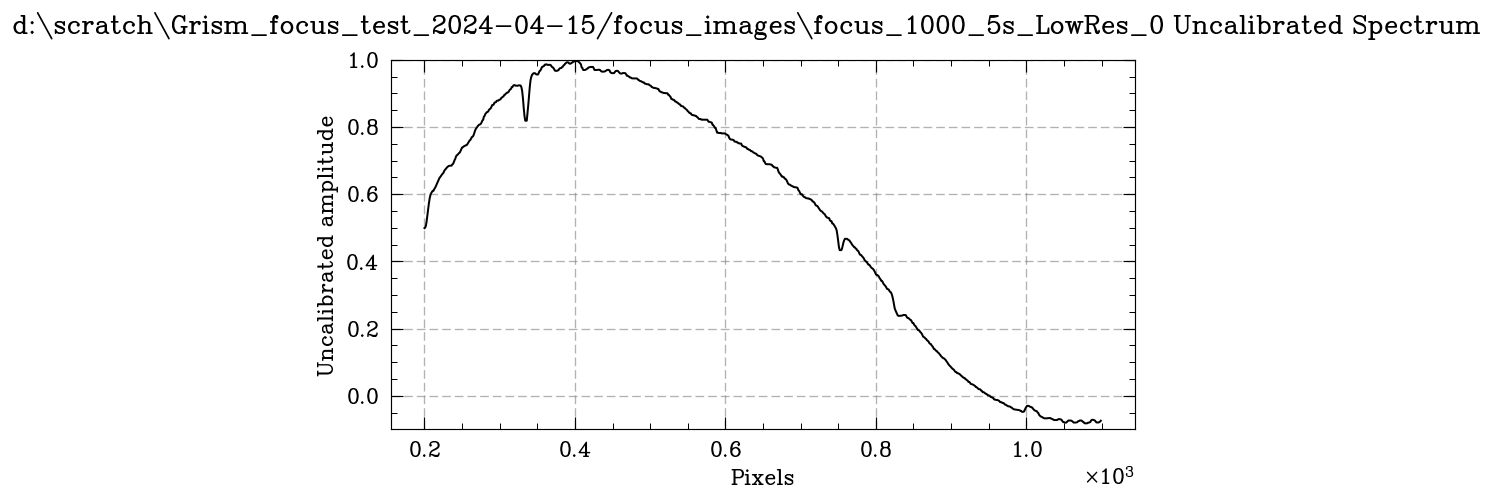

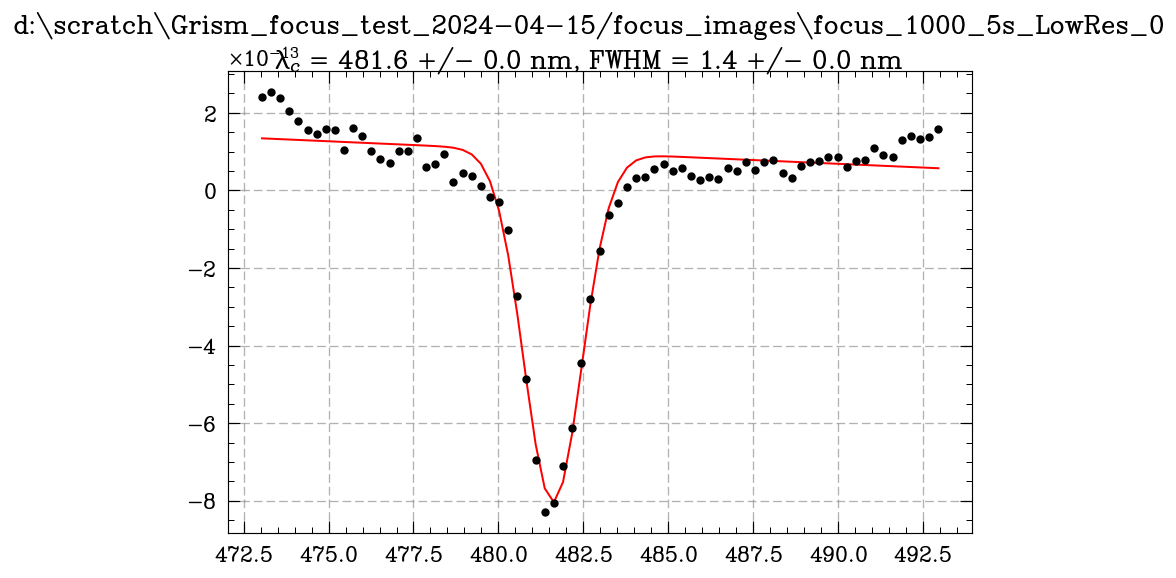

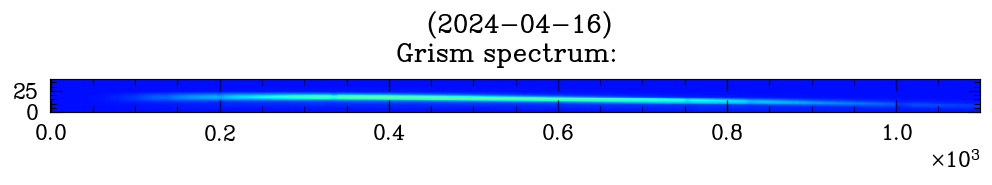

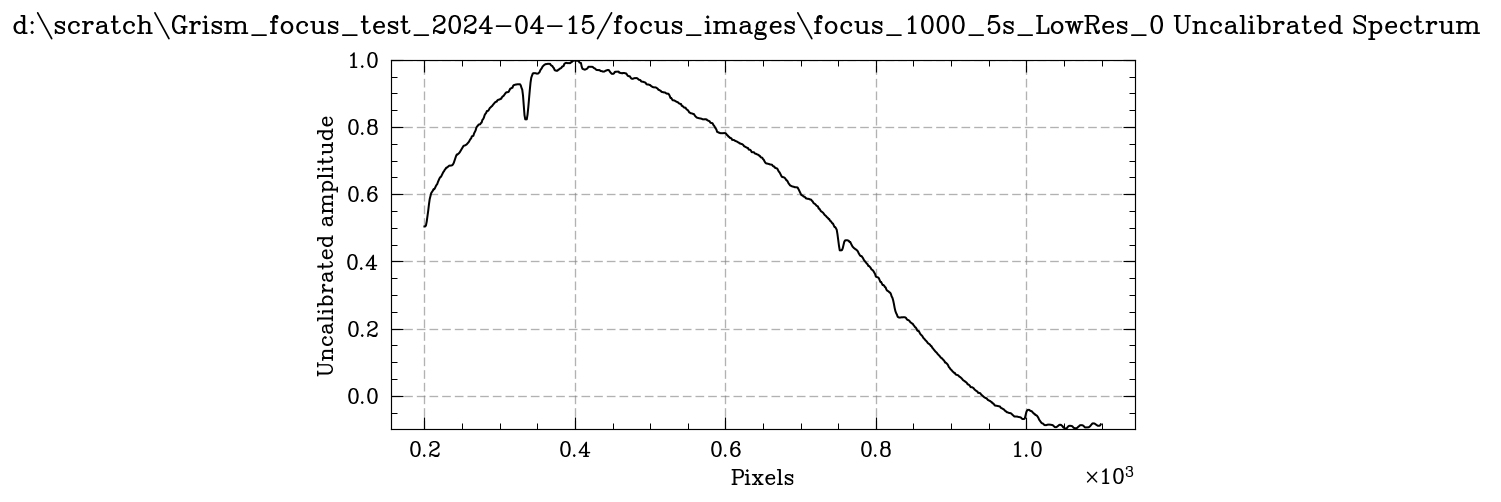

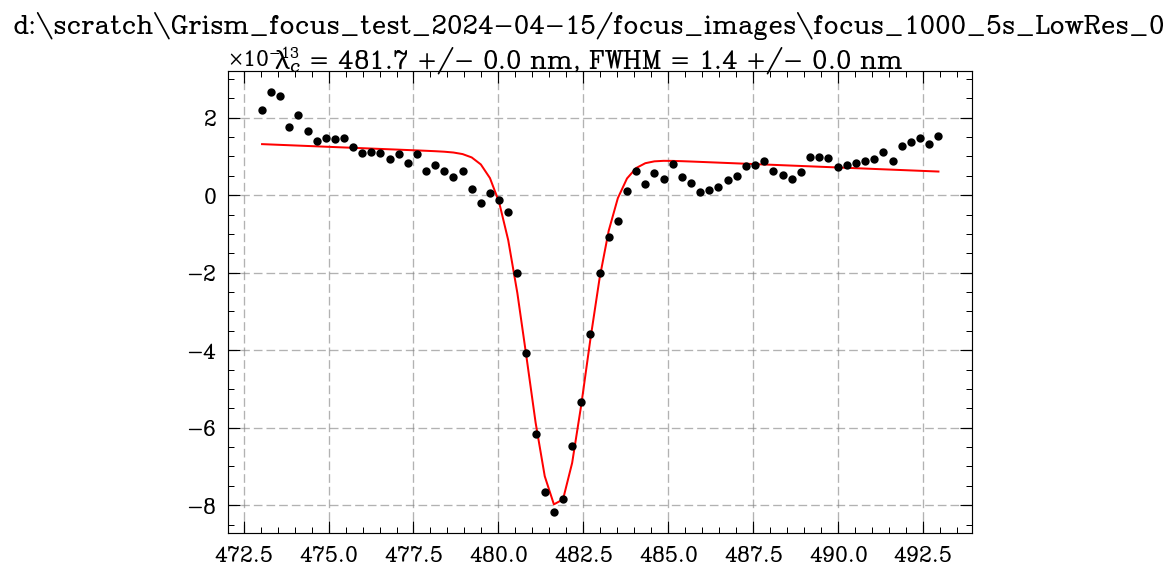

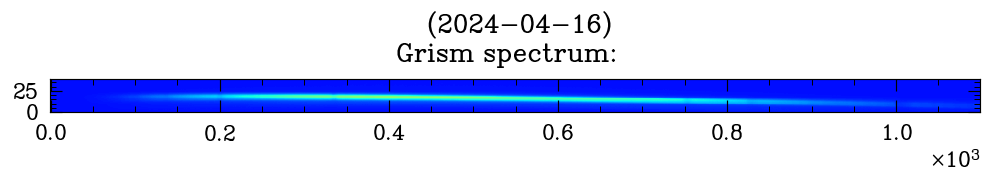

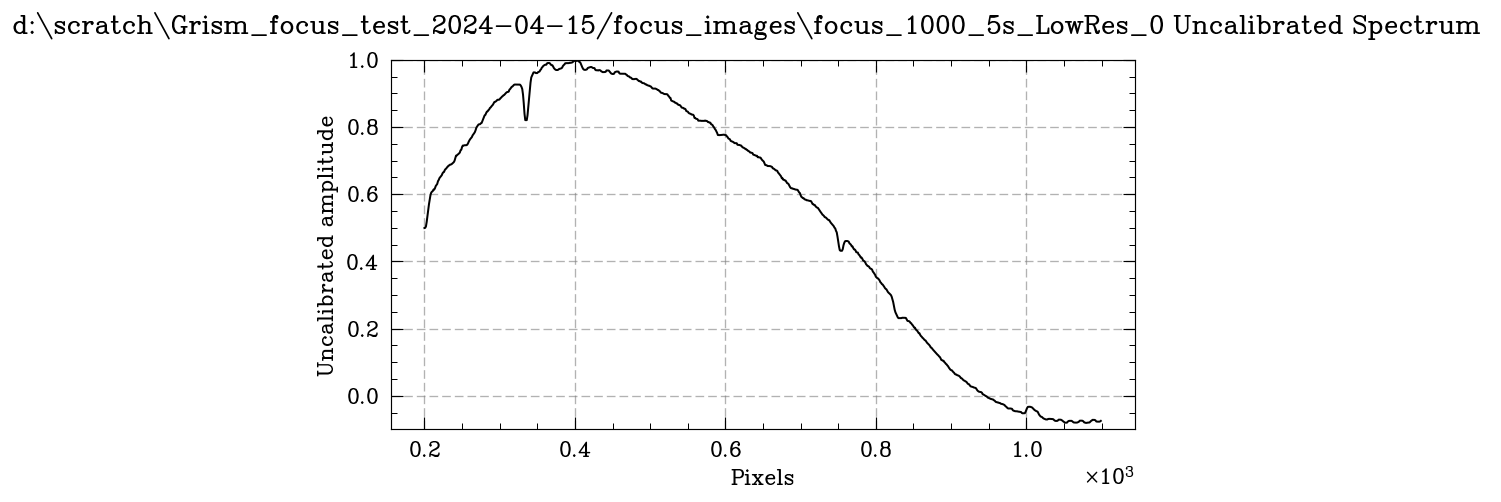

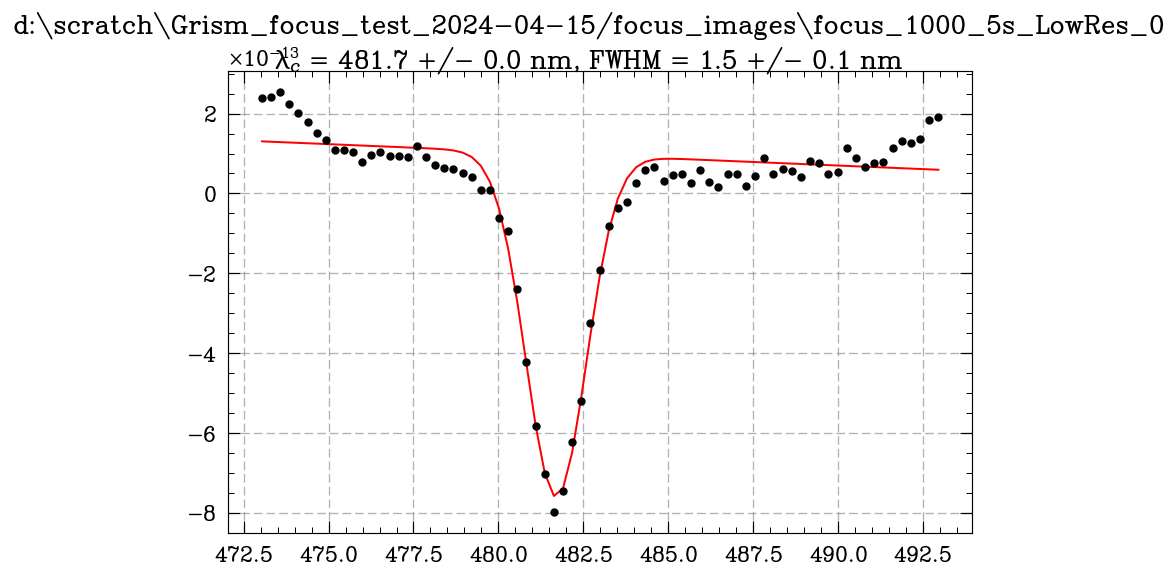

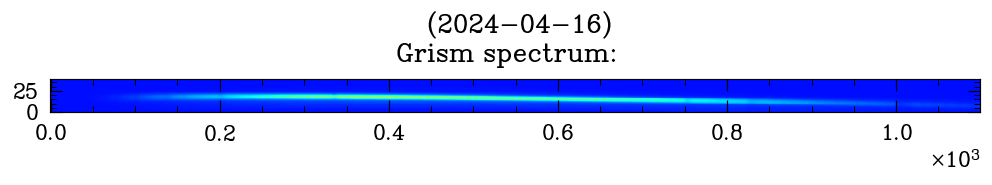

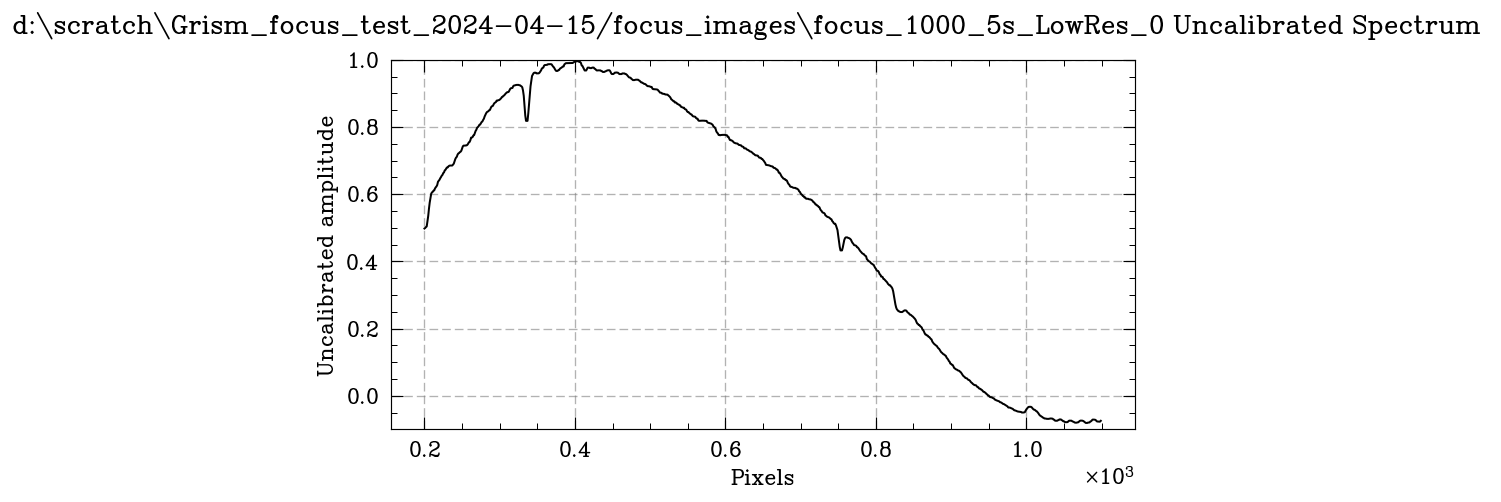

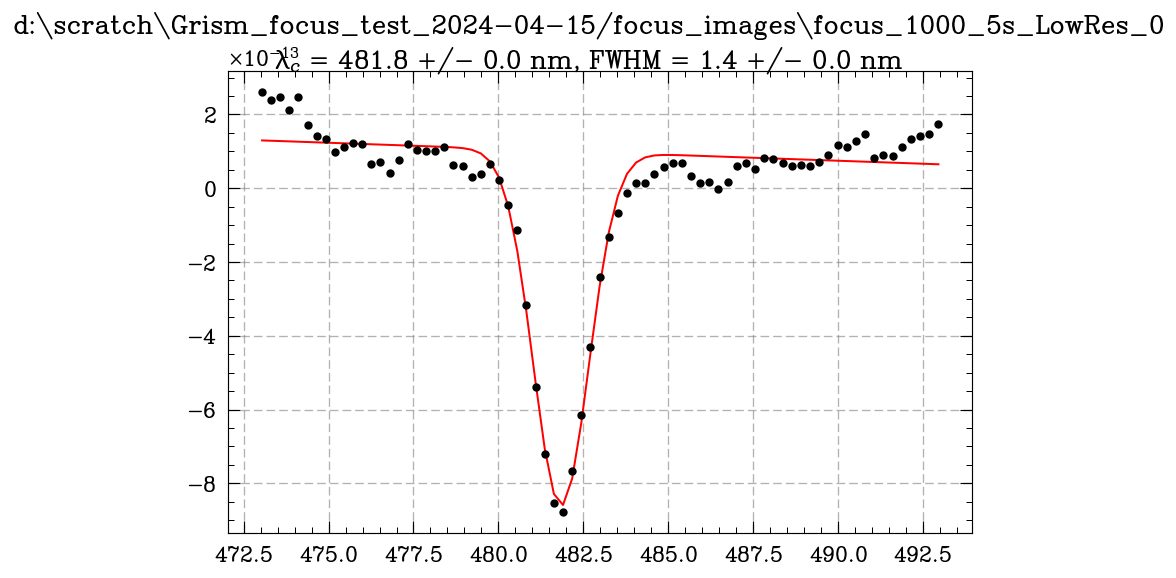

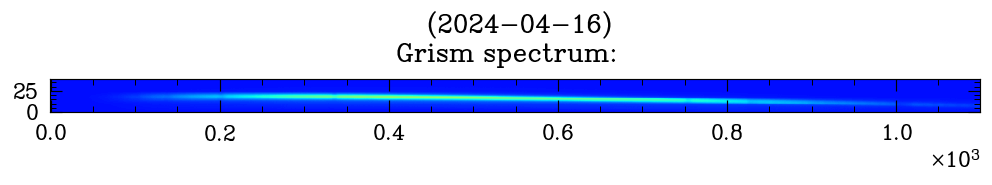

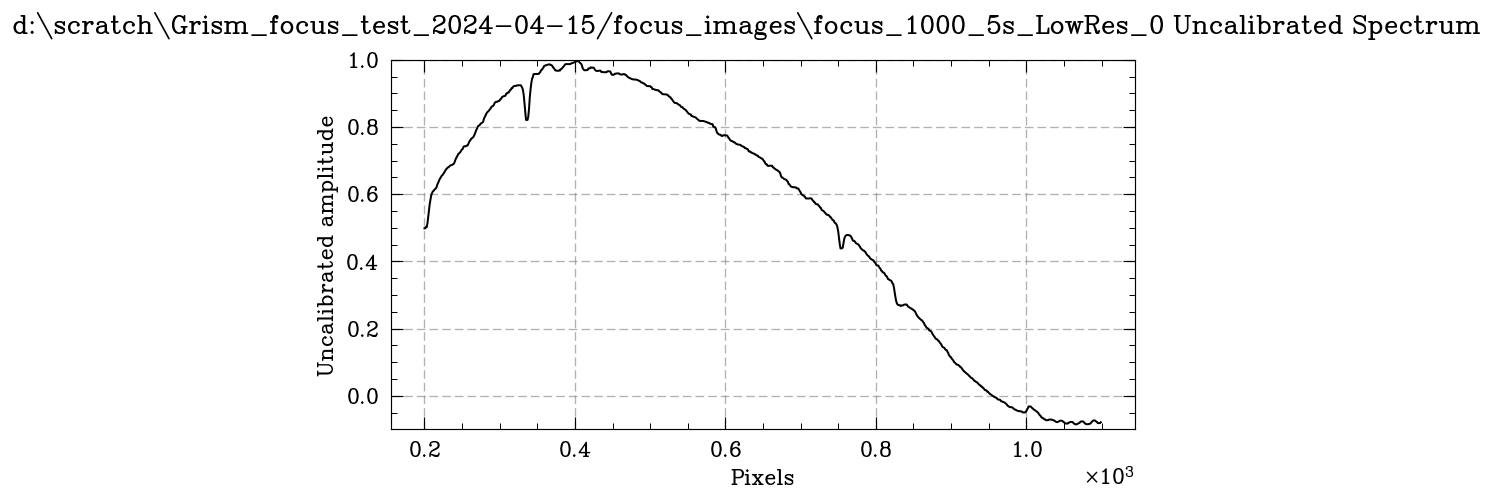

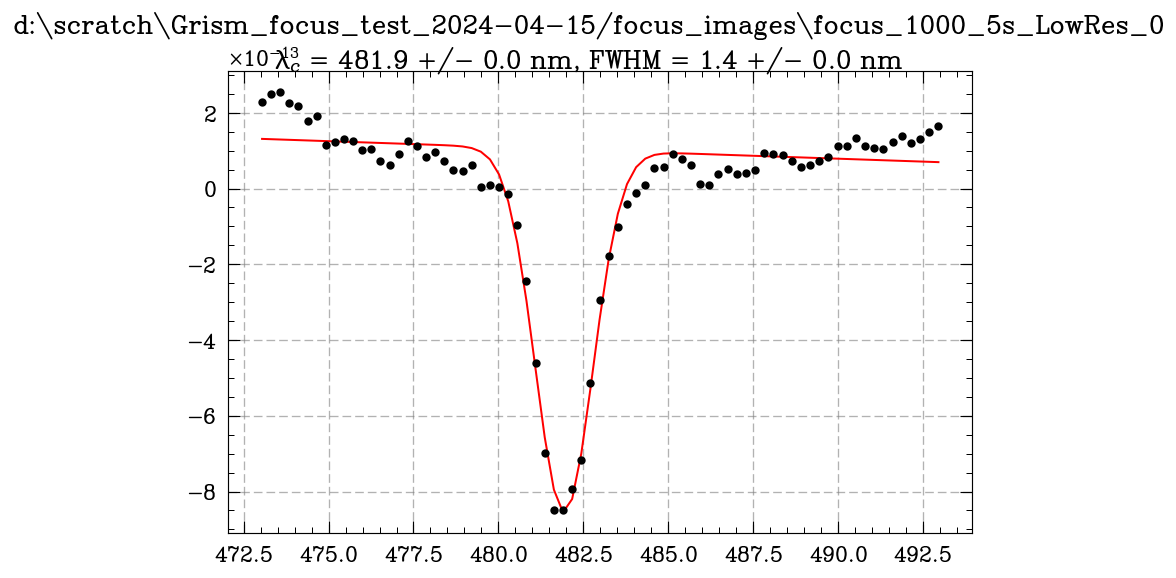

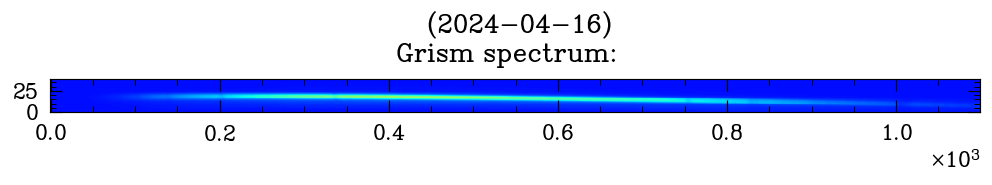

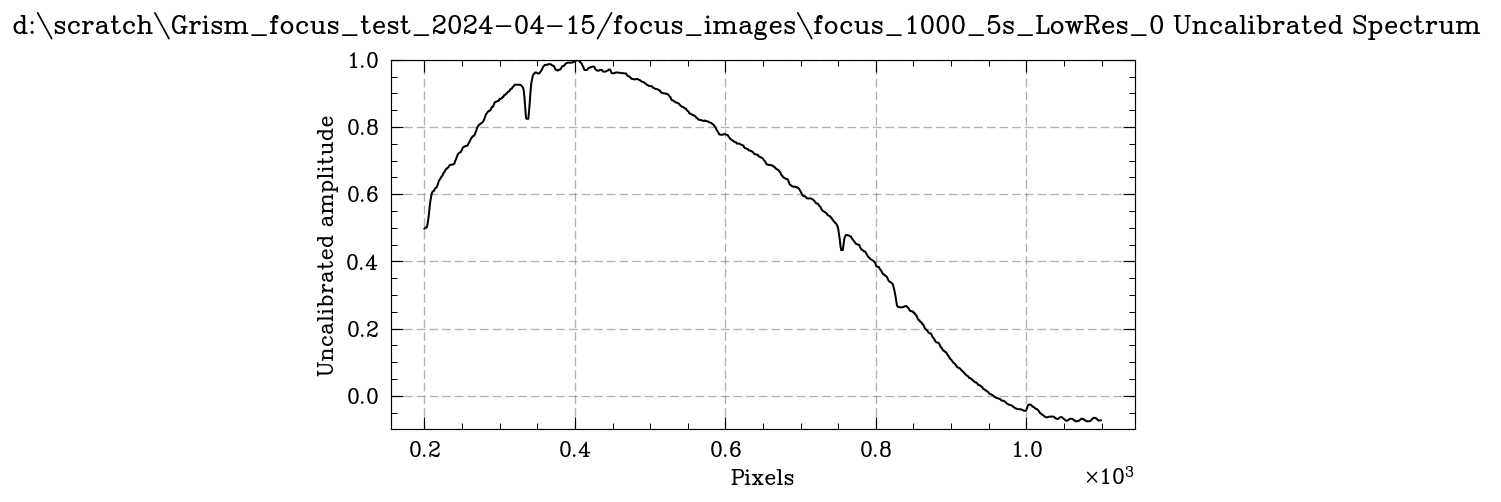

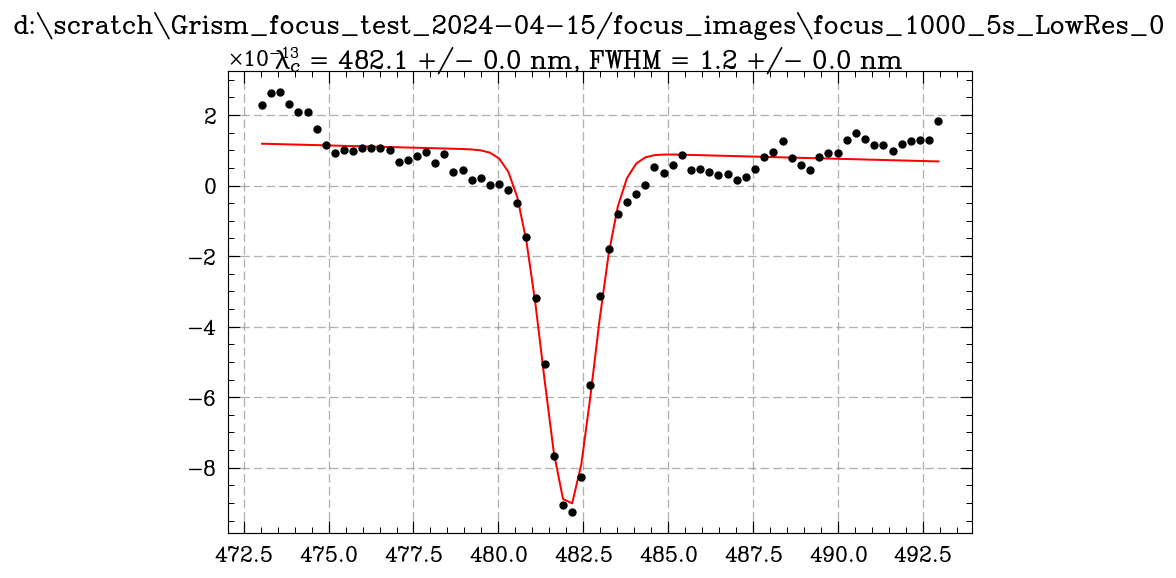

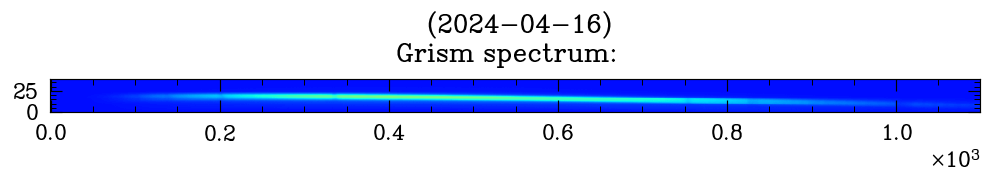

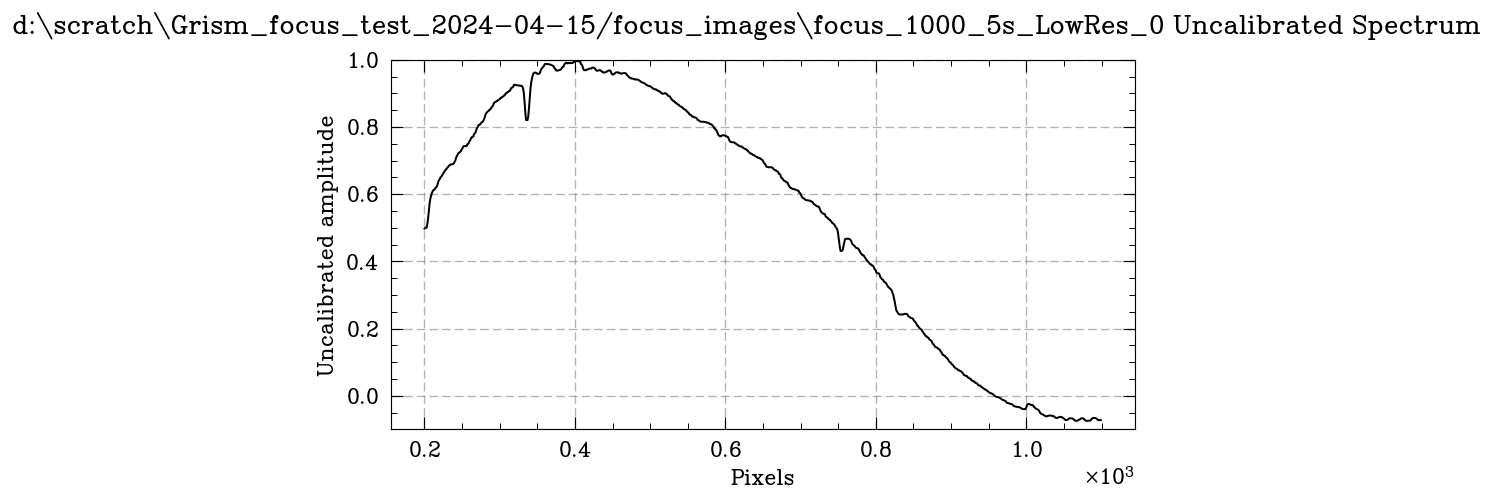

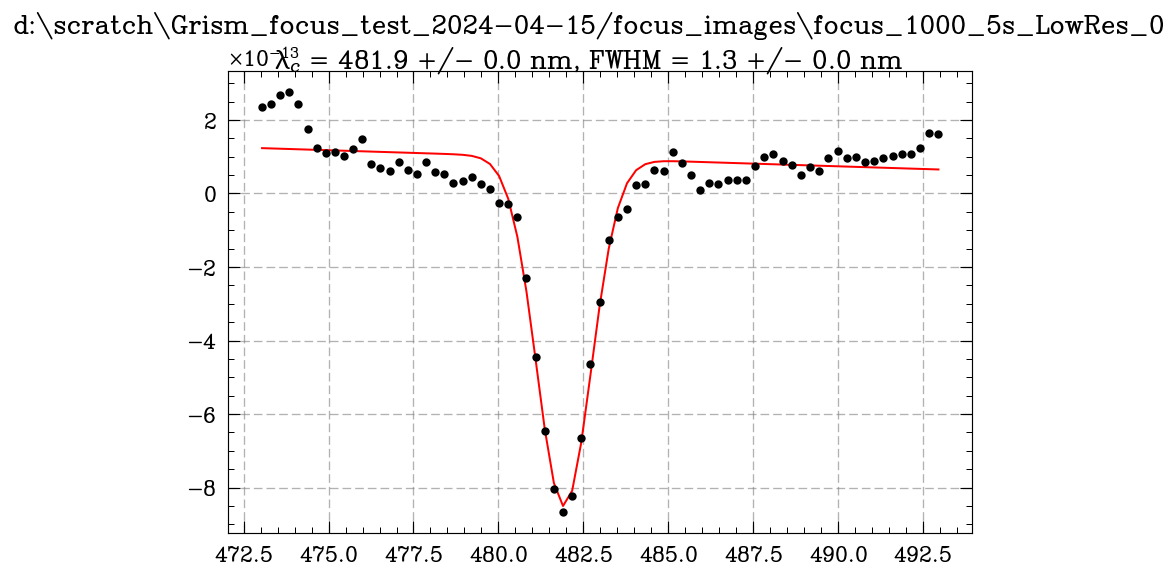

In [3]:
# Get the data:

# Set flag to create a calibration file (cf. calibrating a raw image using an existing cal file)
do_calibrate = False

for i in range(len(image_list)):
# for i in range(0,3):
    grism_image = image_list[i]
    if os.path.exists(grism_image):
        print('Found grism image: %s' % grism_image)
        im, hdr = getdata(grism_image, 0, header=True)
        object_name  = hdr['OBJECT']
        obs_date = hdr['DATE-OBS']
        focus_list.append(hdr['FOCUSPOS'])
    else:
        print('Cannot find %s, stopping' % grism_image)
        raise StopExecution  

    if not do_calibrate:
        # Specify an existing calibration file
        if os.path.exists(cal_file):
            cal_hdr, box, rot_angle, wavelength_coefficients, gain_coefficients = read_calfile(cal_file)
            f_wave = np.poly1d(wavelength_coefficients)
            f_gain = np.poly1d(gain_coefficients)
            print('Found calibration file: %s' % os.path.basename(cal_file),' ',cal_hdr)
        else:
            print('Error: Cannot find calibration file: %s' % cal_file)
            raise StopExecution  
        
    # Check for matching Jacoby image
    jacoby_dir = image_dir
    jacoby_csv = '%s%s-Jacoby-spec.csv' % (jacoby_dir,object_name)
    if os.path.exists(jacoby_csv): 
        print('Found matching Jacoby spectrum file: %s' % jacoby_csv)
        jacoby = True
        jacoby_spectrum = read_jacoby_file(jacoby_csv)
    else:
        jacoby = False
        jacoby_spectrum = np.array([])

    print('Object: %s, Date: %s' % (object_name,obs_date))

# Define naming scheme for outputs:
    rootname = 'RLMT_grism_'+str.split(image_list[i],'_')[0]+'.'+str(hdr['OBJECT'])+'_'
    print('The output files will begin with '+str(rootname))

    ## make a box

    max_loc = np.argmax(im)
    max_loc_x = max_loc % hdr['NAXIS1']
    max_loc_y = max_loc // hdr['NAXIS1']
    print(max_loc_x, max_loc_y)
 
# defining subimage box dimensions as specified by user
    print('Creating subimage...')
    xi,yi = im.shape
    xstart = 550
    ystart = 755
    # ystart = max_loc_y - 15
    xwidth = 1100
    ywidth = 40
    rotangle = 357.3
    mybox  = [xstart,ystart,xwidth,ywidth]
    print(f'Drawing box at {xstart},{ystart} with dimensions {xwidth},{ywidth}')
    print(f'Full image dimensions: {xi},{yi}')
    print(f'Rotation angle = {rotangle} deg')

    # Instantiate with rotation angle and subimage box
    B = grism_utils(grism_image,rotangle,mybox,f_wave,f_gain)

    # Create subimage using optional box parameters
    subim,transim = B.create_box()
    xs,ys = subim.shape
    zmax = np.max(subim)
    print(f'Maximum ADU count in subimage = {zmax}')

    # Plot subimage
    object_name, obs_date,telescope,title,im,rot_angle, box, _,_ = B.summary_info()
    fig = B.plot_image(image=subim,figsize =(10,2),cmap='jet',title=title)
    print(object_name)
    #fig.savefig(rootname+'box.png',dpi=200, bbox_inches = 'tight', transparent=False, facecolor='whitesmoke')    

    print('Extracting spectrum...')
    spectrum = B.calibrate_spectrum(subim)
    print('Plotting...')
    fig = B.plot_spectrum(spectrum, xaxis='pixel', yaxis='uncal', subrange = slice(200,2000),\
                        title='%s Uncalibrated Spectrum '
                        % root, medavg = 5,xlims =[0,0],ylims =[-0.1,1])
    fig.savefig(root+'.uncalibrated.png',dpi=200, bbox_inches = 'tight', transparent=False, facecolor='whitesmoke') 

    # #define range of xpixels to average over
    # xpixelctr = 600
    # xpixelctr = 1000

    # xpixelbuffer = 100

    # #get list of average yvals over specified x range
    # pxrange = np.arange(xpixelctr-xpixelbuffer,xpixelctr+xpixelbuffer)

    # ylist = []
    # for i in pxrange:
    #         ycol = subim[:,i]
    #         ylist.append(ycol)

    # ystack = np.stack(ylist)

    # yvals = np.mean(ystack,axis=0)

    # range = np.linspace(0,len(yvals),len(yvals))

    # plt.plot(range,yvals)

    # def gaussian(x, x0, a, sigma):
    #         t = (x-x0) /sigma
    #         f = a*np.exp(-t**2)+6000
    #         return f

    # p0 =[11,2500,2]
    # yparams,_ = curve_fit(gaussian,range,yvals,p0)

    # x0,a,sigma = yparams

    # plt.plot(range,gaussian(range,x0,a,sigma))
    # fwhm = 2.35 * sigma
    # print(yparams)
    # print(fwhm)
    # # append to list
    # profile_fwhm_list.append(fwhm)

    # plt.title('Fit: '+root+', FWHM = '+str(round(fwhm,2)))
    # plt.savefig(root+'.profile.png',dpi=200, bbox_inches = 'tight', transparent=False, facecolor='whitesmoke')   
    # plt.show() 


# Fit a line with Gaussian and  plot
    wave_min = 473 ; wave_max = 493
    # wave_min = 700 ; wave_max = 800

    print('Fitting feature...')
    params, wave, amp, amp_mod = B.fit_gaussian(spectrum,wave_min,wave_max)
    wave_ctr,wave_ctr_err,fwhm,fwhm_err,a,a_err = params
    print('Wave_ctr = %.1f +/- %.1f nm, FWHM = %.1f +/- %.1f nm\n' % (wave_ctr,wave_ctr_err, fwhm, fwhm_err))
    print('Plotting...')
    fig = B.plot_spectral_line(wave,amp,amp_mod,color='red',title=root)
    fig.savefig(root+'.gaussian.png',dpi=200, bbox_inches = 'tight', transparent=False, facecolor='whitesmoke')
    gaussian_fwhm_list.append(fwhm)


In [4]:
# print lists:
print(len(focus_list),len(gaussian_fwhm_list))
# print(profile_fwhm_list)
# print(gaussian_fwhm_list)


40 40


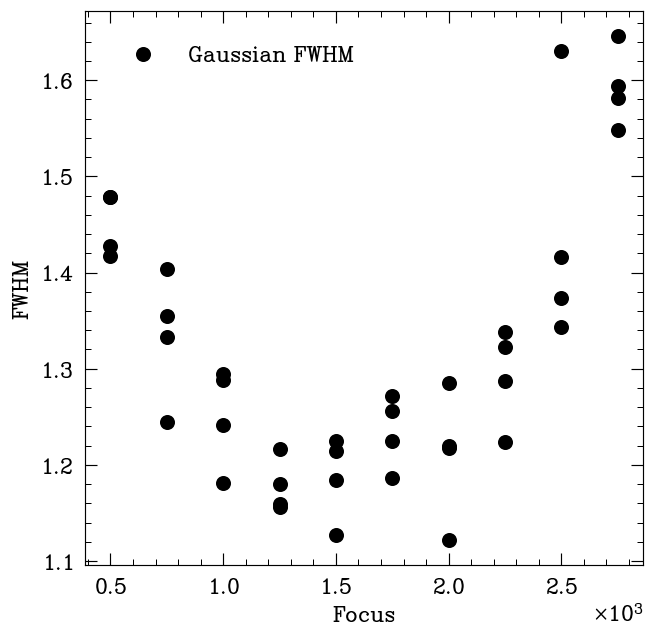

In [7]:
# plot focus vs fwhm
fig, ax = plt.subplots()
# ax.plot(focus_list,profile_fwhm_list,label='Profile FWHM')
ax.scatter(focus_list,gaussian_fwhm_list,label='Gaussian FWHM')
ax.set_xlabel('Focus')
ax.set_ylabel('FWHM')
# fit a curve to the data
fit = np.polyfit(focus_list,gaussian_fwhm_list,2)
p = np.poly1d(fit)
# find minimum of the curve
min_fwhm = np.min(p(focus_list))
min_focus = np.min(focus_list)
# ax.scatter(min_focus,min_fwhm,label='Min FWHM',color='red')
# ax.plot(focus_list,p(focus_list),label='Fit', color='red')
# add text showing minimum focus:
# text = 'Min FWHM = '+str(round(min_fwhm,2))+' at focus = '+str(min_focus)
# ax.text(0.5, 0.5, text, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax.legend()
plt.show()
# Save plot:
fig.savefig('focus_vs_fwhm_lowres.png',dpi=200, bbox_inches = 'tight', transparent=False, facecolor='whitesmoke')
